In [1]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,Activation, Flatten, TimeDistributed, \
Conv1D,MaxPooling1D,Input, LSTM
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model,X_test,y_test,type_cm,display_labels,cmap=plt.cm.Blues,normalize=True):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    c_mat = confusion_matrix(y_test,y_pred)
    if normalize:
        c_mat = np.round(c_mat.astype('float') / c_mat.sum(axis=1)[:, np.newaxis],4)
    plt.imshow(c_mat, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix'+type_cm)
    plt.colorbar()
    tick_marks = np.arange(len(display_labels))
    plt.xticks(tick_marks, display_labels, rotation=0)
    plt.yticks(tick_marks, display_labels)
    thresh = c_mat.max() / 2.
    for i, j in itertools.product(range(c_mat.shape[0]), range(c_mat.shape[1])):
        plt.text(j, i, c_mat[i, j],
                 horizontalalignment="center",
                 color="white" if c_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def disp_confusion_matrix(model,X,y,type_cm,class_label):
    disp = plot_confusion_matrix(model, X, y, type_cm,display_labels=class_label,
                                 cmap=plt.cm.Blues)
    
def testers(lr,model,epochs=100,verb=1,batch_size=30):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    num_epochs = epochs
    history = model.fit(X_train,y_train, epochs = num_epochs, batch_size=batch_size,\
                        shuffle=False, verbose=verb,validation_data=(X_test,y_test))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Costo vs Época')
    plt.ylabel('Costo')
    plt.xlabel('Época')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    disp_confusion_matrix(model,X_test,y_test,' first six set A',class_label=['Left Hand','Right Hand','Neutral']) 
    
def keras_model_memory_usage_in_bytes(model, *, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

In [3]:
#Import preprocessed data
path ='Pre-Dat/SSA/Fp1-F3-P4-O2-A1-T3'
extension = ''
X_train = np.load(path+'/X_train'+f'{extension}.npy')
X_test = np.load(path+'/X_test'+f'{extension}.npy')
y_train = np.load(path+'/y_train'+f'{extension}.npy')
y_test = np.load(path+'/y_test'+f'{extension}.npy')
# Transform into sub-sequences of 50 time points
n_steps, n_length,n_features = 4, 50,X_train.shape[2]
X_train = X_train.reshape([X_train.shape[0],n_steps,n_length,n_features])
X_test = X_test.reshape([X_test.shape[0],n_steps,n_length,n_features])

# # Transform into sub-sequences of 25 time points
# n_steps, n_length,n_features = 8, 25,X_train.shape[2]
# X_train = X_train.reshape([X_train.shape[0],n_steps,n_length,n_features])
# X_test = X_test.reshape([X_test.shape[0],n_steps,n_length,n_features])

In [4]:
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (10880, 4, 50, 6)
y train shape: (10880, 3)
X test shape: (2720, 4, 50, 6)
y test shape: (2720, 3)


In [8]:
def CNN_LSTM_model (n_features,activation='tanh',dense_activation='relu',dropout_rate=0.2,batch_normalization=True):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=128,kernel_size=2, activation='relu'),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=128,kernel_size=2, activation='relu')))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(dropout_rate)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(200,activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_normalization:
        model.add(BatchNormalization()) 
    model.add(Dense(200, activation=dense_activation))
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.001)))
    return model

In [9]:
model = CNN_LSTM_model(200,6,activation='tanh',dense_activation='tanh',dropout_rate=0.5)
model.summary()

TypeError: CNN_LSTM_model() got multiple values for argument 'activation'

In [19]:
keras_model_memory_usage_in_bytes(model,batch_size=64)

10801571

In [ ]:
#Hard_sigmoid
testers(1e-3,model,epochs=100,batch_size=100)

## GridSearch CV

In [29]:
def CNN_LSTM_model_cv (filters=64,neurons=150,n_steps=200,n_features=21,activation='tanh', init_mode='glorot_normal',lr=1e-3,\
                    conv_activation='relu',dense_activation='hard_sigmoid',dropout_rate=0.5,batch_normalization=True):
    model = Sequential()
    #CNN
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation)))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(dropout_rate)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    #LSTM
    model.add(LSTM(neurons,activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_normalization:
        model.add(BatchNormalization()) 
    #Dense
    model.add(Dense(neurons,kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Decision
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    return model

In [30]:
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

In [26]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [31]:
model = KerasClassifier(model=CNN_LSTM_model_cv,verbose=1)
#Define parameter grid
batch_size= [40,60,80,100]
epochs= [50,100,150,200]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train[:1500], y_train[:1500])

Epoch 1/50
19/19 [==============================] - 2s 10ms/step - loss: 1.8577 - accuracy: 0.3680
Epoch 2/50
19/19 [==============================] - 0s 7ms/step - loss: 1.6286 - accuracy: 0.3893
Epoch 3/50
19/19 [==============================] - 0s 6ms/step - loss: 1.5958 - accuracy: 0.4067
Epoch 4/50
19/19 [==============================] - 0s 7ms/step - loss: 1.5377 - accuracy: 0.3987
Epoch 5/50
19/19 [==============================] - 0s 7ms/step - loss: 1.4002 - accuracy: 0.4280
Epoch 6/50
19/19 [==============================] - 0s 7ms/step - loss: 1.3338 - accuracy: 0.4440
Epoch 7/50
19/19 [==============================] - 0s 6ms/step - loss: 1.2539 - accuracy: 0.4907
Epoch 8/50
19/19 [==============================] - 0s 6ms/step - loss: 1.1579 - accuracy: 0.5107
Epoch 9/50
19/19 [==============================] - 0s 7ms/step - loss: 1.0681 - accuracy: 0.5347
Epoch 10/50
19/19 [==============================] - 0s 6ms/step - loss: 1.0149 - accuracy: 0.5800
Epoch 11/50
19/19 

19/19 [==============================] - 0s 6ms/step - loss: 0.1313 - accuracy: 0.9667
Epoch 65/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0996 - accuracy: 0.9707
Epoch 66/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1332 - accuracy: 0.9720
Epoch 67/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1018 - accuracy: 0.9733
Epoch 68/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1020 - accuracy: 0.9653
Epoch 69/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1222 - accuracy: 0.9587
Epoch 70/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0908 - accuracy: 0.9720
Epoch 71/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0753 - accuracy: 0.9813
Epoch 72/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0963 - accuracy: 0.9720
Epoch 73/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1021 - accuracy: 0.9707
Epoch 74/100


19/19 [==============================] - 0s 6ms/step - loss: 0.3109 - accuracy: 0.8947
Epoch 27/150
19/19 [==============================] - 0s 6ms/step - loss: 0.2985 - accuracy: 0.8960
Epoch 28/150
19/19 [==============================] - 0s 6ms/step - loss: 0.3006 - accuracy: 0.8933
Epoch 29/150
19/19 [==============================] - 0s 6ms/step - loss: 0.2592 - accuracy: 0.9213
Epoch 30/150
19/19 [==============================] - 0s 7ms/step - loss: 0.2455 - accuracy: 0.9120
Epoch 31/150
19/19 [==============================] - 0s 7ms/step - loss: 0.2404 - accuracy: 0.9173
Epoch 32/150
19/19 [==============================] - 0s 7ms/step - loss: 0.2220 - accuracy: 0.9293
Epoch 33/150
19/19 [==============================] - 0s 7ms/step - loss: 0.2582 - accuracy: 0.9200
Epoch 34/150
19/19 [==============================] - 0s 6ms/step - loss: 0.2260 - accuracy: 0.9320
Epoch 35/150
19/19 [==============================] - 0s 7ms/step - loss: 0.2095 - accuracy: 0.9240
Epoch 36/150


Epoch 108/150
19/19 [==============================] - 0s 7ms/step - loss: 0.0775 - accuracy: 0.9760
Epoch 109/150
19/19 [==============================] - 0s 6ms/step - loss: 0.0894 - accuracy: 0.9760
Epoch 110/150
19/19 [==============================] - 0s 7ms/step - loss: 0.0840 - accuracy: 0.9747
Epoch 111/150
19/19 [==============================] - 0s 6ms/step - loss: 0.0773 - accuracy: 0.9733
Epoch 112/150
19/19 [==============================] - 0s 6ms/step - loss: 0.0888 - accuracy: 0.9667
Epoch 113/150
19/19 [==============================] - 0s 6ms/step - loss: 0.0509 - accuracy: 0.9893
Epoch 114/150
19/19 [==============================] - 0s 7ms/step - loss: 0.0613 - accuracy: 0.9867
Epoch 115/150
19/19 [==============================] - 0s 7ms/step - loss: 0.0628 - accuracy: 0.9880
Epoch 116/150
19/19 [==============================] - 0s 7ms/step - loss: 0.1015 - accuracy: 0.9747
Epoch 117/150
19/19 [==============================] - 0s 7ms/step - loss: 0.0622 - accurac

19/19 [==============================] - 0s 7ms/step - loss: 0.2411 - accuracy: 0.9227
Epoch 40/150
19/19 [==============================] - 0s 7ms/step - loss: 0.2143 - accuracy: 0.9267
Epoch 41/150
19/19 [==============================] - 0s 7ms/step - loss: 0.2119 - accuracy: 0.9307
Epoch 42/150
19/19 [==============================] - 0s 7ms/step - loss: 0.1723 - accuracy: 0.9440
Epoch 43/150
19/19 [==============================] - 0s 7ms/step - loss: 0.1980 - accuracy: 0.9360
Epoch 44/150
19/19 [==============================] - 0s 6ms/step - loss: 0.2276 - accuracy: 0.9160
Epoch 45/150
19/19 [==============================] - 0s 7ms/step - loss: 0.1743 - accuracy: 0.9387
Epoch 46/150
19/19 [==============================] - 0s 7ms/step - loss: 0.1627 - accuracy: 0.9467
Epoch 47/150
19/19 [==============================] - 0s 6ms/step - loss: 0.1657 - accuracy: 0.9400
Epoch 48/150
19/19 [==============================] - 0s 7ms/step - loss: 0.2030 - accuracy: 0.9400
Epoch 49/150


19/19 [==============================] - 0s 6ms/step - loss: 0.1486 - accuracy: 0.9573
Epoch 52/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1367 - accuracy: 0.9640
Epoch 53/200
19/19 [==============================] - 0s 7ms/step - loss: 0.1545 - accuracy: 0.9493
Epoch 54/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1686 - accuracy: 0.9520
Epoch 55/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1493 - accuracy: 0.9520
Epoch 56/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1604 - accuracy: 0.9480
Epoch 57/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1342 - accuracy: 0.9573
Epoch 58/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1211 - accuracy: 0.9573
Epoch 59/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1563 - accuracy: 0.9573
Epoch 60/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1596 - accuracy: 0.9440
Epoch 61/200


19/19 [==============================] - 0s 6ms/step - loss: 0.9784 - accuracy: 0.5840
Epoch 13/200
19/19 [==============================] - 0s 6ms/step - loss: 0.9367 - accuracy: 0.6160
Epoch 14/200
19/19 [==============================] - 0s 6ms/step - loss: 0.8879 - accuracy: 0.6267
Epoch 15/200
19/19 [==============================] - 0s 6ms/step - loss: 0.8397 - accuracy: 0.6493
Epoch 16/200
19/19 [==============================] - 0s 6ms/step - loss: 0.7476 - accuracy: 0.7067
Epoch 17/200
19/19 [==============================] - 0s 6ms/step - loss: 0.7105 - accuracy: 0.6973
Epoch 18/200
19/19 [==============================] - 0s 6ms/step - loss: 0.6776 - accuracy: 0.7520
Epoch 19/200
19/19 [==============================] - 0s 6ms/step - loss: 0.5925 - accuracy: 0.7720
Epoch 20/200
19/19 [==============================] - 0s 6ms/step - loss: 0.5787 - accuracy: 0.7653
Epoch 21/200
19/19 [==============================] - 0s 6ms/step - loss: 0.5341 - accuracy: 0.7920
Epoch 22/200


19/19 [==============================] - 0s 6ms/step - loss: 0.0747 - accuracy: 0.9787
Epoch 95/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1125 - accuracy: 0.9573
Epoch 96/200
19/19 [==============================] - 0s 6ms/step - loss: 0.0998 - accuracy: 0.9680
Epoch 97/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1069 - accuracy: 0.9733
Epoch 98/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1173 - accuracy: 0.9613
Epoch 99/200
19/19 [==============================] - 0s 6ms/step - loss: 0.0936 - accuracy: 0.9707
Epoch 100/200
19/19 [==============================] - 0s 6ms/step - loss: 0.0925 - accuracy: 0.9707
Epoch 101/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1097 - accuracy: 0.9627
Epoch 102/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1062 - accuracy: 0.9640
Epoch 103/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1104 - accuracy: 0.9733
Epoch 104

13/13 [==============================] - 0s 6ms/step - loss: 1.2864 - accuracy: 0.4667
Epoch 7/50
13/13 [==============================] - 0s 6ms/step - loss: 1.3317 - accuracy: 0.4467
Epoch 8/50
13/13 [==============================] - 0s 6ms/step - loss: 1.2295 - accuracy: 0.4880
Epoch 9/50
13/13 [==============================] - 0s 6ms/step - loss: 1.1363 - accuracy: 0.5280
Epoch 10/50
13/13 [==============================] - 0s 6ms/step - loss: 1.1098 - accuracy: 0.5240
Epoch 11/50
13/13 [==============================] - 0s 7ms/step - loss: 1.0997 - accuracy: 0.5573
Epoch 12/50
13/13 [==============================] - 0s 6ms/step - loss: 0.9906 - accuracy: 0.5947
Epoch 13/50
13/13 [==============================] - 0s 7ms/step - loss: 1.0150 - accuracy: 0.5973
Epoch 14/50
13/13 [==============================] - 0s 6ms/step - loss: 0.8858 - accuracy: 0.6387
Epoch 15/50
13/13 [==============================] - 0s 6ms/step - loss: 0.8446 - accuracy: 0.6440
Epoch 16/50
13/13 [======

13/13 [==============================] - 0s 6ms/step - loss: 0.2129 - accuracy: 0.9360
Epoch 39/100
13/13 [==============================] - 0s 6ms/step - loss: 0.2124 - accuracy: 0.9400
Epoch 40/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1995 - accuracy: 0.9413
Epoch 41/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1805 - accuracy: 0.9440
Epoch 42/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1549 - accuracy: 0.9547
Epoch 43/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1546 - accuracy: 0.9573
Epoch 44/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1519 - accuracy: 0.9533
Epoch 45/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1281 - accuracy: 0.9667
Epoch 46/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1631 - accuracy: 0.9507
Epoch 47/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1359 - accuracy: 0.9587
Epoch 48/100


13/13 [==============================] - 0s 2ms/step
Epoch 1/150
13/13 [==============================] - 2s 6ms/step - loss: 1.9770 - accuracy: 0.3187
Epoch 2/150
13/13 [==============================] - 0s 6ms/step - loss: 1.7069 - accuracy: 0.3893
Epoch 3/150
13/13 [==============================] - 0s 7ms/step - loss: 1.5890 - accuracy: 0.3853
Epoch 4/150
13/13 [==============================] - 0s 6ms/step - loss: 1.4695 - accuracy: 0.4107
Epoch 5/150
13/13 [==============================] - 0s 6ms/step - loss: 1.3550 - accuracy: 0.4427
Epoch 6/150
13/13 [==============================] - 0s 7ms/step - loss: 1.3520 - accuracy: 0.4413
Epoch 7/150
13/13 [==============================] - 0s 6ms/step - loss: 1.2303 - accuracy: 0.5027
Epoch 8/150
13/13 [==============================] - 0s 6ms/step - loss: 1.1856 - accuracy: 0.4893
Epoch 9/150
13/13 [==============================] - 0s 6ms/step - loss: 1.1318 - accuracy: 0.5200
Epoch 10/150
13/13 [==============================] - 0s

13/13 [==============================] - 0s 6ms/step - loss: 1.0212 - accuracy: 0.5867
Epoch 14/150
13/13 [==============================] - 0s 6ms/step - loss: 0.8797 - accuracy: 0.6680
Epoch 15/150
13/13 [==============================] - 0s 6ms/step - loss: 0.8327 - accuracy: 0.6960
Epoch 16/150
13/13 [==============================] - 0s 6ms/step - loss: 0.7659 - accuracy: 0.6973
Epoch 17/150
13/13 [==============================] - 0s 7ms/step - loss: 0.7203 - accuracy: 0.6960
Epoch 18/150
13/13 [==============================] - 0s 7ms/step - loss: 0.6540 - accuracy: 0.7307
Epoch 19/150
13/13 [==============================] - 0s 6ms/step - loss: 0.6455 - accuracy: 0.7307
Epoch 20/150
13/13 [==============================] - 0s 6ms/step - loss: 0.6290 - accuracy: 0.7573
Epoch 21/150
13/13 [==============================] - 0s 6ms/step - loss: 0.5106 - accuracy: 0.8080
Epoch 22/150
13/13 [==============================] - 0s 6ms/step - loss: 0.4367 - accuracy: 0.8360
Epoch 23/150


13/13 [==============================] - 0s 7ms/step - loss: 0.0591 - accuracy: 0.9893
Epoch 96/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0657 - accuracy: 0.9827
Epoch 97/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0796 - accuracy: 0.9813
Epoch 98/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0606 - accuracy: 0.9840
Epoch 99/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0622 - accuracy: 0.9867
Epoch 100/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0585 - accuracy: 0.9853
Epoch 101/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0814 - accuracy: 0.9747
Epoch 102/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0975 - accuracy: 0.9733
Epoch 103/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0611 - accuracy: 0.9920
Epoch 104/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0769 - accuracy: 0.9813
Epoch 10

13/13 [==============================] - 0s 6ms/step - loss: 0.3670 - accuracy: 0.8787
Epoch 27/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2851 - accuracy: 0.9067
Epoch 28/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2733 - accuracy: 0.9107
Epoch 29/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2874 - accuracy: 0.9067
Epoch 30/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2837 - accuracy: 0.9120
Epoch 31/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2567 - accuracy: 0.9213
Epoch 32/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2826 - accuracy: 0.9013
Epoch 33/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2657 - accuracy: 0.9013
Epoch 34/200
13/13 [==============================] - 0s 6ms/step - loss: 0.2089 - accuracy: 0.9427
Epoch 35/200
13/13 [==============================] - 0s 6ms/step - loss: 0.1969 - accuracy: 0.9400
Epoch 36/200


Epoch 108/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0704 - accuracy: 0.9800
Epoch 109/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0562 - accuracy: 0.9880
Epoch 110/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0789 - accuracy: 0.9800
Epoch 111/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0532 - accuracy: 0.9907
Epoch 112/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0690 - accuracy: 0.9867
Epoch 113/200
13/13 [==============================] - 0s 7ms/step - loss: 0.0544 - accuracy: 0.9907
Epoch 114/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0437 - accuracy: 0.9960
Epoch 115/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0552 - accuracy: 0.9840
Epoch 116/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0603 - accuracy: 0.9893
Epoch 117/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0537 - accurac

13/13 [==============================] - 0s 6ms/step - loss: 0.0457 - accuracy: 0.9880
Epoch 190/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0550 - accuracy: 0.9880
Epoch 191/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0411 - accuracy: 0.9907
Epoch 192/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0260 - accuracy: 0.9973
Epoch 193/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0555 - accuracy: 0.9827
Epoch 194/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0262 - accuracy: 0.9933
Epoch 195/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0750 - accuracy: 0.9813
Epoch 196/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0487 - accuracy: 0.9853
Epoch 197/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0441 - accuracy: 0.9920
Epoch 198/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0666 - accuracy: 0.9787
Epoc

13/13 [==============================] - 0s 6ms/step - loss: 0.0736 - accuracy: 0.9747
Epoch 152/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0614 - accuracy: 0.9867
Epoch 153/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0480 - accuracy: 0.9907
Epoch 154/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0437 - accuracy: 0.9907
Epoch 155/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0498 - accuracy: 0.9880
Epoch 156/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.9893
Epoch 157/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0524 - accuracy: 0.9867
Epoch 158/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0615 - accuracy: 0.9800
Epoch 159/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0579 - accuracy: 0.9827
Epoch 160/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0537 - accuracy: 0.9880
Epoc

10/10 [==============================] - 0s 6ms/step - loss: 1.0029 - accuracy: 0.5813
Epoch 14/100
10/10 [==============================] - 0s 6ms/step - loss: 0.8614 - accuracy: 0.6627
Epoch 15/100
10/10 [==============================] - 0s 6ms/step - loss: 0.8715 - accuracy: 0.6707
Epoch 16/100
10/10 [==============================] - 0s 6ms/step - loss: 0.8481 - accuracy: 0.6680
Epoch 17/100
10/10 [==============================] - 0s 7ms/step - loss: 0.8167 - accuracy: 0.6893
Epoch 18/100
10/10 [==============================] - 0s 6ms/step - loss: 0.7126 - accuracy: 0.7213
Epoch 19/100
10/10 [==============================] - 0s 7ms/step - loss: 0.7018 - accuracy: 0.7067
Epoch 20/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5873 - accuracy: 0.7973
Epoch 21/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6227 - accuracy: 0.7693
Epoch 22/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5223 - accuracy: 0.8067
Epoch 23/100


10/10 [==============================] - 0s 6ms/step - loss: 0.0663 - accuracy: 0.9827
Epoch 96/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0857 - accuracy: 0.9800
Epoch 97/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0915 - accuracy: 0.9747
Epoch 98/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0811 - accuracy: 0.9813
Epoch 99/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0931 - accuracy: 0.9813
Epoch 100/100
10/10 [==============================] - 0s 2ms/step
Epoch 1/100
10/10 [==============================] - 1s 7ms/step - loss: 1.9487 - accuracy: 0.3320
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 1.6596 - accuracy: 0.3680
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 1.5262 - accuracy: 0.3867
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 1.4452 - accuracy: 0.4160
Epoch 5/100
10/10 [==============================]

10/10 [==============================] - 0s 7ms/step - loss: 0.1339 - accuracy: 0.9627
Epoch 58/150
10/10 [==============================] - 0s 7ms/step - loss: 0.1007 - accuracy: 0.9733
Epoch 59/150
10/10 [==============================] - 0s 7ms/step - loss: 0.1159 - accuracy: 0.9693
Epoch 60/150
10/10 [==============================] - 0s 7ms/step - loss: 0.1429 - accuracy: 0.9613
Epoch 61/150
10/10 [==============================] - 0s 7ms/step - loss: 0.1114 - accuracy: 0.9627
Epoch 62/150
10/10 [==============================] - 0s 6ms/step - loss: 0.1130 - accuracy: 0.9640
Epoch 63/150
10/10 [==============================] - 0s 7ms/step - loss: 0.1082 - accuracy: 0.9733
Epoch 64/150
10/10 [==============================] - 0s 6ms/step - loss: 0.1082 - accuracy: 0.9733
Epoch 65/150
10/10 [==============================] - 0s 7ms/step - loss: 0.0969 - accuracy: 0.9787
Epoch 66/150
10/10 [==============================] - 0s 7ms/step - loss: 0.1162 - accuracy: 0.9733
Epoch 67/150


10/10 [==============================] - 0s 6ms/step - loss: 0.1252 - accuracy: 0.9720
Epoch 70/150
10/10 [==============================] - 0s 6ms/step - loss: 0.1375 - accuracy: 0.9587
Epoch 71/150
10/10 [==============================] - 0s 6ms/step - loss: 0.1397 - accuracy: 0.9560
Epoch 72/150
10/10 [==============================] - 0s 6ms/step - loss: 0.1407 - accuracy: 0.9640
Epoch 73/150
10/10 [==============================] - 0s 6ms/step - loss: 0.1228 - accuracy: 0.9680
Epoch 74/150
10/10 [==============================] - 0s 6ms/step - loss: 0.1225 - accuracy: 0.9667
Epoch 75/150
10/10 [==============================] - 0s 6ms/step - loss: 0.0909 - accuracy: 0.9747
Epoch 76/150
10/10 [==============================] - 0s 6ms/step - loss: 0.0964 - accuracy: 0.9747
Epoch 77/150
10/10 [==============================] - 0s 6ms/step - loss: 0.1013 - accuracy: 0.9733
Epoch 78/150
10/10 [==============================] - 0s 7ms/step - loss: 0.1100 - accuracy: 0.9720
Epoch 79/150


10/10 [==============================] - 0s 6ms/step - loss: 0.0933 - accuracy: 0.9733
Epoch 82/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1018 - accuracy: 0.9720
Epoch 83/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1040 - accuracy: 0.9733
Epoch 84/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1040 - accuracy: 0.9747
Epoch 85/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0922 - accuracy: 0.9720
Epoch 86/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1147 - accuracy: 0.9680
Epoch 87/200
10/10 [==============================] - 0s 7ms/step - loss: 0.0749 - accuracy: 0.9840
Epoch 88/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0799 - accuracy: 0.9813
Epoch 89/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0954 - accuracy: 0.9707
Epoch 90/200
10/10 [==============================] - 0s 7ms/step - loss: 0.0726 - accuracy: 0.9853
Epoch 91/200


10/10 [==============================] - 0s 6ms/step - loss: 0.2432 - accuracy: 0.9160
Epoch 44/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1916 - accuracy: 0.9360
Epoch 45/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1838 - accuracy: 0.9587
Epoch 46/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1871 - accuracy: 0.9360
Epoch 47/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1610 - accuracy: 0.9587
Epoch 48/200
10/10 [==============================] - 0s 7ms/step - loss: 0.1545 - accuracy: 0.9560
Epoch 49/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1659 - accuracy: 0.9587
Epoch 50/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1556 - accuracy: 0.9533
Epoch 51/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1398 - accuracy: 0.9573
Epoch 52/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1727 - accuracy: 0.9507
Epoch 53/200


8/8 [==============================] - 0s 7ms/step - loss: 1.5278 - accuracy: 0.4307
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 1.4478 - accuracy: 0.4400
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 1.4613 - accuracy: 0.4307
Epoch 7/50
8/8 [==============================] - 0s 7ms/step - loss: 1.3432 - accuracy: 0.4800
Epoch 8/50
8/8 [==============================] - 0s 7ms/step - loss: 1.2446 - accuracy: 0.4867
Epoch 9/50
8/8 [==============================] - 0s 7ms/step - loss: 1.2352 - accuracy: 0.5053
Epoch 10/50
8/8 [==============================] - 0s 7ms/step - loss: 1.1692 - accuracy: 0.5347
Epoch 11/50
8/8 [==============================] - 0s 6ms/step - loss: 1.0858 - accuracy: 0.5560
Epoch 12/50
8/8 [==============================] - 0s 7ms/step - loss: 1.0939 - accuracy: 0.5373
Epoch 13/50
8/8 [==============================] - 0s 7ms/step - loss: 0.9841 - accuracy: 0.5947
Epoch 14/50
8/8 [==============================

8/8 [==============================] - 0s 6ms/step - loss: 0.1040 - accuracy: 0.9733
Epoch 72/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0779 - accuracy: 0.9800
Epoch 73/100
8/8 [==============================] - 0s 6ms/step - loss: 0.1034 - accuracy: 0.9720
Epoch 74/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0755 - accuracy: 0.9827
Epoch 75/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0703 - accuracy: 0.9893
Epoch 76/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0896 - accuracy: 0.9813
Epoch 77/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0755 - accuracy: 0.9787
Epoch 78/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0897 - accuracy: 0.9827
Epoch 79/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0989 - accuracy: 0.9720
Epoch 80/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0812 - accuracy: 0.9800
Epoch 81/100
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.1982 - accuracy: 0.9413
Epoch 38/150
8/8 [==============================] - 0s 7ms/step - loss: 0.2412 - accuracy: 0.9240
Epoch 39/150
8/8 [==============================] - 0s 6ms/step - loss: 0.1694 - accuracy: 0.9507
Epoch 40/150
8/8 [==============================] - 0s 6ms/step - loss: 0.2150 - accuracy: 0.9333
Epoch 41/150
8/8 [==============================] - 0s 7ms/step - loss: 0.1704 - accuracy: 0.9467
Epoch 42/150
8/8 [==============================] - 0s 6ms/step - loss: 0.2229 - accuracy: 0.9293
Epoch 43/150
8/8 [==============================] - 0s 7ms/step - loss: 0.1736 - accuracy: 0.9573
Epoch 44/150
8/8 [==============================] - 0s 7ms/step - loss: 0.1899 - accuracy: 0.9400
Epoch 45/150
8/8 [==============================] - 0s 7ms/step - loss: 0.1777 - accuracy: 0.9413
Epoch 46/150
8/8 [==============================] - 0s 7ms/step - loss: 0.1863 - accuracy: 0.9480
Epoch 47/150
8/8 [===============

Epoch 53/150
8/8 [==============================] - 0s 6ms/step - loss: 0.1355 - accuracy: 0.9667
Epoch 54/150
8/8 [==============================] - 0s 6ms/step - loss: 0.1265 - accuracy: 0.9667
Epoch 55/150
8/8 [==============================] - 0s 7ms/step - loss: 0.1182 - accuracy: 0.9720
Epoch 56/150
8/8 [==============================] - 0s 7ms/step - loss: 0.1271 - accuracy: 0.9667
Epoch 57/150
8/8 [==============================] - 0s 6ms/step - loss: 0.1284 - accuracy: 0.9680
Epoch 58/150
8/8 [==============================] - 0s 6ms/step - loss: 0.1285 - accuracy: 0.9653
Epoch 59/150
8/8 [==============================] - 0s 6ms/step - loss: 0.1048 - accuracy: 0.9760
Epoch 60/150
8/8 [==============================] - 0s 7ms/step - loss: 0.1182 - accuracy: 0.9773
Epoch 61/150
8/8 [==============================] - 0s 7ms/step - loss: 0.1134 - accuracy: 0.9707
Epoch 62/150
8/8 [==============================] - 0s 7ms/step - loss: 0.1016 - accuracy: 0.9720
Epoch 63/150
8/8 [==

8/8 [==============================] - 0s 6ms/step - loss: 0.0703 - accuracy: 0.9880
Epoch 70/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0885 - accuracy: 0.9787
Epoch 71/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0870 - accuracy: 0.9787
Epoch 72/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0903 - accuracy: 0.9787
Epoch 73/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1002 - accuracy: 0.9787
Epoch 74/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0927 - accuracy: 0.9747
Epoch 75/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0821 - accuracy: 0.9840
Epoch 76/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0855 - accuracy: 0.9827
Epoch 77/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0931 - accuracy: 0.9773
Epoch 78/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0794 - accuracy: 0.9813
Epoch 79/200
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.3174 - accuracy: 0.9107
Epoch 35/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2522 - accuracy: 0.9093
Epoch 36/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2563 - accuracy: 0.9080
Epoch 37/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2207 - accuracy: 0.9373
Epoch 38/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2344 - accuracy: 0.9173
Epoch 39/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2408 - accuracy: 0.9173
Epoch 40/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2054 - accuracy: 0.9347
Epoch 41/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1793 - accuracy: 0.9467
Epoch 42/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2181 - accuracy: 0.9400
Epoch 43/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1739 - accuracy: 0.9560
Epoch 44/200
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0260 - accuracy: 0.9973
Epoch 200/200
8/8 [==============================] - 1s 2ms/step
Epoch 1/200
38/38 [==============================] - 2s 8ms/step - loss: 1.8492 - accuracy: 0.3420
Epoch 2/200
38/38 [==============================] - 0s 6ms/step - loss: 1.5233 - accuracy: 0.3893
Epoch 3/200
38/38 [==============================] - 0s 6ms/step - loss: 1.4524 - accuracy: 0.4027
Epoch 4/200
38/38 [==============================] - 0s 6ms/step - loss: 1.3982 - accuracy: 0.3933
Epoch 5/200
38/38 [==============================] - 0s 6ms/step - loss: 1.3068 - accuracy: 0.4253
Epoch 6/200
38/38 [==============================] - 0s 6ms/step - loss: 1.2438 - accuracy: 0.4360
Epoch 7/200
38/38 [==============================] - 0s 6ms/step - loss: 1.2157 - accuracy: 0.4653
Epoch 8/200
38/38 [==============================] - 0s 6ms/step - loss: 1.0946 - accuracy: 0.5000
Epoch 9/200
38/38 [==============================] - 0s 6m

38/38 [==============================] - 0s 7ms/step - loss: 0.0612 - accuracy: 0.9800
Epoch 162/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0947 - accuracy: 0.9673
Epoch 163/200
38/38 [==============================] - 0s 6ms/step - loss: 0.0719 - accuracy: 0.9800
Epoch 164/200
38/38 [==============================] - 0s 6ms/step - loss: 0.0725 - accuracy: 0.9773
Epoch 165/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0743 - accuracy: 0.9733
Epoch 166/200
38/38 [==============================] - 0s 7ms/step - loss: 0.0623 - accuracy: 0.9800
Epoch 167/200
38/38 [==============================] - 0s 7ms/step - loss: 0.1138 - accuracy: 0.9660
Epoch 168/200
38/38 [==============================] - 0s 6ms/step - loss: 0.0901 - accuracy: 0.9727
Epoch 169/200
38/38 [==============================] - 0s 6ms/step - loss: 0.0979 - accuracy: 0.9673
Epoch 170/200
38/38 [==============================] - 0s 6ms/step - loss: 0.0690 - accuracy: 0.9753
Epoc

In [32]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.528667 using {'batch_size': 40, 'epochs': 200}
0.508000 (0.014667) with: {'batch_size': 40, 'epochs': 50}
0.523333 (0.040667) with: {'batch_size': 40, 'epochs': 100}
0.520667 (0.027333) with: {'batch_size': 40, 'epochs': 150}
0.528667 (0.010000) with: {'batch_size': 40, 'epochs': 200}
0.501333 (0.014667) with: {'batch_size': 60, 'epochs': 50}
0.506667 (0.029333) with: {'batch_size': 60, 'epochs': 100}
0.511333 (0.000667) with: {'batch_size': 60, 'epochs': 150}
0.514000 (0.007333) with: {'batch_size': 60, 'epochs': 200}
0.526000 (0.022000) with: {'batch_size': 80, 'epochs': 50}
0.525333 (0.021333) with: {'batch_size': 80, 'epochs': 100}
0.504667 (0.022000) with: {'batch_size': 80, 'epochs': 150}
0.509333 (0.021333) with: {'batch_size': 80, 'epochs': 200}
0.528000 (0.020000) with: {'batch_size': 100, 'epochs': 50}
0.518667 (0.034667) with: {'batch_size': 100, 'epochs': 100}
0.521333 (0.009333) with: {'batch_size': 100, 'epochs': 150}
0.508667 (0.042000) with: {'batch_size': 100, 

### Activation Funciton

In [33]:
def CNN_LSTM_model_cv (conv_activation,dense_activation,filters=64,neurons=150,n_steps=200,n_features=21,activation='tanh', init_mode='glorot_normal',lr=1e-3,\
                    dropout_rate=0.5,batch_normalization=True):
    model = Sequential()
    #CNN
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation)))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(dropout_rate)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    #LSTM
    model.add(LSTM(neurons,activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_normalization:
        model.add(BatchNormalization()) 
    #Dense
    model.add(Dense(neurons,kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Decision
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    return model

In [34]:
model = KerasClassifier(model=CNN_LSTM_model_cv,verbose=2,loss="categorical_crossentropy", epochs=200, batch_size=40)
#Define parameter grid
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__dense_activation=activation,model__conv_activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train[:1500], y_train[:1500])

Epoch 1/200
19/19 - 2s - loss: 1.1572 - accuracy: 0.3320 - 2s/epoch - 80ms/step
Epoch 2/200
19/19 - 0s - loss: 1.1325 - accuracy: 0.3787 - 126ms/epoch - 7ms/step
Epoch 3/200
19/19 - 0s - loss: 1.1135 - accuracy: 0.4160 - 148ms/epoch - 8ms/step
Epoch 4/200
19/19 - 0s - loss: 1.0882 - accuracy: 0.4667 - 120ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.0479 - accuracy: 0.5040 - 126ms/epoch - 7ms/step
Epoch 6/200
19/19 - 0s - loss: 1.0242 - accuracy: 0.5213 - 121ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.0024 - accuracy: 0.5347 - 118ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 0.9778 - accuracy: 0.5373 - 122ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 0.9779 - accuracy: 0.5507 - 121ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 0.9485 - accuracy: 0.5613 - 125ms/epoch - 7ms/step
Epoch 11/200
19/19 - 0s - loss: 0.9336 - accuracy: 0.5893 - 119ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 0.9329 - accuracy: 0.5933 - 117ms/epoch - 6ms/step
Epoch 13/200
19

Epoch 100/200
19/19 - 0s - loss: 0.0748 - accuracy: 0.9867 - 119ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.0818 - accuracy: 0.9813 - 126ms/epoch - 7ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1250 - accuracy: 0.9680 - 131ms/epoch - 7ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1318 - accuracy: 0.9640 - 122ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.0829 - accuracy: 0.9827 - 116ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0723 - accuracy: 0.9827 - 118ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.0770 - accuracy: 0.9867 - 123ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.0858 - accuracy: 0.9787 - 113ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0724 - accuracy: 0.9813 - 118ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.0822 - accuracy: 0.9813 - 124ms/epoch - 7ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1009 - accuracy: 0.9760 - 114ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.0815 - accuracy: 0.9813 - 117ms/epoch - 6

Epoch 198/200
19/19 - 0s - loss: 0.0426 - accuracy: 0.9933 - 134ms/epoch - 7ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0524 - accuracy: 0.9853 - 115ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0459 - accuracy: 0.9920 - 116ms/epoch - 6ms/step
19/19 - 0s - 292ms/epoch - 15ms/step
Epoch 1/200
19/19 - 2s - loss: 1.1522 - accuracy: 0.3547 - 2s/epoch - 91ms/step
Epoch 2/200
19/19 - 0s - loss: 1.1300 - accuracy: 0.3853 - 120ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.1108 - accuracy: 0.4013 - 114ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.0858 - accuracy: 0.4480 - 108ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.0684 - accuracy: 0.4560 - 116ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.0648 - accuracy: 0.4773 - 115ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.0224 - accuracy: 0.5040 - 112ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.0166 - accuracy: 0.5160 - 113ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 0.9904 - accuracy: 0.5387 

Epoch 97/200
19/19 - 0s - loss: 0.1051 - accuracy: 0.9747 - 104ms/epoch - 5ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1467 - accuracy: 0.9640 - 117ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1298 - accuracy: 0.9733 - 117ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1551 - accuracy: 0.9560 - 107ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1245 - accuracy: 0.9787 - 112ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1190 - accuracy: 0.9773 - 113ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1102 - accuracy: 0.9693 - 110ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1504 - accuracy: 0.9613 - 112ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1406 - accuracy: 0.9693 - 108ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1017 - accuracy: 0.9800 - 113ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1445 - accuracy: 0.9613 - 110ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1038 - accuracy: 0.9787 - 112ms/epoch - 6ms/

Epoch 195/200
19/19 - 0s - loss: 0.0625 - accuracy: 0.9893 - 118ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0449 - accuracy: 0.9947 - 111ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0732 - accuracy: 0.9840 - 109ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0466 - accuracy: 0.9933 - 107ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0528 - accuracy: 0.9907 - 112ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0427 - accuracy: 0.9933 - 117ms/epoch - 6ms/step
19/19 - 0s - 265ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.8319 - accuracy: 0.3507 - 1s/epoch - 77ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6891 - accuracy: 0.3853 - 108ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.6210 - accuracy: 0.3787 - 113ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.6116 - accuracy: 0.3707 - 108ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.5371 - accuracy: 0.3760 - 110ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4095 - accuracy: 0

Epoch 94/200
19/19 - 0s - loss: 0.1975 - accuracy: 0.9280 - 107ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.2057 - accuracy: 0.9293 - 110ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1758 - accuracy: 0.9413 - 115ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1819 - accuracy: 0.9387 - 111ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1420 - accuracy: 0.9533 - 117ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1322 - accuracy: 0.9667 - 109ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.2332 - accuracy: 0.9240 - 108ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1753 - accuracy: 0.9413 - 110ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1711 - accuracy: 0.9333 - 117ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1741 - accuracy: 0.9453 - 110ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1633 - accuracy: 0.9507 - 105ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1368 - accuracy: 0.9533 - 110ms/epoch - 6ms/ste

Epoch 192/200
19/19 - 0s - loss: 0.0480 - accuracy: 0.9907 - 110ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0539 - accuracy: 0.9813 - 110ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0429 - accuracy: 0.9933 - 116ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0388 - accuracy: 0.9920 - 103ms/epoch - 5ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0553 - accuracy: 0.9867 - 106ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0317 - accuracy: 0.9933 - 112ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0540 - accuracy: 0.9907 - 114ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0390 - accuracy: 0.9907 - 108ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0352 - accuracy: 0.9920 - 118ms/epoch - 6ms/step
19/19 - 0s - 274ms/epoch - 14ms/step
Epoch 1/200
19/19 - 2s - loss: 2.0610 - accuracy: 0.3347 - 2s/epoch - 86ms/step
Epoch 2/200
19/19 - 0s - loss: 1.7874 - accuracy: 0.3640 - 106ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.7046 - accur

Epoch 91/200
19/19 - 0s - loss: 0.3543 - accuracy: 0.8760 - 105ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.3194 - accuracy: 0.8880 - 105ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.3577 - accuracy: 0.8600 - 114ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.3390 - accuracy: 0.8720 - 109ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.3563 - accuracy: 0.8613 - 110ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.3133 - accuracy: 0.8880 - 106ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.3091 - accuracy: 0.8920 - 111ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.3290 - accuracy: 0.8907 - 121ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.3333 - accuracy: 0.8720 - 116ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.2961 - accuracy: 0.9027 - 110ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.2889 - accuracy: 0.9013 - 106ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.3087 - accuracy: 0.8987 - 113ms/epoch - 6ms/step
E

Epoch 189/200
19/19 - 0s - loss: 0.0658 - accuracy: 0.9787 - 110ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0531 - accuracy: 0.9853 - 115ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0570 - accuracy: 0.9827 - 111ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0741 - accuracy: 0.9827 - 111ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0888 - accuracy: 0.9773 - 123ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0579 - accuracy: 0.9840 - 107ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0577 - accuracy: 0.9893 - 114ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0625 - accuracy: 0.9827 - 115ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0525 - accuracy: 0.9880 - 128ms/epoch - 7ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0412 - accuracy: 0.9920 - 116ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0679 - accuracy: 0.9827 - 119ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0517 - accuracy: 0.9893 - 118ms/epoch - 6

Epoch 88/200
19/19 - 0s - loss: 0.2114 - accuracy: 0.9307 - 112ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1939 - accuracy: 0.9280 - 115ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.2107 - accuracy: 0.9307 - 111ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.2082 - accuracy: 0.9267 - 115ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.2442 - accuracy: 0.9133 - 115ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1842 - accuracy: 0.9227 - 112ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.2185 - accuracy: 0.9240 - 108ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1958 - accuracy: 0.9400 - 116ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1579 - accuracy: 0.9533 - 107ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.2044 - accuracy: 0.9293 - 115ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1625 - accuracy: 0.9480 - 111ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1585 - accuracy: 0.9453 - 104ms/epoch - 5ms/step
Epoc

Epoch 186/200
19/19 - 0s - loss: 0.0526 - accuracy: 0.9880 - 112ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0715 - accuracy: 0.9813 - 114ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0427 - accuracy: 0.9867 - 116ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0696 - accuracy: 0.9813 - 112ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1135 - accuracy: 0.9693 - 115ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0572 - accuracy: 0.9853 - 127ms/epoch - 7ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0625 - accuracy: 0.9813 - 118ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0697 - accuracy: 0.9840 - 113ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0709 - accuracy: 0.9813 - 107ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0625 - accuracy: 0.9800 - 107ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0649 - accuracy: 0.9800 - 116ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0369 - accuracy: 0.9947 - 115ms/epoch - 6

Epoch 85/200
19/19 - 0s - loss: 0.4147 - accuracy: 0.8373 - 113ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.3632 - accuracy: 0.8800 - 109ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.3623 - accuracy: 0.8733 - 114ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.3481 - accuracy: 0.8787 - 109ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.3332 - accuracy: 0.8827 - 113ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.3265 - accuracy: 0.8827 - 105ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.3668 - accuracy: 0.8667 - 109ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.3054 - accuracy: 0.8880 - 115ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.3024 - accuracy: 0.8973 - 113ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.2831 - accuracy: 0.9080 - 112ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.2914 - accuracy: 0.8960 - 105ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.2956 - accuracy: 0.8947 - 123ms/epoch - 6ms/step
Epoc

Epoch 183/200
19/19 - 0s - loss: 0.0541 - accuracy: 0.9840 - 122ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0407 - accuracy: 0.9907 - 106ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0540 - accuracy: 0.9893 - 115ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0451 - accuracy: 0.9907 - 114ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0570 - accuracy: 0.9880 - 109ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0542 - accuracy: 0.9853 - 115ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0818 - accuracy: 0.9747 - 108ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0568 - accuracy: 0.9813 - 114ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0645 - accuracy: 0.9840 - 107ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0886 - accuracy: 0.9720 - 115ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0654 - accuracy: 0.9787 - 115ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0594 - accuracy: 0.9827 - 112ms/epoch - 6

Epoch 82/200
19/19 - 0s - loss: 0.4270 - accuracy: 0.8240 - 105ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.4111 - accuracy: 0.8533 - 106ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.3639 - accuracy: 0.8680 - 108ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.3994 - accuracy: 0.8533 - 112ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.4730 - accuracy: 0.8320 - 111ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.3693 - accuracy: 0.8600 - 107ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.3700 - accuracy: 0.8480 - 109ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.3200 - accuracy: 0.8840 - 106ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.3235 - accuracy: 0.8787 - 107ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.3391 - accuracy: 0.8840 - 106ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.3340 - accuracy: 0.8760 - 105ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.2860 - accuracy: 0.8960 - 110ms/epoch - 6ms/step
Epoc

Epoch 180/200
19/19 - 0s - loss: 0.0832 - accuracy: 0.9760 - 110ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0393 - accuracy: 0.9907 - 106ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0642 - accuracy: 0.9840 - 103ms/epoch - 5ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0660 - accuracy: 0.9840 - 105ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0518 - accuracy: 0.9867 - 108ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0651 - accuracy: 0.9840 - 107ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0625 - accuracy: 0.9813 - 115ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0681 - accuracy: 0.9827 - 106ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0594 - accuracy: 0.9800 - 112ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0656 - accuracy: 0.9867 - 106ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0578 - accuracy: 0.9827 - 107ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0460 - accuracy: 0.9880 - 105ms/epoch - 6

19/19 - 0s - loss: 0.6785 - accuracy: 0.7267 - 107ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.6518 - accuracy: 0.7200 - 108ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.6254 - accuracy: 0.7413 - 106ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.6585 - accuracy: 0.7373 - 104ms/epoch - 5ms/step
Epoch 82/200
19/19 - 0s - loss: 0.6220 - accuracy: 0.7640 - 110ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.6152 - accuracy: 0.7507 - 105ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.5827 - accuracy: 0.7720 - 106ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.5980 - accuracy: 0.7640 - 107ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.5792 - accuracy: 0.7653 - 107ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.5367 - accuracy: 0.8000 - 104ms/epoch - 5ms/step
Epoch 88/200
19/19 - 0s - loss: 0.5980 - accuracy: 0.7840 - 112ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.5272 - accuracy: 0.7893 - 110ms/epoch - 6ms/step
Epoch 90/200
19/1

Epoch 176/200
19/19 - 0s - loss: 0.1125 - accuracy: 0.9680 - 120ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1101 - accuracy: 0.9640 - 122ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.0848 - accuracy: 0.9800 - 113ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0706 - accuracy: 0.9813 - 110ms/epoch - 6ms/step
Epoch 180/200
19/19 - 0s - loss: 0.0677 - accuracy: 0.9840 - 110ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0627 - accuracy: 0.9853 - 110ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0555 - accuracy: 0.9880 - 108ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0878 - accuracy: 0.9720 - 109ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0761 - accuracy: 0.9800 - 108ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.1192 - accuracy: 0.9680 - 107ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0558 - accuracy: 0.9893 - 110ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0808 - accuracy: 0.9747 - 103ms/epoch - 5

19/19 - 0s - loss: 0.3257 - accuracy: 0.8787 - 107ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.3397 - accuracy: 0.8733 - 111ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.3337 - accuracy: 0.8733 - 110ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.3375 - accuracy: 0.8787 - 109ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.2897 - accuracy: 0.8867 - 105ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.2918 - accuracy: 0.8907 - 110ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.2901 - accuracy: 0.8960 - 110ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.3187 - accuracy: 0.8893 - 108ms/epoch - 6ms/step
Epoch 82/200
19/19 - 0s - loss: 0.2815 - accuracy: 0.9027 - 114ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.2487 - accuracy: 0.9133 - 104ms/epoch - 5ms/step
Epoch 84/200
19/19 - 0s - loss: 0.1993 - accuracy: 0.9213 - 114ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.2702 - accuracy: 0.8987 - 115ms/epoch - 6ms/step
Epoch 86/200
19/1

Epoch 172/200
19/19 - 0s - loss: 0.0729 - accuracy: 0.9773 - 111ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.0769 - accuracy: 0.9747 - 108ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0599 - accuracy: 0.9840 - 113ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.0614 - accuracy: 0.9813 - 112ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.0737 - accuracy: 0.9747 - 111ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.0393 - accuracy: 0.9907 - 111ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.0423 - accuracy: 0.9880 - 107ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0641 - accuracy: 0.9893 - 109ms/epoch - 6ms/step
Epoch 180/200
19/19 - 0s - loss: 0.0498 - accuracy: 0.9867 - 112ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0513 - accuracy: 0.9880 - 111ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0398 - accuracy: 0.9933 - 113ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0688 - accuracy: 0.9813 - 111ms/epoch - 6

19/19 - 0s - loss: 0.5362 - accuracy: 0.7933 - 116ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.4930 - accuracy: 0.8040 - 103ms/epoch - 5ms/step
Epoch 72/200
19/19 - 0s - loss: 0.4894 - accuracy: 0.8147 - 113ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.4735 - accuracy: 0.8347 - 117ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.4494 - accuracy: 0.8213 - 110ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.4600 - accuracy: 0.8293 - 113ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.4475 - accuracy: 0.8333 - 124ms/epoch - 7ms/step
Epoch 77/200
19/19 - 0s - loss: 0.5033 - accuracy: 0.7947 - 111ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.4571 - accuracy: 0.8253 - 115ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.4079 - accuracy: 0.8480 - 111ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.4260 - accuracy: 0.8387 - 111ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.5191 - accuracy: 0.8093 - 113ms/epoch - 6ms/step
Epoch 82/200
19/1

Epoch 168/200
19/19 - 0s - loss: 0.0720 - accuracy: 0.9800 - 117ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.0995 - accuracy: 0.9720 - 111ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.0611 - accuracy: 0.9813 - 111ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1019 - accuracy: 0.9747 - 113ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.0778 - accuracy: 0.9773 - 113ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.0832 - accuracy: 0.9787 - 120ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0805 - accuracy: 0.9747 - 116ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.0443 - accuracy: 0.9880 - 110ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.0731 - accuracy: 0.9840 - 114ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.0974 - accuracy: 0.9733 - 111ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.0853 - accuracy: 0.9773 - 110ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0567 - accuracy: 0.9867 - 105ms/epoch - 6

Epoch 66/200
19/19 - 0s - loss: 0.3049 - accuracy: 0.8920 - 116ms/epoch - 6ms/step
Epoch 67/200
19/19 - 0s - loss: 0.3388 - accuracy: 0.8640 - 111ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.3260 - accuracy: 0.8880 - 106ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.3133 - accuracy: 0.8627 - 110ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.2646 - accuracy: 0.9067 - 108ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.2390 - accuracy: 0.9227 - 112ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.2583 - accuracy: 0.9107 - 113ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.2215 - accuracy: 0.9293 - 116ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.2370 - accuracy: 0.9227 - 107ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.2576 - accuracy: 0.9133 - 124ms/epoch - 7ms/step
Epoch 76/200
19/19 - 0s - loss: 0.3120 - accuracy: 0.8773 - 115ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.2909 - accuracy: 0.8947 - 109ms/epoch - 6ms/step
Epoc

Epoch 164/200
19/19 - 0s - loss: 0.0405 - accuracy: 0.9880 - 113ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0481 - accuracy: 0.9840 - 105ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.0758 - accuracy: 0.9787 - 112ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.0427 - accuracy: 0.9893 - 115ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.0466 - accuracy: 0.9867 - 113ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.0579 - accuracy: 0.9813 - 106ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.0553 - accuracy: 0.9853 - 107ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.0457 - accuracy: 0.9880 - 110ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.0736 - accuracy: 0.9787 - 114ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.0502 - accuracy: 0.9867 - 105ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0502 - accuracy: 0.9880 - 106ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.0606 - accuracy: 0.9853 - 106ms/epoch - 6

Epoch 62/200
19/19 - 0s - loss: 0.5444 - accuracy: 0.7827 - 129ms/epoch - 7ms/step
Epoch 63/200
19/19 - 0s - loss: 0.6019 - accuracy: 0.7587 - 122ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.4878 - accuracy: 0.8213 - 122ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.5323 - accuracy: 0.7880 - 114ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.5347 - accuracy: 0.7947 - 111ms/epoch - 6ms/step
Epoch 67/200
19/19 - 0s - loss: 0.4947 - accuracy: 0.8133 - 122ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.4755 - accuracy: 0.8307 - 118ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.4813 - accuracy: 0.8120 - 131ms/epoch - 7ms/step
Epoch 70/200
19/19 - 0s - loss: 0.4565 - accuracy: 0.8293 - 133ms/epoch - 7ms/step
Epoch 71/200
19/19 - 0s - loss: 0.4770 - accuracy: 0.8280 - 131ms/epoch - 7ms/step
Epoch 72/200
19/19 - 0s - loss: 0.5027 - accuracy: 0.7880 - 131ms/epoch - 7ms/step
Epoch 73/200
19/19 - 0s - loss: 0.4713 - accuracy: 0.8173 - 123ms/epoch - 6ms/step
Epoc

Epoch 160/200
19/19 - 0s - loss: 0.0960 - accuracy: 0.9693 - 119ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0705 - accuracy: 0.9800 - 125ms/epoch - 7ms/step
Epoch 162/200
19/19 - 0s - loss: 0.0756 - accuracy: 0.9840 - 121ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.0942 - accuracy: 0.9720 - 118ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.0914 - accuracy: 0.9707 - 123ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0909 - accuracy: 0.9747 - 122ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.0655 - accuracy: 0.9760 - 116ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.0641 - accuracy: 0.9800 - 117ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.0406 - accuracy: 0.9960 - 123ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.0821 - accuracy: 0.9747 - 124ms/epoch - 7ms/step
Epoch 170/200
19/19 - 0s - loss: 0.0627 - accuracy: 0.9853 - 119ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.0937 - accuracy: 0.9707 - 125ms/epoch - 7

Epoch 58/200
19/19 - 0s - loss: 0.4615 - accuracy: 0.8267 - 115ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.4551 - accuracy: 0.8133 - 111ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.4524 - accuracy: 0.8253 - 113ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.4574 - accuracy: 0.8227 - 113ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.3973 - accuracy: 0.8360 - 118ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.3932 - accuracy: 0.8587 - 125ms/epoch - 7ms/step
Epoch 64/200
19/19 - 0s - loss: 0.3473 - accuracy: 0.8800 - 113ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.4119 - accuracy: 0.8480 - 118ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.3342 - accuracy: 0.8680 - 113ms/epoch - 6ms/step
Epoch 67/200
19/19 - 0s - loss: 0.3753 - accuracy: 0.8493 - 116ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.3075 - accuracy: 0.8813 - 113ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.3576 - accuracy: 0.8653 - 119ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.0570 - accuracy: 0.9867 - 116ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0428 - accuracy: 0.9880 - 115ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.0824 - accuracy: 0.9800 - 114ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.0712 - accuracy: 0.9800 - 120ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.0658 - accuracy: 0.9840 - 109ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0461 - accuracy: 0.9853 - 113ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.0592 - accuracy: 0.9827 - 117ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.0598 - accuracy: 0.9840 - 113ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.0451 - accuracy: 0.9920 - 116ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0717 - accuracy: 0.9813 - 116ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.0660 - accuracy: 0.9827 - 111ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.0405 - accuracy: 0.9907 - 115ms/epoch - 6ms/step
Epoch 

19/19 - 0s - loss: 0.6899 - accuracy: 0.7107 - 112ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.6289 - accuracy: 0.7507 - 114ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.6377 - accuracy: 0.7387 - 116ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.6378 - accuracy: 0.7320 - 120ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.6065 - accuracy: 0.7573 - 114ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.6227 - accuracy: 0.7680 - 116ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.6016 - accuracy: 0.7587 - 107ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.5922 - accuracy: 0.7507 - 109ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.5452 - accuracy: 0.7893 - 114ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.5588 - accuracy: 0.7773 - 113ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.4888 - accuracy: 0.8200 - 112ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.5259 - accuracy: 0.7973 - 110ms/epoch - 6ms/step
Epoch 66/200
19/1

Epoch 153/200
19/19 - 0s - loss: 0.0674 - accuracy: 0.9813 - 111ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.1119 - accuracy: 0.9640 - 113ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.0822 - accuracy: 0.9707 - 107ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0721 - accuracy: 0.9813 - 108ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.1132 - accuracy: 0.9627 - 113ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.1181 - accuracy: 0.9573 - 116ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.0767 - accuracy: 0.9747 - 111ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.1114 - accuracy: 0.9680 - 108ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0575 - accuracy: 0.9813 - 106ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.0922 - accuracy: 0.9707 - 106ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.0874 - accuracy: 0.9707 - 110ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1058 - accuracy: 0.9653 - 110ms/epoch - 6

Epoch 51/200
19/19 - 0s - loss: 0.6002 - accuracy: 0.7493 - 115ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.5573 - accuracy: 0.7693 - 110ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.5722 - accuracy: 0.7640 - 109ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.5756 - accuracy: 0.7520 - 116ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.5664 - accuracy: 0.7693 - 108ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.5031 - accuracy: 0.8133 - 109ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.5164 - accuracy: 0.7933 - 116ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.5128 - accuracy: 0.8000 - 114ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.4952 - accuracy: 0.8040 - 103ms/epoch - 5ms/step
Epoch 60/200
19/19 - 0s - loss: 0.4941 - accuracy: 0.7933 - 112ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.5015 - accuracy: 0.8013 - 104ms/epoch - 5ms/step
Epoch 62/200
19/19 - 0s - loss: 0.4541 - accuracy: 0.8187 - 111ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.0540 - accuracy: 0.9813 - 106ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0490 - accuracy: 0.9893 - 112ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0498 - accuracy: 0.9947 - 114ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.0559 - accuracy: 0.9880 - 104ms/epoch - 5ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0663 - accuracy: 0.9880 - 113ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0529 - accuracy: 0.9853 - 110ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.0753 - accuracy: 0.9733 - 108ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.1006 - accuracy: 0.9707 - 111ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0547 - accuracy: 0.9813 - 106ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.0686 - accuracy: 0.9813 - 114ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.0497 - accuracy: 0.9840 - 109ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.0513 - accuracy: 0.9880 - 107ms/epoch - 6ms/step
Epoch 

Epoch 47/200
19/19 - 0s - loss: 0.8085 - accuracy: 0.6493 - 109ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.7806 - accuracy: 0.6653 - 103ms/epoch - 5ms/step
Epoch 49/200
19/19 - 0s - loss: 0.7813 - accuracy: 0.6707 - 106ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.7683 - accuracy: 0.6653 - 112ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.7295 - accuracy: 0.6853 - 105ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.7455 - accuracy: 0.6787 - 107ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.7392 - accuracy: 0.6760 - 108ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.7101 - accuracy: 0.7040 - 106ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.6676 - accuracy: 0.7067 - 105ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.6853 - accuracy: 0.7187 - 110ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.6678 - accuracy: 0.7267 - 106ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.6750 - accuracy: 0.7200 - 111ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.0941 - accuracy: 0.9760 - 106ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.1183 - accuracy: 0.9680 - 112ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0995 - accuracy: 0.9720 - 107ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1058 - accuracy: 0.9693 - 106ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.0866 - accuracy: 0.9773 - 104ms/epoch - 5ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0847 - accuracy: 0.9800 - 103ms/epoch - 5ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0807 - accuracy: 0.9773 - 104ms/epoch - 5ms/step
Epoch 152/200
19/19 - 0s - loss: 0.0664 - accuracy: 0.9813 - 106ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0522 - accuracy: 0.9880 - 132ms/epoch - 7ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0657 - accuracy: 0.9827 - 110ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.0815 - accuracy: 0.9773 - 109ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0562 - accuracy: 0.9880 - 108ms/epoch - 6ms/step
Epoch 

Epoch 43/200
19/19 - 0s - loss: 0.2312 - accuracy: 0.9347 - 113ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.2431 - accuracy: 0.9200 - 113ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2224 - accuracy: 0.9427 - 116ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.1782 - accuracy: 0.9467 - 111ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2335 - accuracy: 0.9280 - 112ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.2063 - accuracy: 0.9373 - 120ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2380 - accuracy: 0.9253 - 108ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.2196 - accuracy: 0.9373 - 111ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.1879 - accuracy: 0.9387 - 109ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2137 - accuracy: 0.9387 - 110ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2068 - accuracy: 0.9427 - 107ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2119 - accuracy: 0.9440 - 109ms/epoch - 6ms/step
Epoc

Epoch 142/200
19/19 - 0s - loss: 0.1182 - accuracy: 0.9680 - 109ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0941 - accuracy: 0.9773 - 110ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0688 - accuracy: 0.9880 - 110ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0959 - accuracy: 0.9720 - 113ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0962 - accuracy: 0.9787 - 120ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0984 - accuracy: 0.9787 - 109ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.0905 - accuracy: 0.9760 - 114ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.0875 - accuracy: 0.9773 - 111ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0890 - accuracy: 0.9733 - 108ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0924 - accuracy: 0.9747 - 109ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.0949 - accuracy: 0.9773 - 110ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0714 - accuracy: 0.9853 - 113ms/epoch - 6

Epoch 40/200
19/19 - 0s - loss: 0.2798 - accuracy: 0.9107 - 107ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.2374 - accuracy: 0.9427 - 111ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2591 - accuracy: 0.9240 - 106ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.2666 - accuracy: 0.9213 - 107ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.2752 - accuracy: 0.9093 - 111ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2557 - accuracy: 0.9227 - 115ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2700 - accuracy: 0.9133 - 111ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2487 - accuracy: 0.9320 - 113ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.2591 - accuracy: 0.9253 - 111ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2531 - accuracy: 0.9227 - 108ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.2176 - accuracy: 0.9333 - 118ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2077 - accuracy: 0.9400 - 113ms/epoch - 6ms/step
Epoc

Epoch 139/200
19/19 - 0s - loss: 0.1310 - accuracy: 0.9693 - 111ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1080 - accuracy: 0.9667 - 111ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1294 - accuracy: 0.9693 - 105ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.1175 - accuracy: 0.9667 - 106ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.1125 - accuracy: 0.9787 - 105ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1248 - accuracy: 0.9587 - 113ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.1142 - accuracy: 0.9707 - 115ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.1345 - accuracy: 0.9680 - 115ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0972 - accuracy: 0.9773 - 120ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.0931 - accuracy: 0.9787 - 117ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1195 - accuracy: 0.9693 - 111ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.1085 - accuracy: 0.9707 - 109ms/epoch - 6

Epoch 37/200
19/19 - 0s - loss: 0.4849 - accuracy: 0.8453 - 120ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.4204 - accuracy: 0.8467 - 119ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.4016 - accuracy: 0.8493 - 118ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.4157 - accuracy: 0.8480 - 112ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.3988 - accuracy: 0.8573 - 127ms/epoch - 7ms/step
Epoch 42/200
19/19 - 0s - loss: 0.3924 - accuracy: 0.8587 - 108ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.3530 - accuracy: 0.8613 - 112ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.3735 - accuracy: 0.8707 - 114ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.3537 - accuracy: 0.8813 - 121ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.3163 - accuracy: 0.9013 - 122ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2937 - accuracy: 0.8920 - 117ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.3023 - accuracy: 0.8893 - 118ms/epoch - 6ms/step
Epoc

Epoch 136/200
19/19 - 0s - loss: 0.1109 - accuracy: 0.9680 - 116ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1385 - accuracy: 0.9560 - 116ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.1162 - accuracy: 0.9587 - 114ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0888 - accuracy: 0.9693 - 119ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1228 - accuracy: 0.9613 - 115ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0776 - accuracy: 0.9760 - 119ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0742 - accuracy: 0.9813 - 117ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0867 - accuracy: 0.9747 - 114ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0731 - accuracy: 0.9800 - 115ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0987 - accuracy: 0.9693 - 113ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0842 - accuracy: 0.9773 - 121ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1175 - accuracy: 0.9667 - 121ms/epoch - 6

Epoch 34/200
19/19 - 0s - loss: 0.5875 - accuracy: 0.7720 - 130ms/epoch - 7ms/step
Epoch 35/200
19/19 - 0s - loss: 0.4906 - accuracy: 0.8107 - 126ms/epoch - 7ms/step
Epoch 36/200
19/19 - 0s - loss: 0.4996 - accuracy: 0.8027 - 126ms/epoch - 7ms/step
Epoch 37/200
19/19 - 0s - loss: 0.4900 - accuracy: 0.8147 - 116ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.4847 - accuracy: 0.8107 - 123ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.4987 - accuracy: 0.8120 - 143ms/epoch - 8ms/step
Epoch 40/200
19/19 - 0s - loss: 0.4748 - accuracy: 0.8133 - 133ms/epoch - 7ms/step
Epoch 41/200
19/19 - 0s - loss: 0.4951 - accuracy: 0.8013 - 121ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.4320 - accuracy: 0.8360 - 119ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.3784 - accuracy: 0.8600 - 126ms/epoch - 7ms/step
Epoch 44/200
19/19 - 0s - loss: 0.3993 - accuracy: 0.8520 - 123ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.3796 - accuracy: 0.8587 - 127ms/epoch - 7ms/step
Epoc

Epoch 133/200
19/19 - 0s - loss: 0.1274 - accuracy: 0.9560 - 130ms/epoch - 7ms/step
Epoch 134/200
19/19 - 0s - loss: 0.0925 - accuracy: 0.9680 - 131ms/epoch - 7ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0950 - accuracy: 0.9693 - 135ms/epoch - 7ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1108 - accuracy: 0.9693 - 126ms/epoch - 7ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1077 - accuracy: 0.9680 - 129ms/epoch - 7ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0897 - accuracy: 0.9720 - 119ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1140 - accuracy: 0.9640 - 119ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.0882 - accuracy: 0.9747 - 123ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1073 - accuracy: 0.9720 - 119ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0703 - accuracy: 0.9800 - 119ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0891 - accuracy: 0.9800 - 115ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1009 - accuracy: 0.9720 - 126ms/epoch - 7

Epoch 31/200
19/19 - 0s - loss: 0.5897 - accuracy: 0.7733 - 118ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.6740 - accuracy: 0.7253 - 113ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.5940 - accuracy: 0.7667 - 110ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.5782 - accuracy: 0.7720 - 113ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.5597 - accuracy: 0.7773 - 111ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.5089 - accuracy: 0.8000 - 114ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.5295 - accuracy: 0.7907 - 126ms/epoch - 7ms/step
Epoch 38/200
19/19 - 0s - loss: 0.4919 - accuracy: 0.8187 - 121ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.4820 - accuracy: 0.8160 - 120ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.4554 - accuracy: 0.8253 - 116ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.4828 - accuracy: 0.8107 - 116ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.4926 - accuracy: 0.8227 - 119ms/epoch - 6ms/step
Epoc

Epoch 130/200
19/19 - 0s - loss: 0.1322 - accuracy: 0.9627 - 118ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1185 - accuracy: 0.9627 - 123ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1243 - accuracy: 0.9573 - 119ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1386 - accuracy: 0.9493 - 112ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1532 - accuracy: 0.9640 - 106ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1165 - accuracy: 0.9680 - 116ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.0997 - accuracy: 0.9693 - 112ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1407 - accuracy: 0.9560 - 119ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.1065 - accuracy: 0.9707 - 122ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1083 - accuracy: 0.9627 - 122ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1320 - accuracy: 0.9560 - 116ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0935 - accuracy: 0.9720 - 112ms/epoch - 6

Epoch 28/200
19/19 - 0s - loss: 0.8007 - accuracy: 0.6573 - 120ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.8013 - accuracy: 0.6613 - 121ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.8186 - accuracy: 0.6520 - 119ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.7832 - accuracy: 0.6680 - 115ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.7207 - accuracy: 0.7160 - 120ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.7190 - accuracy: 0.7080 - 119ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.7309 - accuracy: 0.6960 - 117ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.6830 - accuracy: 0.7360 - 114ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.6638 - accuracy: 0.7160 - 111ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.6308 - accuracy: 0.7560 - 114ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.6062 - accuracy: 0.7680 - 111ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.5409 - accuracy: 0.7933 - 109ms/epoch - 6ms/step
Epoc

Epoch 127/200
19/19 - 0s - loss: 0.1063 - accuracy: 0.9747 - 114ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1340 - accuracy: 0.9560 - 112ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1436 - accuracy: 0.9493 - 124ms/epoch - 7ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1626 - accuracy: 0.9507 - 116ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1226 - accuracy: 0.9640 - 113ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1015 - accuracy: 0.9720 - 115ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1712 - accuracy: 0.9507 - 112ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1148 - accuracy: 0.9680 - 115ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0979 - accuracy: 0.9747 - 114ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1193 - accuracy: 0.9707 - 120ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1198 - accuracy: 0.9560 - 112ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.1131 - accuracy: 0.9653 - 108ms/epoch - 6

Epoch 25/200
19/19 - 0s - loss: 0.9969 - accuracy: 0.5347 - 109ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.9260 - accuracy: 0.5720 - 110ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.9502 - accuracy: 0.5693 - 117ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.8954 - accuracy: 0.6093 - 123ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.8696 - accuracy: 0.6000 - 112ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.8180 - accuracy: 0.6520 - 127ms/epoch - 7ms/step
Epoch 31/200
19/19 - 0s - loss: 0.8022 - accuracy: 0.6627 - 115ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.8070 - accuracy: 0.6600 - 122ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.7829 - accuracy: 0.6520 - 111ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.7840 - accuracy: 0.6760 - 116ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.7491 - accuracy: 0.6920 - 114ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.7579 - accuracy: 0.6680 - 119ms/epoch - 6ms/step
Epoc

Epoch 124/200
19/19 - 0s - loss: 0.0981 - accuracy: 0.9747 - 121ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1029 - accuracy: 0.9707 - 114ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1173 - accuracy: 0.9693 - 118ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1468 - accuracy: 0.9627 - 111ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1158 - accuracy: 0.9627 - 124ms/epoch - 7ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1214 - accuracy: 0.9667 - 115ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1547 - accuracy: 0.9560 - 120ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1313 - accuracy: 0.9573 - 118ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1247 - accuracy: 0.9600 - 114ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1394 - accuracy: 0.9520 - 112ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1215 - accuracy: 0.9653 - 124ms/epoch - 7ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1121 - accuracy: 0.9720 - 113ms/epoch - 6

Epoch 22/200
19/19 - 0s - loss: 1.0319 - accuracy: 0.5027 - 113ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 1.0712 - accuracy: 0.4587 - 115ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 1.0268 - accuracy: 0.5307 - 119ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.9691 - accuracy: 0.5587 - 111ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.9965 - accuracy: 0.5307 - 115ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.9648 - accuracy: 0.5547 - 111ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.9707 - accuracy: 0.5400 - 108ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.9572 - accuracy: 0.5653 - 115ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.9532 - accuracy: 0.5507 - 114ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.9291 - accuracy: 0.5800 - 113ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.8876 - accuracy: 0.5987 - 114ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.8963 - accuracy: 0.6107 - 114ms/epoch - 6ms/step
Epoc

Epoch 121/200
19/19 - 0s - loss: 0.1226 - accuracy: 0.9613 - 116ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1468 - accuracy: 0.9613 - 117ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1598 - accuracy: 0.9427 - 113ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1525 - accuracy: 0.9467 - 113ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1353 - accuracy: 0.9627 - 119ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1381 - accuracy: 0.9587 - 119ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1462 - accuracy: 0.9573 - 114ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1172 - accuracy: 0.9653 - 113ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1451 - accuracy: 0.9547 - 108ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1376 - accuracy: 0.9533 - 111ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1280 - accuracy: 0.9627 - 123ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1415 - accuracy: 0.9560 - 118ms/epoch - 6

Epoch 19/200
19/19 - 0s - loss: 0.9016 - accuracy: 0.6280 - 108ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 0.8973 - accuracy: 0.6107 - 111ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.8542 - accuracy: 0.6280 - 114ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.7978 - accuracy: 0.6613 - 109ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.7739 - accuracy: 0.6720 - 109ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.7810 - accuracy: 0.6720 - 108ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.7151 - accuracy: 0.7187 - 109ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.6370 - accuracy: 0.7520 - 110ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.6971 - accuracy: 0.7173 - 108ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.6285 - accuracy: 0.7533 - 107ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.6017 - accuracy: 0.7547 - 108ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.5987 - accuracy: 0.7613 - 112ms/epoch - 6ms/step
Epoc

Epoch 118/200
19/19 - 0s - loss: 0.1723 - accuracy: 0.9467 - 108ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1051 - accuracy: 0.9640 - 125ms/epoch - 7ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1147 - accuracy: 0.9507 - 114ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1323 - accuracy: 0.9667 - 109ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1261 - accuracy: 0.9600 - 107ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1127 - accuracy: 0.9653 - 105ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1282 - accuracy: 0.9653 - 113ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1221 - accuracy: 0.9533 - 109ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1508 - accuracy: 0.9587 - 109ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1568 - accuracy: 0.9440 - 111ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1317 - accuracy: 0.9560 - 110ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1168 - accuracy: 0.9693 - 112ms/epoch - 6

Epoch 16/200
19/19 - 0s - loss: 1.1007 - accuracy: 0.4960 - 123ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 1.0990 - accuracy: 0.4907 - 113ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.0470 - accuracy: 0.5080 - 110ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 1.0090 - accuracy: 0.5253 - 109ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 1.0105 - accuracy: 0.5253 - 109ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.9579 - accuracy: 0.5707 - 111ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.9826 - accuracy: 0.5587 - 116ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.9069 - accuracy: 0.6120 - 110ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.9193 - accuracy: 0.6107 - 110ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.9116 - accuracy: 0.6120 - 112ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.8360 - accuracy: 0.6413 - 111ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.8125 - accuracy: 0.6493 - 107ms/epoch - 6ms/step
Epoc

Epoch 115/200
19/19 - 0s - loss: 0.1816 - accuracy: 0.9440 - 112ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1154 - accuracy: 0.9733 - 105ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1695 - accuracy: 0.9440 - 106ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1270 - accuracy: 0.9600 - 106ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1842 - accuracy: 0.9360 - 109ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1419 - accuracy: 0.9520 - 109ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1266 - accuracy: 0.9613 - 111ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1077 - accuracy: 0.9693 - 115ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1643 - accuracy: 0.9493 - 112ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1317 - accuracy: 0.9573 - 114ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1314 - accuracy: 0.9587 - 112ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1489 - accuracy: 0.9587 - 110ms/epoch - 6

Epoch 13/200
19/19 - 0s - loss: 1.1354 - accuracy: 0.4987 - 108ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.0467 - accuracy: 0.5680 - 107ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 0.9916 - accuracy: 0.5747 - 106ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 0.9639 - accuracy: 0.5960 - 109ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 0.9255 - accuracy: 0.6227 - 109ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 0.9250 - accuracy: 0.5907 - 107ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 0.8630 - accuracy: 0.6320 - 107ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 0.8209 - accuracy: 0.6560 - 109ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.8139 - accuracy: 0.6533 - 112ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.7133 - accuracy: 0.7080 - 109ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.6777 - accuracy: 0.7427 - 105ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.6917 - accuracy: 0.7253 - 103ms/epoch - 5ms/step
Epoc

Epoch 112/200
19/19 - 0s - loss: 0.0904 - accuracy: 0.9760 - 109ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.0751 - accuracy: 0.9787 - 108ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1046 - accuracy: 0.9693 - 102ms/epoch - 5ms/step
Epoch 115/200
19/19 - 0s - loss: 0.0976 - accuracy: 0.9813 - 105ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1295 - accuracy: 0.9493 - 107ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.0882 - accuracy: 0.9693 - 108ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.0909 - accuracy: 0.9653 - 108ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.0751 - accuracy: 0.9840 - 109ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.0925 - accuracy: 0.9693 - 113ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.0785 - accuracy: 0.9800 - 110ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.0728 - accuracy: 0.9813 - 108ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.0903 - accuracy: 0.9720 - 109ms/epoch - 6

Epoch 10/200
19/19 - 0s - loss: 1.2538 - accuracy: 0.4573 - 114ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.1971 - accuracy: 0.4480 - 116ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.1151 - accuracy: 0.4933 - 120ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.1006 - accuracy: 0.5067 - 114ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.0681 - accuracy: 0.5147 - 111ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 0.9986 - accuracy: 0.5600 - 108ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 1.0452 - accuracy: 0.4947 - 109ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 0.9917 - accuracy: 0.5507 - 110ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.0029 - accuracy: 0.5520 - 109ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 0.9327 - accuracy: 0.5787 - 109ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 0.9425 - accuracy: 0.5680 - 109ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.8976 - accuracy: 0.5973 - 111ms/epoch - 6ms/step
Epoc

Epoch 109/200
19/19 - 0s - loss: 0.1398 - accuracy: 0.9533 - 112ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1469 - accuracy: 0.9560 - 112ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1203 - accuracy: 0.9573 - 111ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1156 - accuracy: 0.9640 - 108ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1150 - accuracy: 0.9653 - 115ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0985 - accuracy: 0.9760 - 110ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1536 - accuracy: 0.9480 - 118ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1142 - accuracy: 0.9720 - 124ms/epoch - 7ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1505 - accuracy: 0.9587 - 112ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1300 - accuracy: 0.9613 - 112ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1045 - accuracy: 0.9680 - 115ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.0980 - accuracy: 0.9747 - 114ms/epoch - 6

Epoch 7/200
19/19 - 0s - loss: 1.3381 - accuracy: 0.4307 - 118ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.2645 - accuracy: 0.4653 - 116ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.2787 - accuracy: 0.4293 - 117ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.2448 - accuracy: 0.4573 - 115ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.1873 - accuracy: 0.4893 - 115ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.1500 - accuracy: 0.5093 - 123ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.1244 - accuracy: 0.5093 - 116ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.0321 - accuracy: 0.5507 - 112ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.0139 - accuracy: 0.5640 - 115ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 0.9463 - accuracy: 0.5813 - 115ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 1.0094 - accuracy: 0.5720 - 115ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 0.8718 - accuracy: 0.6200 - 117ms/epoch - 6ms/step
Epoch 1

Epoch 106/200
19/19 - 0s - loss: 0.1015 - accuracy: 0.9707 - 115ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1023 - accuracy: 0.9733 - 118ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0808 - accuracy: 0.9813 - 117ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.0976 - accuracy: 0.9640 - 128ms/epoch - 7ms/step
Epoch 110/200
19/19 - 0s - loss: 0.0787 - accuracy: 0.9787 - 116ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.0669 - accuracy: 0.9827 - 114ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.0692 - accuracy: 0.9813 - 120ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.0930 - accuracy: 0.9680 - 118ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0867 - accuracy: 0.9720 - 118ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.0734 - accuracy: 0.9840 - 119ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1154 - accuracy: 0.9627 - 109ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1094 - accuracy: 0.9680 - 111ms/epoch - 6

Epoch 4/200
19/19 - 0s - loss: 1.5028 - accuracy: 0.3973 - 119ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.4909 - accuracy: 0.4013 - 116ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4257 - accuracy: 0.4000 - 117ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3991 - accuracy: 0.4027 - 117ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.2399 - accuracy: 0.4427 - 115ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.2202 - accuracy: 0.4587 - 121ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.2710 - accuracy: 0.4387 - 117ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.2041 - accuracy: 0.4560 - 120ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.1932 - accuracy: 0.4813 - 113ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.1683 - accuracy: 0.4613 - 120ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.0915 - accuracy: 0.5133 - 113ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.1126 - accuracy: 0.5147 - 118ms/epoch - 6ms/step
Epoch 16/2

Epoch 103/200
19/19 - 0s - loss: 0.1306 - accuracy: 0.9533 - 119ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1424 - accuracy: 0.9493 - 118ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1164 - accuracy: 0.9613 - 118ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.0993 - accuracy: 0.9680 - 119ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1329 - accuracy: 0.9640 - 117ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1066 - accuracy: 0.9653 - 123ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.0932 - accuracy: 0.9733 - 118ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1203 - accuracy: 0.9627 - 128ms/epoch - 7ms/step
Epoch 111/200
19/19 - 0s - loss: 0.0953 - accuracy: 0.9800 - 117ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1053 - accuracy: 0.9680 - 116ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1239 - accuracy: 0.9573 - 119ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0869 - accuracy: 0.9760 - 124ms/epoch - 7

19/19 - 0s - 276ms/epoch - 15ms/step
Epoch 1/200
19/19 - 2s - loss: 2.0122 - accuracy: 0.3187 - 2s/epoch - 89ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6646 - accuracy: 0.3933 - 121ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.6215 - accuracy: 0.3813 - 117ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.4334 - accuracy: 0.4173 - 115ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.4831 - accuracy: 0.4160 - 120ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.3603 - accuracy: 0.4507 - 112ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3114 - accuracy: 0.4573 - 118ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.3564 - accuracy: 0.4413 - 116ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.2043 - accuracy: 0.4867 - 122ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.2372 - accuracy: 0.4880 - 123ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.1776 - accuracy: 0.5053 - 119ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.1544 - accuracy: 0.5280 - 1

Epoch 100/200
19/19 - 0s - loss: 0.0661 - accuracy: 0.9840 - 116ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.0901 - accuracy: 0.9813 - 117ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1144 - accuracy: 0.9693 - 119ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1055 - accuracy: 0.9680 - 122ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.0890 - accuracy: 0.9707 - 123ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0731 - accuracy: 0.9787 - 119ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.0900 - accuracy: 0.9720 - 117ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.0888 - accuracy: 0.9787 - 112ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0754 - accuracy: 0.9827 - 117ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.0903 - accuracy: 0.9707 - 113ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.0748 - accuracy: 0.9747 - 117ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.0795 - accuracy: 0.9760 - 115ms/epoch - 6

Epoch 198/200
19/19 - 0s - loss: 0.0498 - accuracy: 0.9867 - 122ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0812 - accuracy: 0.9787 - 111ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0490 - accuracy: 0.9907 - 104ms/epoch - 5ms/step
19/19 - 0s - 271ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.9757 - accuracy: 0.3280 - 1s/epoch - 75ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6687 - accuracy: 0.3733 - 109ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.5557 - accuracy: 0.3800 - 108ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5389 - accuracy: 0.3773 - 114ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.3818 - accuracy: 0.4227 - 111ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4050 - accuracy: 0.4267 - 114ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.4009 - accuracy: 0.4000 - 120ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.2902 - accuracy: 0.4533 - 113ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.2614 - accuracy: 0.4547 

Epoch 97/200
19/19 - 0s - loss: 0.1412 - accuracy: 0.9653 - 116ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1165 - accuracy: 0.9627 - 115ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1177 - accuracy: 0.9613 - 113ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1046 - accuracy: 0.9720 - 116ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1069 - accuracy: 0.9680 - 114ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.0916 - accuracy: 0.9707 - 113ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.0842 - accuracy: 0.9827 - 114ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1075 - accuracy: 0.9680 - 111ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0760 - accuracy: 0.9773 - 114ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.0925 - accuracy: 0.9787 - 115ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.0990 - accuracy: 0.9707 - 117ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0854 - accuracy: 0.9813 - 118ms/epoch - 6ms/

Epoch 195/200
19/19 - 0s - loss: 0.0517 - accuracy: 0.9880 - 108ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0395 - accuracy: 0.9893 - 114ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0502 - accuracy: 0.9867 - 111ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0505 - accuracy: 0.9840 - 110ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0496 - accuracy: 0.9893 - 116ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0396 - accuracy: 0.9893 - 115ms/epoch - 6ms/step
19/19 - 0s - 270ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.1571 - accuracy: 0.3520 - 1s/epoch - 73ms/step
Epoch 2/200
19/19 - 0s - loss: 1.1343 - accuracy: 0.3973 - 107ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.1138 - accuracy: 0.4533 - 117ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.0922 - accuracy: 0.4707 - 106ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.0673 - accuracy: 0.5000 - 116ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.0412 - accuracy: 0

Epoch 94/200
19/19 - 0s - loss: 0.1700 - accuracy: 0.9520 - 114ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1424 - accuracy: 0.9547 - 115ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1398 - accuracy: 0.9600 - 112ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1646 - accuracy: 0.9587 - 113ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1436 - accuracy: 0.9627 - 107ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1159 - accuracy: 0.9760 - 108ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1319 - accuracy: 0.9653 - 115ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1214 - accuracy: 0.9653 - 109ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1808 - accuracy: 0.9560 - 109ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1518 - accuracy: 0.9640 - 114ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1331 - accuracy: 0.9640 - 109ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1182 - accuracy: 0.9653 - 117ms/epoch - 6ms/ste

Epoch 192/200
19/19 - 0s - loss: 0.0959 - accuracy: 0.9773 - 111ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.1440 - accuracy: 0.9507 - 111ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.1218 - accuracy: 0.9600 - 113ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.1164 - accuracy: 0.9747 - 108ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.1116 - accuracy: 0.9707 - 111ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.1054 - accuracy: 0.9680 - 109ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.1028 - accuracy: 0.9747 - 109ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0954 - accuracy: 0.9760 - 110ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0823 - accuracy: 0.9747 - 115ms/epoch - 6ms/step
19/19 - 1s - 520ms/epoch - 27ms/step
Epoch 1/200
19/19 - 1s - loss: 1.1551 - accuracy: 0.3413 - 1s/epoch - 73ms/step
Epoch 2/200
19/19 - 0s - loss: 1.1349 - accuracy: 0.3947 - 115ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.1190 - accur

Epoch 91/200
19/19 - 0s - loss: 0.1649 - accuracy: 0.9573 - 106ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1601 - accuracy: 0.9547 - 106ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1775 - accuracy: 0.9427 - 103ms/epoch - 5ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1619 - accuracy: 0.9520 - 105ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1660 - accuracy: 0.9520 - 107ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1612 - accuracy: 0.9547 - 105ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1473 - accuracy: 0.9573 - 105ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1889 - accuracy: 0.9480 - 108ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1609 - accuracy: 0.9547 - 111ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1850 - accuracy: 0.9480 - 115ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.2223 - accuracy: 0.9307 - 113ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1546 - accuracy: 0.9640 - 111ms/epoch - 6ms/step
E

Epoch 189/200
19/19 - 0s - loss: 0.1171 - accuracy: 0.9627 - 106ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1000 - accuracy: 0.9760 - 112ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0990 - accuracy: 0.9707 - 116ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.1225 - accuracy: 0.9693 - 115ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.1351 - accuracy: 0.9667 - 106ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.1156 - accuracy: 0.9653 - 109ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.1206 - accuracy: 0.9613 - 105ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0898 - accuracy: 0.9747 - 107ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.1154 - accuracy: 0.9667 - 111ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0959 - accuracy: 0.9747 - 110ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.1337 - accuracy: 0.9640 - 108ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0929 - accuracy: 0.9773 - 112ms/epoch - 6

Epoch 88/200
19/19 - 0s - loss: 0.1424 - accuracy: 0.9533 - 109ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1484 - accuracy: 0.9627 - 110ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1301 - accuracy: 0.9573 - 111ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1292 - accuracy: 0.9587 - 112ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1251 - accuracy: 0.9613 - 106ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1431 - accuracy: 0.9520 - 112ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1429 - accuracy: 0.9613 - 106ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1110 - accuracy: 0.9707 - 107ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1218 - accuracy: 0.9613 - 111ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1336 - accuracy: 0.9520 - 109ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1120 - accuracy: 0.9720 - 106ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1215 - accuracy: 0.9653 - 109ms/epoch - 6ms/step
Epoc

Epoch 186/200
19/19 - 0s - loss: 0.0938 - accuracy: 0.9693 - 110ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1026 - accuracy: 0.9667 - 108ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0901 - accuracy: 0.9720 - 112ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0882 - accuracy: 0.9693 - 113ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1063 - accuracy: 0.9653 - 108ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0772 - accuracy: 0.9720 - 116ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0796 - accuracy: 0.9720 - 112ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.1136 - accuracy: 0.9587 - 107ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0778 - accuracy: 0.9773 - 113ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0739 - accuracy: 0.9867 - 110ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0901 - accuracy: 0.9680 - 110ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0717 - accuracy: 0.9813 - 106ms/epoch - 6

Epoch 85/200
19/19 - 0s - loss: 0.1797 - accuracy: 0.9387 - 111ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.1702 - accuracy: 0.9493 - 106ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1460 - accuracy: 0.9520 - 107ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1577 - accuracy: 0.9453 - 112ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1368 - accuracy: 0.9653 - 113ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1325 - accuracy: 0.9560 - 108ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1171 - accuracy: 0.9627 - 107ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1371 - accuracy: 0.9507 - 105ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1122 - accuracy: 0.9707 - 110ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1181 - accuracy: 0.9653 - 116ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1548 - accuracy: 0.9493 - 108ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1301 - accuracy: 0.9653 - 109ms/epoch - 6ms/step
Epoc

Epoch 183/200
19/19 - 0s - loss: 0.0754 - accuracy: 0.9787 - 108ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0663 - accuracy: 0.9827 - 110ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0854 - accuracy: 0.9760 - 107ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0738 - accuracy: 0.9813 - 110ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0684 - accuracy: 0.9800 - 118ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0788 - accuracy: 0.9720 - 112ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0939 - accuracy: 0.9720 - 107ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1130 - accuracy: 0.9573 - 110ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.1032 - accuracy: 0.9733 - 113ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0897 - accuracy: 0.9733 - 114ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0936 - accuracy: 0.9720 - 108ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0801 - accuracy: 0.9800 - 111ms/epoch - 6

Epoch 82/200
19/19 - 0s - loss: 0.2036 - accuracy: 0.9347 - 110ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.1851 - accuracy: 0.9427 - 107ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.1981 - accuracy: 0.9400 - 104ms/epoch - 5ms/step
Epoch 85/200
19/19 - 0s - loss: 0.2320 - accuracy: 0.9213 - 109ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.2582 - accuracy: 0.9120 - 106ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1842 - accuracy: 0.9413 - 112ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1761 - accuracy: 0.9480 - 107ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.2014 - accuracy: 0.9293 - 107ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1807 - accuracy: 0.9453 - 106ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1865 - accuracy: 0.9320 - 103ms/epoch - 5ms/step
Epoch 92/200
19/19 - 0s - loss: 0.2184 - accuracy: 0.9160 - 112ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1773 - accuracy: 0.9320 - 109ms/epoch - 6ms/step
Epoc

Epoch 180/200
19/19 - 0s - loss: 0.1347 - accuracy: 0.9613 - 109ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0895 - accuracy: 0.9707 - 108ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0772 - accuracy: 0.9787 - 112ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0975 - accuracy: 0.9707 - 115ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0936 - accuracy: 0.9693 - 113ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.1360 - accuracy: 0.9560 - 112ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.1175 - accuracy: 0.9613 - 111ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1456 - accuracy: 0.9533 - 111ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.1193 - accuracy: 0.9667 - 111ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.1132 - accuracy: 0.9653 - 109ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1272 - accuracy: 0.9640 - 109ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.1013 - accuracy: 0.9680 - 111ms/epoch - 6

19/19 - 0s - loss: 0.2276 - accuracy: 0.9200 - 105ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.1914 - accuracy: 0.9373 - 111ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.2661 - accuracy: 0.9093 - 108ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.2551 - accuracy: 0.9120 - 110ms/epoch - 6ms/step
Epoch 82/200
19/19 - 0s - loss: 0.2366 - accuracy: 0.9107 - 110ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.2368 - accuracy: 0.9213 - 107ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.2016 - accuracy: 0.9373 - 107ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.2251 - accuracy: 0.9253 - 116ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.2135 - accuracy: 0.9253 - 108ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.2728 - accuracy: 0.9107 - 106ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.2218 - accuracy: 0.9320 - 110ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.2031 - accuracy: 0.9373 - 109ms/epoch - 6ms/step
Epoch 90/200
19/1

Epoch 176/200
19/19 - 0s - loss: 0.1126 - accuracy: 0.9667 - 108ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1359 - accuracy: 0.9507 - 108ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.1146 - accuracy: 0.9667 - 110ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.1128 - accuracy: 0.9640 - 105ms/epoch - 6ms/step
Epoch 180/200
19/19 - 0s - loss: 0.1088 - accuracy: 0.9627 - 110ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0898 - accuracy: 0.9720 - 111ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0776 - accuracy: 0.9760 - 112ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0932 - accuracy: 0.9720 - 113ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0880 - accuracy: 0.9720 - 114ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.1241 - accuracy: 0.9533 - 109ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.1418 - accuracy: 0.9560 - 110ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1096 - accuracy: 0.9653 - 110ms/epoch - 6

19/19 - 0s - loss: 0.2863 - accuracy: 0.9080 - 110ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.2967 - accuracy: 0.8867 - 106ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.3071 - accuracy: 0.8947 - 108ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.3105 - accuracy: 0.8840 - 108ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.3220 - accuracy: 0.8840 - 113ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.2976 - accuracy: 0.8960 - 104ms/epoch - 5ms/step
Epoch 80/200
19/19 - 0s - loss: 0.2891 - accuracy: 0.9000 - 114ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.3021 - accuracy: 0.8840 - 108ms/epoch - 6ms/step
Epoch 82/200
19/19 - 0s - loss: 0.3031 - accuracy: 0.8840 - 106ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.2559 - accuracy: 0.9147 - 108ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.2591 - accuracy: 0.9147 - 106ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.2196 - accuracy: 0.9347 - 107ms/epoch - 6ms/step
Epoch 86/200
19/1

Epoch 172/200
19/19 - 0s - loss: 0.1254 - accuracy: 0.9560 - 105ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.1043 - accuracy: 0.9733 - 112ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0883 - accuracy: 0.9720 - 106ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.1176 - accuracy: 0.9587 - 101ms/epoch - 5ms/step
Epoch 176/200
19/19 - 0s - loss: 0.1200 - accuracy: 0.9573 - 108ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.0892 - accuracy: 0.9720 - 106ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.0774 - accuracy: 0.9800 - 102ms/epoch - 5ms/step
Epoch 179/200
19/19 - 0s - loss: 0.1259 - accuracy: 0.9653 - 102ms/epoch - 5ms/step
Epoch 180/200
19/19 - 0s - loss: 0.1233 - accuracy: 0.9640 - 105ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0873 - accuracy: 0.9733 - 105ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.1014 - accuracy: 0.9760 - 115ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.1213 - accuracy: 0.9600 - 108ms/epoch - 6

19/19 - 0s - loss: 0.3815 - accuracy: 0.8707 - 111ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.3005 - accuracy: 0.8920 - 107ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.3243 - accuracy: 0.8613 - 115ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.3167 - accuracy: 0.8853 - 108ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.2909 - accuracy: 0.8987 - 106ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.2915 - accuracy: 0.9000 - 106ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.2711 - accuracy: 0.9067 - 110ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.2644 - accuracy: 0.9213 - 106ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.2571 - accuracy: 0.9160 - 108ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.2511 - accuracy: 0.9133 - 114ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.3066 - accuracy: 0.8840 - 106ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.3123 - accuracy: 0.8960 - 105ms/epoch - 6ms/step
Epoch 82/200
19/1

19/19 - 0s - loss: 0.1112 - accuracy: 0.9613 - 103ms/epoch - 5ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1556 - accuracy: 0.9467 - 111ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.0846 - accuracy: 0.9733 - 103ms/epoch - 5ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1202 - accuracy: 0.9613 - 107ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1236 - accuracy: 0.9613 - 107ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.1114 - accuracy: 0.9680 - 109ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.1222 - accuracy: 0.9627 - 109ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.1216 - accuracy: 0.9627 - 103ms/epoch - 5ms/step
Epoch 176/200
19/19 - 0s - loss: 0.1429 - accuracy: 0.9547 - 104ms/epoch - 5ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1539 - accuracy: 0.9453 - 105ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.1177 - accuracy: 0.9627 - 105ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.1242 - accuracy: 0.9547 - 104ms/epoch - 5ms/step
Epoch 

Epoch 67/200
19/19 - 0s - loss: 0.2885 - accuracy: 0.9107 - 107ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.2368 - accuracy: 0.9187 - 112ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.3065 - accuracy: 0.8973 - 108ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.2409 - accuracy: 0.9187 - 112ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.2049 - accuracy: 0.9307 - 110ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.2537 - accuracy: 0.9160 - 110ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.2125 - accuracy: 0.9333 - 111ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.1997 - accuracy: 0.9387 - 109ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.2143 - accuracy: 0.9293 - 110ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.2345 - accuracy: 0.9213 - 111ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.2135 - accuracy: 0.9360 - 108ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.1957 - accuracy: 0.9320 - 103ms/epoch - 5ms/step
Epoc

Epoch 165/200
19/19 - 0s - loss: 0.1234 - accuracy: 0.9653 - 110ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1619 - accuracy: 0.9440 - 109ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1106 - accuracy: 0.9760 - 111ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.1273 - accuracy: 0.9613 - 105ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1207 - accuracy: 0.9640 - 111ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1211 - accuracy: 0.9587 - 111ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1125 - accuracy: 0.9667 - 112ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1541 - accuracy: 0.9467 - 106ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.1228 - accuracy: 0.9587 - 107ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.1238 - accuracy: 0.9640 - 112ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.1228 - accuracy: 0.9573 - 109ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.1052 - accuracy: 0.9693 - 107ms/epoch - 6

Epoch 63/200
19/19 - 0s - loss: 0.3259 - accuracy: 0.8853 - 107ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.2813 - accuracy: 0.9080 - 111ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.3119 - accuracy: 0.8813 - 105ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.3236 - accuracy: 0.8920 - 107ms/epoch - 6ms/step
Epoch 67/200
19/19 - 0s - loss: 0.2465 - accuracy: 0.9107 - 103ms/epoch - 5ms/step
Epoch 68/200
19/19 - 0s - loss: 0.2710 - accuracy: 0.8987 - 108ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.2689 - accuracy: 0.9013 - 110ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.2573 - accuracy: 0.9213 - 111ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.2717 - accuracy: 0.9107 - 106ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.2629 - accuracy: 0.9133 - 107ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.2818 - accuracy: 0.9013 - 107ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.2383 - accuracy: 0.9187 - 107ms/epoch - 6ms/step
Epoc

Epoch 161/200
19/19 - 0s - loss: 0.1056 - accuracy: 0.9707 - 111ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.1594 - accuracy: 0.9493 - 107ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1602 - accuracy: 0.9520 - 112ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1772 - accuracy: 0.9440 - 111ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.1379 - accuracy: 0.9533 - 111ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1353 - accuracy: 0.9573 - 110ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1386 - accuracy: 0.9493 - 104ms/epoch - 5ms/step
Epoch 168/200
19/19 - 0s - loss: 0.1086 - accuracy: 0.9680 - 109ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1680 - accuracy: 0.9427 - 110ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1139 - accuracy: 0.9573 - 111ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1128 - accuracy: 0.9627 - 106ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1291 - accuracy: 0.9507 - 107ms/epoch - 6

Epoch 59/200
19/19 - 0s - loss: 0.2215 - accuracy: 0.9280 - 110ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.2488 - accuracy: 0.9200 - 104ms/epoch - 5ms/step
Epoch 61/200
19/19 - 0s - loss: 0.2241 - accuracy: 0.9280 - 114ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2279 - accuracy: 0.9147 - 112ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.2085 - accuracy: 0.9240 - 106ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.2112 - accuracy: 0.9387 - 104ms/epoch - 5ms/step
Epoch 65/200
19/19 - 0s - loss: 0.1954 - accuracy: 0.9240 - 108ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.2122 - accuracy: 0.9147 - 104ms/epoch - 5ms/step
Epoch 67/200
19/19 - 0s - loss: 0.2231 - accuracy: 0.9227 - 108ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.1632 - accuracy: 0.9467 - 106ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.1739 - accuracy: 0.9533 - 114ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.1692 - accuracy: 0.9413 - 103ms/epoch - 5ms/step
Epoc

19/19 - 0s - loss: 0.1065 - accuracy: 0.9720 - 107ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.0808 - accuracy: 0.9733 - 111ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.0832 - accuracy: 0.9707 - 113ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.1064 - accuracy: 0.9680 - 108ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0836 - accuracy: 0.9693 - 108ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.0747 - accuracy: 0.9773 - 115ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1101 - accuracy: 0.9667 - 112ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.0828 - accuracy: 0.9747 - 109ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0789 - accuracy: 0.9760 - 109ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1055 - accuracy: 0.9653 - 110ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.0815 - accuracy: 0.9733 - 112ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.0736 - accuracy: 0.9787 - 106ms/epoch - 6ms/step
Epoch 

19/19 - 0s - loss: 0.2765 - accuracy: 0.8947 - 108ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.2408 - accuracy: 0.9160 - 108ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.2469 - accuracy: 0.9213 - 110ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.2941 - accuracy: 0.9067 - 109ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.2062 - accuracy: 0.9280 - 110ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.2600 - accuracy: 0.9187 - 108ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.2406 - accuracy: 0.9053 - 110ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2260 - accuracy: 0.9320 - 115ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.2465 - accuracy: 0.9187 - 111ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.1631 - accuracy: 0.9480 - 105ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.2166 - accuracy: 0.9213 - 108ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.1844 - accuracy: 0.9467 - 107ms/epoch - 6ms/step
Epoch 67/200
19/1

Epoch 154/200
19/19 - 0s - loss: 0.1550 - accuracy: 0.9467 - 109ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.1591 - accuracy: 0.9493 - 111ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.1363 - accuracy: 0.9560 - 108ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.1327 - accuracy: 0.9507 - 107ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.1105 - accuracy: 0.9613 - 107ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.1085 - accuracy: 0.9640 - 107ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.1425 - accuracy: 0.9520 - 106ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.1017 - accuracy: 0.9733 - 114ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.1236 - accuracy: 0.9547 - 119ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1103 - accuracy: 0.9627 - 110ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.0998 - accuracy: 0.9653 - 110ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0923 - accuracy: 0.9747 - 112ms/epoch - 6

Epoch 52/200
19/19 - 0s - loss: 0.2364 - accuracy: 0.9240 - 122ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2407 - accuracy: 0.9173 - 106ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2631 - accuracy: 0.9147 - 107ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2473 - accuracy: 0.9187 - 109ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.2043 - accuracy: 0.9413 - 115ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.2374 - accuracy: 0.9293 - 119ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.2077 - accuracy: 0.9387 - 113ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.2371 - accuracy: 0.9160 - 122ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.2376 - accuracy: 0.9293 - 112ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.2223 - accuracy: 0.9320 - 110ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2002 - accuracy: 0.9293 - 110ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.1745 - accuracy: 0.9493 - 109ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.0777 - accuracy: 0.9760 - 116ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0891 - accuracy: 0.9693 - 109ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.0927 - accuracy: 0.9733 - 108ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0817 - accuracy: 0.9760 - 106ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0969 - accuracy: 0.9653 - 106ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.0954 - accuracy: 0.9680 - 112ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0971 - accuracy: 0.9667 - 113ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0860 - accuracy: 0.9707 - 117ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.0891 - accuracy: 0.9733 - 115ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.1177 - accuracy: 0.9693 - 116ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.1097 - accuracy: 0.9613 - 110ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0895 - accuracy: 0.9693 - 146ms/epoch - 8ms/step
Epoch 

Epoch 48/200
19/19 - 0s - loss: 0.3287 - accuracy: 0.8853 - 110ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2701 - accuracy: 0.8973 - 111ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.3420 - accuracy: 0.8733 - 109ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2928 - accuracy: 0.9027 - 109ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2889 - accuracy: 0.9093 - 108ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2623 - accuracy: 0.9080 - 109ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2496 - accuracy: 0.9120 - 108ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2739 - accuracy: 0.9013 - 108ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.2828 - accuracy: 0.8933 - 107ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.2166 - accuracy: 0.9240 - 114ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.2018 - accuracy: 0.9267 - 110ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.1800 - accuracy: 0.9453 - 111ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.1061 - accuracy: 0.9667 - 107ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1014 - accuracy: 0.9693 - 105ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1101 - accuracy: 0.9600 - 109ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1002 - accuracy: 0.9667 - 118ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0983 - accuracy: 0.9653 - 115ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0902 - accuracy: 0.9773 - 108ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1141 - accuracy: 0.9627 - 109ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0959 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.1087 - accuracy: 0.9653 - 110ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.1101 - accuracy: 0.9587 - 113ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0987 - accuracy: 0.9747 - 111ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.1128 - accuracy: 0.9640 - 116ms/epoch - 6ms/step
Epoch 

Epoch 44/200
19/19 - 0s - loss: 0.2920 - accuracy: 0.8960 - 105ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2373 - accuracy: 0.9160 - 110ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2616 - accuracy: 0.9093 - 109ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2359 - accuracy: 0.9147 - 109ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.2447 - accuracy: 0.9133 - 107ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2842 - accuracy: 0.9067 - 103ms/epoch - 5ms/step
Epoch 50/200
19/19 - 0s - loss: 0.2376 - accuracy: 0.9107 - 112ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2384 - accuracy: 0.9240 - 111ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2474 - accuracy: 0.9240 - 106ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2128 - accuracy: 0.9360 - 104ms/epoch - 5ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2103 - accuracy: 0.9333 - 106ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2545 - accuracy: 0.9160 - 107ms/epoch - 6ms/step
Epoc

Epoch 143/200
19/19 - 0s - loss: 0.0641 - accuracy: 0.9867 - 108ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0630 - accuracy: 0.9800 - 110ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0786 - accuracy: 0.9760 - 104ms/epoch - 5ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0596 - accuracy: 0.9893 - 104ms/epoch - 5ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0817 - accuracy: 0.9800 - 110ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.0819 - accuracy: 0.9787 - 103ms/epoch - 5ms/step
Epoch 149/200
19/19 - 0s - loss: 0.0741 - accuracy: 0.9787 - 111ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0624 - accuracy: 0.9840 - 107ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0792 - accuracy: 0.9747 - 106ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.0954 - accuracy: 0.9667 - 107ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0722 - accuracy: 0.9760 - 105ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0636 - accuracy: 0.9827 - 105ms/epoch - 6

Epoch 41/200
19/19 - 0s - loss: 0.3156 - accuracy: 0.8840 - 107ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2963 - accuracy: 0.8987 - 109ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.3201 - accuracy: 0.8907 - 110ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.3181 - accuracy: 0.8840 - 110ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2826 - accuracy: 0.9027 - 107ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2674 - accuracy: 0.9120 - 103ms/epoch - 5ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2765 - accuracy: 0.9080 - 113ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.2815 - accuracy: 0.8960 - 108ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2345 - accuracy: 0.9187 - 105ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.2493 - accuracy: 0.9227 - 109ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2535 - accuracy: 0.9080 - 114ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2619 - accuracy: 0.9200 - 112ms/epoch - 6ms/step
Epoc

Epoch 140/200
19/19 - 0s - loss: 0.0938 - accuracy: 0.9773 - 104ms/epoch - 5ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1139 - accuracy: 0.9653 - 108ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.1107 - accuracy: 0.9667 - 110ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.1046 - accuracy: 0.9707 - 111ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1152 - accuracy: 0.9693 - 105ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0988 - accuracy: 0.9733 - 111ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.1024 - accuracy: 0.9653 - 111ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0797 - accuracy: 0.9760 - 111ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1083 - accuracy: 0.9667 - 107ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.0804 - accuracy: 0.9773 - 108ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0746 - accuracy: 0.9787 - 108ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0830 - accuracy: 0.9747 - 109ms/epoch - 6

Epoch 38/200
19/19 - 0s - loss: 0.1795 - accuracy: 0.9520 - 110ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.1757 - accuracy: 0.9573 - 113ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.1643 - accuracy: 0.9640 - 114ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.1518 - accuracy: 0.9627 - 108ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2112 - accuracy: 0.9360 - 115ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.1603 - accuracy: 0.9587 - 110ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.1603 - accuracy: 0.9587 - 116ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.1445 - accuracy: 0.9600 - 109ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.1423 - accuracy: 0.9680 - 120ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.1580 - accuracy: 0.9667 - 125ms/epoch - 7ms/step
Epoch 48/200
19/19 - 0s - loss: 0.1268 - accuracy: 0.9680 - 113ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.1533 - accuracy: 0.9573 - 111ms/epoch - 6ms/step
Epoc

Epoch 137/200
19/19 - 0s - loss: 0.1066 - accuracy: 0.9720 - 113ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0996 - accuracy: 0.9747 - 111ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1046 - accuracy: 0.9747 - 111ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.0975 - accuracy: 0.9760 - 109ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0941 - accuracy: 0.9800 - 116ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0896 - accuracy: 0.9747 - 113ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0971 - accuracy: 0.9747 - 109ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0660 - accuracy: 0.9893 - 116ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0786 - accuracy: 0.9800 - 115ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0681 - accuracy: 0.9880 - 109ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0930 - accuracy: 0.9733 - 113ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.0835 - accuracy: 0.9787 - 114ms/epoch - 6

Epoch 35/200
19/19 - 0s - loss: 0.1728 - accuracy: 0.9533 - 113ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.1710 - accuracy: 0.9547 - 109ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.2005 - accuracy: 0.9560 - 107ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.1461 - accuracy: 0.9760 - 114ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.2068 - accuracy: 0.9467 - 111ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.1989 - accuracy: 0.9493 - 112ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.1845 - accuracy: 0.9507 - 113ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.1701 - accuracy: 0.9573 - 114ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.1856 - accuracy: 0.9427 - 112ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.1884 - accuracy: 0.9440 - 119ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.1895 - accuracy: 0.9507 - 119ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2245 - accuracy: 0.9307 - 110ms/epoch - 6ms/step
Epoc

Epoch 134/200
19/19 - 0s - loss: 0.0950 - accuracy: 0.9720 - 111ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0771 - accuracy: 0.9840 - 112ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1190 - accuracy: 0.9667 - 107ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.0792 - accuracy: 0.9827 - 109ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.1052 - accuracy: 0.9720 - 108ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0767 - accuracy: 0.9827 - 108ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.0852 - accuracy: 0.9800 - 110ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0825 - accuracy: 0.9800 - 107ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.1032 - accuracy: 0.9733 - 112ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0849 - accuracy: 0.9787 - 115ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0990 - accuracy: 0.9773 - 107ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0804 - accuracy: 0.9813 - 111ms/epoch - 6

Epoch 32/200
19/19 - 0s - loss: 0.3132 - accuracy: 0.8853 - 105ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.3046 - accuracy: 0.8907 - 107ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.2790 - accuracy: 0.9107 - 110ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.2745 - accuracy: 0.9093 - 107ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.2753 - accuracy: 0.8987 - 104ms/epoch - 5ms/step
Epoch 37/200
19/19 - 0s - loss: 0.2270 - accuracy: 0.9253 - 116ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.2705 - accuracy: 0.9093 - 109ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.2113 - accuracy: 0.9333 - 113ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.2430 - accuracy: 0.9200 - 108ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.1949 - accuracy: 0.9320 - 108ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2015 - accuracy: 0.9360 - 113ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.1906 - accuracy: 0.9453 - 108ms/epoch - 6ms/step
Epoc

Epoch 131/200
19/19 - 0s - loss: 0.0907 - accuracy: 0.9707 - 108ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0789 - accuracy: 0.9773 - 104ms/epoch - 5ms/step
Epoch 133/200
19/19 - 0s - loss: 0.0705 - accuracy: 0.9787 - 105ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.0749 - accuracy: 0.9773 - 108ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0940 - accuracy: 0.9693 - 108ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.0782 - accuracy: 0.9787 - 106ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.0763 - accuracy: 0.9813 - 110ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0808 - accuracy: 0.9733 - 109ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0837 - accuracy: 0.9733 - 110ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.0718 - accuracy: 0.9800 - 109ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0513 - accuracy: 0.9920 - 107ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0636 - accuracy: 0.9853 - 112ms/epoch - 6

Epoch 29/200
19/19 - 0s - loss: 0.3534 - accuracy: 0.8680 - 108ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.3435 - accuracy: 0.8840 - 105ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.3003 - accuracy: 0.9067 - 107ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.3232 - accuracy: 0.8840 - 112ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.3062 - accuracy: 0.8880 - 108ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.3035 - accuracy: 0.8947 - 110ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.2856 - accuracy: 0.9067 - 108ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.2813 - accuracy: 0.8893 - 110ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.2563 - accuracy: 0.9147 - 107ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.2212 - accuracy: 0.9253 - 106ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.2012 - accuracy: 0.9320 - 107ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.2283 - accuracy: 0.9227 - 113ms/epoch - 6ms/step
Epoc

Epoch 128/200
19/19 - 0s - loss: 0.0709 - accuracy: 0.9840 - 111ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0693 - accuracy: 0.9827 - 107ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.0745 - accuracy: 0.9787 - 105ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.0558 - accuracy: 0.9880 - 103ms/epoch - 5ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0786 - accuracy: 0.9760 - 111ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.0655 - accuracy: 0.9827 - 109ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.0893 - accuracy: 0.9733 - 107ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0680 - accuracy: 0.9800 - 106ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.0699 - accuracy: 0.9800 - 108ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.0810 - accuracy: 0.9747 - 106ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0758 - accuracy: 0.9800 - 104ms/epoch - 5ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0967 - accuracy: 0.9720 - 104ms/epoch - 5

Epoch 26/200
19/19 - 0s - loss: 0.5214 - accuracy: 0.8093 - 112ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.5194 - accuracy: 0.8013 - 107ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.4597 - accuracy: 0.8307 - 110ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.4403 - accuracy: 0.8267 - 109ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.4130 - accuracy: 0.8453 - 112ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.3766 - accuracy: 0.8667 - 109ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.3779 - accuracy: 0.8560 - 108ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.3672 - accuracy: 0.8680 - 114ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.3799 - accuracy: 0.8627 - 106ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.3586 - accuracy: 0.8667 - 107ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.3254 - accuracy: 0.8827 - 106ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.2737 - accuracy: 0.9093 - 113ms/epoch - 6ms/step
Epoc

Epoch 125/200
19/19 - 0s - loss: 0.0926 - accuracy: 0.9707 - 108ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.0685 - accuracy: 0.9773 - 106ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1253 - accuracy: 0.9573 - 109ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.0963 - accuracy: 0.9667 - 103ms/epoch - 5ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0678 - accuracy: 0.9827 - 107ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.0783 - accuracy: 0.9800 - 119ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.0865 - accuracy: 0.9733 - 114ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0693 - accuracy: 0.9787 - 104ms/epoch - 5ms/step
Epoch 133/200
19/19 - 0s - loss: 0.0955 - accuracy: 0.9680 - 110ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1147 - accuracy: 0.9600 - 108ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1024 - accuracy: 0.9733 - 105ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.0921 - accuracy: 0.9720 - 105ms/epoch - 6

Epoch 23/200
19/19 - 0s - loss: 0.5958 - accuracy: 0.7760 - 111ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.6573 - accuracy: 0.7453 - 110ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.5520 - accuracy: 0.7760 - 112ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.5284 - accuracy: 0.7947 - 112ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.4782 - accuracy: 0.8080 - 104ms/epoch - 5ms/step
Epoch 28/200
19/19 - 0s - loss: 0.4718 - accuracy: 0.8147 - 112ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.4475 - accuracy: 0.8413 - 103ms/epoch - 5ms/step
Epoch 30/200
19/19 - 0s - loss: 0.4210 - accuracy: 0.8360 - 103ms/epoch - 5ms/step
Epoch 31/200
19/19 - 0s - loss: 0.3989 - accuracy: 0.8560 - 104ms/epoch - 5ms/step
Epoch 32/200
19/19 - 0s - loss: 0.4088 - accuracy: 0.8507 - 105ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.3970 - accuracy: 0.8573 - 103ms/epoch - 5ms/step
Epoch 34/200
19/19 - 0s - loss: 0.3928 - accuracy: 0.8653 - 104ms/epoch - 5ms/step
Epoc

Epoch 122/200
19/19 - 0s - loss: 0.1023 - accuracy: 0.9760 - 112ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.0920 - accuracy: 0.9760 - 107ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.0768 - accuracy: 0.9827 - 113ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1042 - accuracy: 0.9720 - 108ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.0764 - accuracy: 0.9760 - 112ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.0886 - accuracy: 0.9747 - 112ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.0880 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0990 - accuracy: 0.9720 - 111ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.0828 - accuracy: 0.9773 - 115ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.0732 - accuracy: 0.9773 - 108ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0744 - accuracy: 0.9773 - 111ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1426 - accuracy: 0.9547 - 109ms/epoch - 6

Epoch 20/200
19/19 - 0s - loss: 0.9181 - accuracy: 0.5960 - 112ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.8787 - accuracy: 0.5947 - 108ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.8120 - accuracy: 0.6627 - 112ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.7863 - accuracy: 0.6667 - 119ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.7933 - accuracy: 0.6440 - 118ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.7449 - accuracy: 0.7067 - 109ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.7133 - accuracy: 0.7133 - 105ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.6620 - accuracy: 0.7320 - 108ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.6311 - accuracy: 0.7347 - 107ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.6132 - accuracy: 0.7440 - 109ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.5803 - accuracy: 0.7573 - 112ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.5153 - accuracy: 0.8147 - 115ms/epoch - 6ms/step
Epoc

Epoch 119/200
19/19 - 0s - loss: 0.0588 - accuracy: 0.9853 - 115ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.0951 - accuracy: 0.9733 - 111ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1025 - accuracy: 0.9720 - 114ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.0652 - accuracy: 0.9813 - 111ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.0797 - accuracy: 0.9787 - 114ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.0793 - accuracy: 0.9720 - 106ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.0908 - accuracy: 0.9720 - 115ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.0875 - accuracy: 0.9773 - 107ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.0838 - accuracy: 0.9720 - 109ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.0885 - accuracy: 0.9747 - 112ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0817 - accuracy: 0.9787 - 117ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.0884 - accuracy: 0.9747 - 104ms/epoch - 5

Epoch 17/200
19/19 - 0s - loss: 1.0484 - accuracy: 0.5240 - 126ms/epoch - 7ms/step
Epoch 18/200
19/19 - 0s - loss: 1.0160 - accuracy: 0.5160 - 119ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 1.0093 - accuracy: 0.5413 - 119ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 0.9901 - accuracy: 0.5613 - 126ms/epoch - 7ms/step
Epoch 21/200
19/19 - 0s - loss: 0.8978 - accuracy: 0.6093 - 111ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.9074 - accuracy: 0.5960 - 110ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.8680 - accuracy: 0.6040 - 113ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.8512 - accuracy: 0.6280 - 118ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.8235 - accuracy: 0.6653 - 126ms/epoch - 7ms/step
Epoch 26/200
19/19 - 0s - loss: 0.7795 - accuracy: 0.6493 - 115ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.7372 - accuracy: 0.6813 - 114ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.7092 - accuracy: 0.6933 - 123ms/epoch - 6ms/step
Epoc

Epoch 116/200
19/19 - 0s - loss: 0.0928 - accuracy: 0.9720 - 115ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1257 - accuracy: 0.9627 - 115ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1244 - accuracy: 0.9613 - 119ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1332 - accuracy: 0.9640 - 121ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1038 - accuracy: 0.9707 - 119ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.0799 - accuracy: 0.9773 - 123ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.0887 - accuracy: 0.9747 - 115ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.0936 - accuracy: 0.9733 - 111ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.0918 - accuracy: 0.9720 - 110ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1090 - accuracy: 0.9560 - 110ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.0936 - accuracy: 0.9733 - 114ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.0887 - accuracy: 0.9747 - 113ms/epoch - 6

Epoch 14/200
19/19 - 0s - loss: 1.0626 - accuracy: 0.5400 - 131ms/epoch - 7ms/step
Epoch 15/200
19/19 - 0s - loss: 0.9488 - accuracy: 0.5800 - 122ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 0.9805 - accuracy: 0.5800 - 120ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 0.8838 - accuracy: 0.6240 - 116ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 0.8435 - accuracy: 0.6333 - 115ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 0.8699 - accuracy: 0.6320 - 115ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 0.7645 - accuracy: 0.6827 - 112ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.7867 - accuracy: 0.6880 - 118ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.6838 - accuracy: 0.7227 - 116ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.7032 - accuracy: 0.7227 - 115ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.6112 - accuracy: 0.7600 - 119ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.5867 - accuracy: 0.7653 - 119ms/epoch - 6ms/step
Epoc

Epoch 113/200
19/19 - 0s - loss: 0.0745 - accuracy: 0.9760 - 113ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0920 - accuracy: 0.9667 - 120ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.0898 - accuracy: 0.9707 - 120ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1094 - accuracy: 0.9640 - 116ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1116 - accuracy: 0.9667 - 115ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1380 - accuracy: 0.9627 - 120ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1101 - accuracy: 0.9720 - 128ms/epoch - 7ms/step
Epoch 120/200
19/19 - 0s - loss: 0.0950 - accuracy: 0.9733 - 119ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.0715 - accuracy: 0.9813 - 113ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.0885 - accuracy: 0.9747 - 123ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1067 - accuracy: 0.9667 - 123ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.0973 - accuracy: 0.9733 - 118ms/epoch - 6

Epoch 11/200
19/19 - 0s - loss: 1.1326 - accuracy: 0.5107 - 140ms/epoch - 7ms/step
Epoch 12/200
19/19 - 0s - loss: 1.0787 - accuracy: 0.5200 - 114ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.0376 - accuracy: 0.5413 - 114ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 0.9453 - accuracy: 0.5933 - 120ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 0.8727 - accuracy: 0.6400 - 120ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 0.8295 - accuracy: 0.6560 - 117ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 0.7821 - accuracy: 0.6653 - 121ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 0.7459 - accuracy: 0.6947 - 124ms/epoch - 7ms/step
Epoch 19/200
19/19 - 0s - loss: 0.6691 - accuracy: 0.7320 - 119ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 0.7150 - accuracy: 0.7080 - 122ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.6652 - accuracy: 0.7333 - 129ms/epoch - 7ms/step
Epoch 22/200
19/19 - 0s - loss: 0.5594 - accuracy: 0.7947 - 123ms/epoch - 6ms/step
Epoc

Epoch 110/200
19/19 - 0s - loss: 0.1004 - accuracy: 0.9667 - 114ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1035 - accuracy: 0.9693 - 114ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1271 - accuracy: 0.9667 - 115ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.0961 - accuracy: 0.9693 - 115ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0773 - accuracy: 0.9800 - 116ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1151 - accuracy: 0.9667 - 111ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.0969 - accuracy: 0.9707 - 113ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1526 - accuracy: 0.9507 - 116ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1288 - accuracy: 0.9613 - 111ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1292 - accuracy: 0.9587 - 113ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1064 - accuracy: 0.9680 - 116ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1053 - accuracy: 0.9653 - 114ms/epoch - 6

Epoch 8/200
19/19 - 0s - loss: 1.1177 - accuracy: 0.5413 - 113ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.0664 - accuracy: 0.5853 - 109ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.0733 - accuracy: 0.5653 - 114ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 0.9778 - accuracy: 0.6053 - 116ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 0.9015 - accuracy: 0.6067 - 113ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 0.8346 - accuracy: 0.6547 - 112ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 0.7656 - accuracy: 0.7147 - 113ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 0.7201 - accuracy: 0.7253 - 116ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 0.6610 - accuracy: 0.7267 - 111ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 0.6731 - accuracy: 0.7467 - 112ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 0.6282 - accuracy: 0.7827 - 113ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 0.5449 - accuracy: 0.7880 - 116ms/epoch - 6ms/step
Epoch 

Epoch 107/200
19/19 - 0s - loss: 0.0796 - accuracy: 0.9813 - 115ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0553 - accuracy: 0.9840 - 114ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.0773 - accuracy: 0.9840 - 117ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.0453 - accuracy: 0.9907 - 117ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.0898 - accuracy: 0.9760 - 117ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.0902 - accuracy: 0.9787 - 116ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.0561 - accuracy: 0.9840 - 116ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0471 - accuracy: 0.9853 - 110ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.0687 - accuracy: 0.9813 - 110ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1051 - accuracy: 0.9640 - 114ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.0663 - accuracy: 0.9827 - 126ms/epoch - 7ms/step
Epoch 118/200
19/19 - 0s - loss: 0.0960 - accuracy: 0.9640 - 122ms/epoch - 6

Epoch 5/200
19/19 - 0s - loss: 1.3671 - accuracy: 0.4227 - 122ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.2796 - accuracy: 0.4787 - 112ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.1813 - accuracy: 0.4720 - 120ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.2188 - accuracy: 0.4760 - 122ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.1281 - accuracy: 0.5320 - 116ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.0743 - accuracy: 0.5413 - 114ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 0.9768 - accuracy: 0.5973 - 117ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 0.9678 - accuracy: 0.5947 - 116ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 0.8743 - accuracy: 0.6547 - 117ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 0.8355 - accuracy: 0.6693 - 116ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 0.7760 - accuracy: 0.6760 - 119ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 0.7221 - accuracy: 0.7173 - 119ms/epoch - 6ms/step
Epoch 17/

Epoch 104/200
19/19 - 0s - loss: 0.0810 - accuracy: 0.9813 - 125ms/epoch - 7ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0804 - accuracy: 0.9773 - 110ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.0657 - accuracy: 0.9827 - 105ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.0703 - accuracy: 0.9840 - 110ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1220 - accuracy: 0.9653 - 115ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.0870 - accuracy: 0.9747 - 112ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1210 - accuracy: 0.9680 - 113ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1134 - accuracy: 0.9680 - 112ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1071 - accuracy: 0.9680 - 110ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1249 - accuracy: 0.9560 - 111ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0892 - accuracy: 0.9760 - 110ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1351 - accuracy: 0.9600 - 114ms/epoch - 6

19/19 - 2s - loss: 1.9360 - accuracy: 0.3533 - 2s/epoch - 91ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6317 - accuracy: 0.3880 - 114ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.6059 - accuracy: 0.4080 - 112ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.4994 - accuracy: 0.4107 - 108ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.4431 - accuracy: 0.4000 - 114ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4129 - accuracy: 0.4293 - 112ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3635 - accuracy: 0.4493 - 111ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.2615 - accuracy: 0.4667 - 121ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.2390 - accuracy: 0.4667 - 114ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.1316 - accuracy: 0.5293 - 112ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 0.9780 - accuracy: 0.6053 - 115ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.0277 - accuracy: 0.5560 - 111ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - l

Epoch 100/200
19/19 - 0s - loss: 0.0701 - accuracy: 0.9787 - 112ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.0895 - accuracy: 0.9760 - 117ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1100 - accuracy: 0.9627 - 115ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.0885 - accuracy: 0.9747 - 116ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.0632 - accuracy: 0.9840 - 109ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0771 - accuracy: 0.9827 - 113ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1068 - accuracy: 0.9707 - 110ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.0694 - accuracy: 0.9813 - 111ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0597 - accuracy: 0.9827 - 114ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.0636 - accuracy: 0.9813 - 115ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.0545 - accuracy: 0.9827 - 110ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.0600 - accuracy: 0.9827 - 113ms/epoch - 6

Epoch 198/200
19/19 - 0s - loss: 0.0381 - accuracy: 0.9907 - 112ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0665 - accuracy: 0.9800 - 116ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0461 - accuracy: 0.9880 - 115ms/epoch - 6ms/step
19/19 - 0s - 279ms/epoch - 15ms/step
Epoch 1/200
19/19 - 1s - loss: 1.8707 - accuracy: 0.3733 - 1s/epoch - 75ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6644 - accuracy: 0.3760 - 110ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.5629 - accuracy: 0.4013 - 111ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.4951 - accuracy: 0.4187 - 118ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.3574 - accuracy: 0.4400 - 109ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.3202 - accuracy: 0.4813 - 109ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.2355 - accuracy: 0.5000 - 108ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.2828 - accuracy: 0.4787 - 111ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.2012 - accuracy: 0.5240 

Epoch 97/200
19/19 - 0s - loss: 0.0651 - accuracy: 0.9867 - 107ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.0850 - accuracy: 0.9720 - 111ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.0797 - accuracy: 0.9747 - 113ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.0727 - accuracy: 0.9813 - 110ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1044 - accuracy: 0.9707 - 108ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.0994 - accuracy: 0.9733 - 106ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.0830 - accuracy: 0.9773 - 111ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.0886 - accuracy: 0.9733 - 112ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0938 - accuracy: 0.9733 - 111ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.0600 - accuracy: 0.9893 - 110ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.0756 - accuracy: 0.9800 - 116ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0771 - accuracy: 0.9760 - 116ms/epoch - 6ms/

Epoch 195/200
19/19 - 0s - loss: 0.0601 - accuracy: 0.9840 - 118ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0343 - accuracy: 0.9907 - 112ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0556 - accuracy: 0.9907 - 108ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0623 - accuracy: 0.9773 - 109ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0546 - accuracy: 0.9853 - 112ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0584 - accuracy: 0.9853 - 116ms/epoch - 6ms/step
19/19 - 0s - 276ms/epoch - 15ms/step
Epoch 1/200
19/19 - 1s - loss: 1.8475 - accuracy: 0.3427 - 1s/epoch - 73ms/step
Epoch 2/200
19/19 - 0s - loss: 1.5728 - accuracy: 0.3960 - 105ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.4769 - accuracy: 0.4213 - 111ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.4216 - accuracy: 0.4027 - 112ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.3988 - accuracy: 0.4133 - 113ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.2814 - accuracy: 0

Epoch 94/200
19/19 - 0s - loss: 0.0680 - accuracy: 0.9827 - 106ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.0830 - accuracy: 0.9760 - 106ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.0788 - accuracy: 0.9760 - 108ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.0906 - accuracy: 0.9693 - 106ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.0713 - accuracy: 0.9840 - 114ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.0768 - accuracy: 0.9880 - 114ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.0559 - accuracy: 0.9880 - 113ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.0645 - accuracy: 0.9867 - 107ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.0860 - accuracy: 0.9773 - 107ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.0884 - accuracy: 0.9787 - 107ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.0737 - accuracy: 0.9813 - 107ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0622 - accuracy: 0.9853 - 108ms/epoch - 6ms/ste

Epoch 192/200
19/19 - 0s - loss: 0.0437 - accuracy: 0.9907 - 107ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0485 - accuracy: 0.9867 - 108ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0269 - accuracy: 0.9960 - 105ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0422 - accuracy: 0.9907 - 111ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0242 - accuracy: 0.9973 - 108ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0265 - accuracy: 0.9960 - 114ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0241 - accuracy: 0.9987 - 107ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0257 - accuracy: 0.9960 - 114ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0302 - accuracy: 0.9920 - 113ms/epoch - 6ms/step
19/19 - 1s - 516ms/epoch - 27ms/step
Epoch 1/200
19/19 - 1s - loss: 1.9038 - accuracy: 0.3320 - 1s/epoch - 73ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6916 - accuracy: 0.3613 - 110ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.4661 - accur

Epoch 91/200
19/19 - 0s - loss: 0.0749 - accuracy: 0.9840 - 105ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.0685 - accuracy: 0.9813 - 110ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.0791 - accuracy: 0.9773 - 109ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.0643 - accuracy: 0.9853 - 111ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.0925 - accuracy: 0.9733 - 105ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.0967 - accuracy: 0.9733 - 107ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.0906 - accuracy: 0.9733 - 105ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.0808 - accuracy: 0.9787 - 108ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1086 - accuracy: 0.9680 - 110ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.0902 - accuracy: 0.9773 - 111ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.0691 - accuracy: 0.9867 - 108ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.0778 - accuracy: 0.9760 - 107ms/epoch - 6ms/step
E

Epoch 189/200
19/19 - 0s - loss: 0.0618 - accuracy: 0.9813 - 114ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0539 - accuracy: 0.9853 - 109ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0580 - accuracy: 0.9880 - 106ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0368 - accuracy: 0.9947 - 106ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0392 - accuracy: 0.9920 - 107ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0359 - accuracy: 0.9893 - 110ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0396 - accuracy: 0.9867 - 106ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0374 - accuracy: 0.9893 - 109ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0594 - accuracy: 0.9813 - 109ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0487 - accuracy: 0.9867 - 105ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0457 - accuracy: 0.9853 - 106ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0318 - accuracy: 0.9920 - 111ms/epoch - 6

Epoch 88/200
19/19 - 0s - loss: 0.1446 - accuracy: 0.9640 - 115ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1474 - accuracy: 0.9600 - 110ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1444 - accuracy: 0.9520 - 108ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1310 - accuracy: 0.9667 - 118ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1517 - accuracy: 0.9560 - 110ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1632 - accuracy: 0.9507 - 112ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1412 - accuracy: 0.9587 - 119ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1073 - accuracy: 0.9720 - 116ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1575 - accuracy: 0.9507 - 112ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1730 - accuracy: 0.9560 - 111ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1459 - accuracy: 0.9520 - 115ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1246 - accuracy: 0.9720 - 114ms/epoch - 6ms/step
Epoc

Epoch 186/200
19/19 - 0s - loss: 0.0860 - accuracy: 0.9733 - 116ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1096 - accuracy: 0.9667 - 112ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0657 - accuracy: 0.9853 - 110ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0846 - accuracy: 0.9733 - 114ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1138 - accuracy: 0.9733 - 115ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0661 - accuracy: 0.9867 - 111ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.1104 - accuracy: 0.9680 - 116ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.1390 - accuracy: 0.9573 - 111ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0972 - accuracy: 0.9773 - 118ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0912 - accuracy: 0.9747 - 115ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.1086 - accuracy: 0.9773 - 110ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0947 - accuracy: 0.9760 - 114ms/epoch - 6

Epoch 85/200
19/19 - 0s - loss: 0.2105 - accuracy: 0.9373 - 117ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.1790 - accuracy: 0.9453 - 117ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.2171 - accuracy: 0.9347 - 114ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1773 - accuracy: 0.9533 - 116ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1540 - accuracy: 0.9507 - 108ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1437 - accuracy: 0.9587 - 115ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1626 - accuracy: 0.9573 - 115ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1625 - accuracy: 0.9547 - 118ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1475 - accuracy: 0.9587 - 117ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1304 - accuracy: 0.9653 - 116ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1642 - accuracy: 0.9520 - 117ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1622 - accuracy: 0.9520 - 114ms/epoch - 6ms/step
Epoc

Epoch 183/200
19/19 - 0s - loss: 0.0758 - accuracy: 0.9787 - 111ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0904 - accuracy: 0.9800 - 114ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.1111 - accuracy: 0.9680 - 120ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.1054 - accuracy: 0.9693 - 109ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1169 - accuracy: 0.9640 - 113ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.1128 - accuracy: 0.9747 - 112ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.1025 - accuracy: 0.9680 - 118ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0947 - accuracy: 0.9747 - 118ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.1101 - accuracy: 0.9720 - 120ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.1362 - accuracy: 0.9627 - 110ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.1332 - accuracy: 0.9587 - 114ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.1315 - accuracy: 0.9640 - 114ms/epoch - 6

Epoch 82/200
19/19 - 0s - loss: 0.2084 - accuracy: 0.9227 - 108ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.1734 - accuracy: 0.9387 - 115ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.1708 - accuracy: 0.9373 - 112ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.1486 - accuracy: 0.9533 - 112ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.1884 - accuracy: 0.9413 - 111ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1783 - accuracy: 0.9480 - 114ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1609 - accuracy: 0.9427 - 108ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1637 - accuracy: 0.9493 - 110ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1827 - accuracy: 0.9413 - 109ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1971 - accuracy: 0.9360 - 111ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1500 - accuracy: 0.9427 - 116ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1561 - accuracy: 0.9493 - 114ms/epoch - 6ms/step
Epoc

Epoch 180/200
19/19 - 0s - loss: 0.0878 - accuracy: 0.9680 - 107ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0758 - accuracy: 0.9813 - 113ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0677 - accuracy: 0.9827 - 107ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0875 - accuracy: 0.9733 - 109ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0587 - accuracy: 0.9880 - 115ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0894 - accuracy: 0.9707 - 116ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0706 - accuracy: 0.9747 - 110ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0818 - accuracy: 0.9773 - 109ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0774 - accuracy: 0.9747 - 107ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.1044 - accuracy: 0.9693 - 109ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0954 - accuracy: 0.9787 - 110ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0722 - accuracy: 0.9840 - 109ms/epoch - 6

19/19 - 0s - loss: 0.1937 - accuracy: 0.9267 - 113ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.1578 - accuracy: 0.9533 - 106ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.2367 - accuracy: 0.9267 - 106ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.2353 - accuracy: 0.9240 - 109ms/epoch - 6ms/step
Epoch 82/200
19/19 - 0s - loss: 0.2233 - accuracy: 0.9280 - 106ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.2008 - accuracy: 0.9373 - 111ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.2100 - accuracy: 0.9307 - 109ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.1947 - accuracy: 0.9373 - 113ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.1838 - accuracy: 0.9373 - 110ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1714 - accuracy: 0.9493 - 112ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1847 - accuracy: 0.9440 - 105ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1833 - accuracy: 0.9413 - 111ms/epoch - 6ms/step
Epoch 90/200
19/1

Epoch 176/200
19/19 - 0s - loss: 0.0735 - accuracy: 0.9800 - 107ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.0693 - accuracy: 0.9827 - 108ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.0918 - accuracy: 0.9773 - 109ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0866 - accuracy: 0.9747 - 108ms/epoch - 6ms/step
Epoch 180/200
19/19 - 0s - loss: 0.0754 - accuracy: 0.9813 - 108ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0749 - accuracy: 0.9787 - 111ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0636 - accuracy: 0.9800 - 115ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0891 - accuracy: 0.9733 - 116ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0852 - accuracy: 0.9787 - 117ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0946 - accuracy: 0.9733 - 112ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0719 - accuracy: 0.9760 - 108ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0726 - accuracy: 0.9840 - 113ms/epoch - 6

19/19 - 0s - loss: 0.2370 - accuracy: 0.9267 - 114ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.2317 - accuracy: 0.9227 - 113ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.2255 - accuracy: 0.9213 - 115ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.2460 - accuracy: 0.9107 - 124ms/epoch - 7ms/step
Epoch 78/200
19/19 - 0s - loss: 0.2438 - accuracy: 0.9187 - 133ms/epoch - 7ms/step
Epoch 79/200
19/19 - 0s - loss: 0.2238 - accuracy: 0.9187 - 120ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.2398 - accuracy: 0.9227 - 119ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.2214 - accuracy: 0.9307 - 124ms/epoch - 7ms/step
Epoch 82/200
19/19 - 0s - loss: 0.2012 - accuracy: 0.9333 - 140ms/epoch - 7ms/step
Epoch 83/200
19/19 - 0s - loss: 0.1882 - accuracy: 0.9360 - 120ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.2070 - accuracy: 0.9307 - 118ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.1894 - accuracy: 0.9373 - 126ms/epoch - 7ms/step
Epoch 86/200
19/1

Epoch 172/200
19/19 - 0s - loss: 0.1316 - accuracy: 0.9613 - 115ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.1218 - accuracy: 0.9640 - 117ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.1335 - accuracy: 0.9627 - 116ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.1256 - accuracy: 0.9573 - 120ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.1436 - accuracy: 0.9480 - 121ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1117 - accuracy: 0.9667 - 126ms/epoch - 7ms/step
Epoch 178/200
19/19 - 0s - loss: 0.1112 - accuracy: 0.9640 - 121ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.1046 - accuracy: 0.9680 - 114ms/epoch - 6ms/step
Epoch 180/200
19/19 - 0s - loss: 0.0883 - accuracy: 0.9760 - 123ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0977 - accuracy: 0.9693 - 122ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0739 - accuracy: 0.9733 - 114ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.1301 - accuracy: 0.9533 - 114ms/epoch - 6

19/19 - 0s - loss: 0.2492 - accuracy: 0.9107 - 120ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.2356 - accuracy: 0.9227 - 119ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.2621 - accuracy: 0.9093 - 133ms/epoch - 7ms/step
Epoch 73/200
19/19 - 0s - loss: 0.2420 - accuracy: 0.9120 - 117ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.2810 - accuracy: 0.9013 - 115ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.2718 - accuracy: 0.9013 - 119ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.2489 - accuracy: 0.9107 - 114ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.2906 - accuracy: 0.9000 - 113ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.2180 - accuracy: 0.9173 - 123ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.2742 - accuracy: 0.9093 - 115ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.2643 - accuracy: 0.8960 - 116ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.2571 - accuracy: 0.9080 - 126ms/epoch - 7ms/step
Epoch 82/200
19/1

19/19 - 0s - loss: 0.1110 - accuracy: 0.9613 - 133ms/epoch - 7ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1155 - accuracy: 0.9693 - 131ms/epoch - 7ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1129 - accuracy: 0.9640 - 121ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1305 - accuracy: 0.9533 - 123ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1153 - accuracy: 0.9627 - 121ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.0937 - accuracy: 0.9693 - 124ms/epoch - 7ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0970 - accuracy: 0.9720 - 131ms/epoch - 7ms/step
Epoch 175/200
19/19 - 0s - loss: 0.1340 - accuracy: 0.9547 - 124ms/epoch - 7ms/step
Epoch 176/200
19/19 - 0s - loss: 0.1305 - accuracy: 0.9480 - 127ms/epoch - 7ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1295 - accuracy: 0.9573 - 134ms/epoch - 7ms/step
Epoch 178/200
19/19 - 0s - loss: 0.1225 - accuracy: 0.9613 - 133ms/epoch - 7ms/step
Epoch 179/200
19/19 - 0s - loss: 0.1100 - accuracy: 0.9627 - 130ms/epoch - 7ms/step
Epoch 

Epoch 67/200
19/19 - 0s - loss: 0.3199 - accuracy: 0.8947 - 127ms/epoch - 7ms/step
Epoch 68/200
19/19 - 0s - loss: 0.3138 - accuracy: 0.8867 - 118ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.3667 - accuracy: 0.8720 - 127ms/epoch - 7ms/step
Epoch 70/200
19/19 - 0s - loss: 0.3460 - accuracy: 0.8747 - 124ms/epoch - 7ms/step
Epoch 71/200
19/19 - 0s - loss: 0.3090 - accuracy: 0.8907 - 121ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.2488 - accuracy: 0.9147 - 124ms/epoch - 7ms/step
Epoch 73/200
19/19 - 0s - loss: 0.2298 - accuracy: 0.9160 - 135ms/epoch - 7ms/step
Epoch 74/200
19/19 - 0s - loss: 0.2408 - accuracy: 0.9280 - 124ms/epoch - 7ms/step
Epoch 75/200
19/19 - 0s - loss: 0.2257 - accuracy: 0.9160 - 118ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.2368 - accuracy: 0.9253 - 124ms/epoch - 7ms/step
Epoch 77/200
19/19 - 0s - loss: 0.2368 - accuracy: 0.9200 - 131ms/epoch - 7ms/step
Epoch 78/200
19/19 - 0s - loss: 0.2274 - accuracy: 0.9240 - 136ms/epoch - 7ms/step
Epoc

Epoch 165/200
19/19 - 0s - loss: 0.1056 - accuracy: 0.9720 - 133ms/epoch - 7ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1195 - accuracy: 0.9573 - 128ms/epoch - 7ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1036 - accuracy: 0.9707 - 117ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.0966 - accuracy: 0.9760 - 118ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.0925 - accuracy: 0.9693 - 124ms/epoch - 7ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1328 - accuracy: 0.9573 - 123ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1158 - accuracy: 0.9640 - 119ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1379 - accuracy: 0.9613 - 125ms/epoch - 7ms/step
Epoch 173/200
19/19 - 0s - loss: 0.1283 - accuracy: 0.9627 - 125ms/epoch - 7ms/step
Epoch 174/200
19/19 - 0s - loss: 0.1329 - accuracy: 0.9520 - 120ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.1175 - accuracy: 0.9573 - 124ms/epoch - 7ms/step
Epoch 176/200
19/19 - 0s - loss: 0.0914 - accuracy: 0.9760 - 118ms/epoch - 6

Epoch 63/200
19/19 - 0s - loss: 0.4779 - accuracy: 0.8187 - 112ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.3866 - accuracy: 0.8613 - 118ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.4282 - accuracy: 0.8507 - 117ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.4054 - accuracy: 0.8560 - 120ms/epoch - 6ms/step
Epoch 67/200
19/19 - 0s - loss: 0.3369 - accuracy: 0.8773 - 113ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.3823 - accuracy: 0.8453 - 116ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.3731 - accuracy: 0.8733 - 119ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.3458 - accuracy: 0.8787 - 115ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.3217 - accuracy: 0.8840 - 116ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.3558 - accuracy: 0.8747 - 115ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.3287 - accuracy: 0.8867 - 116ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.3257 - accuracy: 0.8827 - 119ms/epoch - 6ms/step
Epoc

Epoch 161/200
19/19 - 0s - loss: 0.1157 - accuracy: 0.9680 - 116ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.1068 - accuracy: 0.9693 - 122ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1194 - accuracy: 0.9640 - 112ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1214 - accuracy: 0.9627 - 112ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.1553 - accuracy: 0.9507 - 109ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1395 - accuracy: 0.9533 - 115ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1503 - accuracy: 0.9533 - 120ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.0991 - accuracy: 0.9667 - 115ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1405 - accuracy: 0.9560 - 118ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1039 - accuracy: 0.9627 - 121ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1691 - accuracy: 0.9413 - 123ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1374 - accuracy: 0.9587 - 116ms/epoch - 6

Epoch 59/200
19/19 - 0s - loss: 0.2519 - accuracy: 0.9133 - 114ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.2858 - accuracy: 0.9147 - 123ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.2664 - accuracy: 0.9080 - 119ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2407 - accuracy: 0.9240 - 115ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.2483 - accuracy: 0.9200 - 120ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.2324 - accuracy: 0.9173 - 117ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.2484 - accuracy: 0.9187 - 118ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.2196 - accuracy: 0.9240 - 115ms/epoch - 6ms/step
Epoch 67/200
19/19 - 0s - loss: 0.2209 - accuracy: 0.9293 - 121ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.2448 - accuracy: 0.9253 - 109ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.2681 - accuracy: 0.9053 - 114ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.2312 - accuracy: 0.9187 - 120ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.1027 - accuracy: 0.9653 - 122ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.1478 - accuracy: 0.9533 - 118ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.1277 - accuracy: 0.9587 - 119ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.1187 - accuracy: 0.9573 - 122ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.1085 - accuracy: 0.9707 - 115ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.1114 - accuracy: 0.9653 - 115ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1175 - accuracy: 0.9640 - 117ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1194 - accuracy: 0.9573 - 117ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.1274 - accuracy: 0.9587 - 112ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1304 - accuracy: 0.9640 - 117ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1141 - accuracy: 0.9627 - 117ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.1042 - accuracy: 0.9707 - 118ms/epoch - 6ms/step
Epoch 

19/19 - 0s - loss: 0.3437 - accuracy: 0.8840 - 115ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.2603 - accuracy: 0.9093 - 119ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.3069 - accuracy: 0.8893 - 119ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.2763 - accuracy: 0.9080 - 121ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.3309 - accuracy: 0.8880 - 133ms/epoch - 7ms/step
Epoch 60/200
19/19 - 0s - loss: 0.2997 - accuracy: 0.9013 - 122ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.2751 - accuracy: 0.9040 - 118ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2730 - accuracy: 0.9067 - 119ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.2981 - accuracy: 0.8893 - 120ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.2303 - accuracy: 0.9187 - 118ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.2505 - accuracy: 0.9133 - 113ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.2760 - accuracy: 0.9013 - 112ms/epoch - 6ms/step
Epoch 67/200
19/1

Epoch 154/200
19/19 - 0s - loss: 0.1169 - accuracy: 0.9640 - 124ms/epoch - 7ms/step
Epoch 155/200
19/19 - 0s - loss: 0.1386 - accuracy: 0.9600 - 118ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.1033 - accuracy: 0.9667 - 122ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.1105 - accuracy: 0.9680 - 121ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.1442 - accuracy: 0.9480 - 114ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.1230 - accuracy: 0.9573 - 118ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.1558 - accuracy: 0.9547 - 116ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.1371 - accuracy: 0.9533 - 121ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.1281 - accuracy: 0.9587 - 119ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1450 - accuracy: 0.9520 - 123ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1166 - accuracy: 0.9667 - 118ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.1160 - accuracy: 0.9640 - 112ms/epoch - 6

Epoch 52/200
19/19 - 0s - loss: 0.2911 - accuracy: 0.9000 - 114ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2543 - accuracy: 0.9107 - 110ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2881 - accuracy: 0.9093 - 106ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2331 - accuracy: 0.9120 - 113ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.2196 - accuracy: 0.9227 - 112ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.2795 - accuracy: 0.9107 - 117ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.1871 - accuracy: 0.9427 - 112ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.2414 - accuracy: 0.9160 - 112ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.2633 - accuracy: 0.9147 - 121ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.2329 - accuracy: 0.9240 - 113ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2017 - accuracy: 0.9293 - 113ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.2198 - accuracy: 0.9227 - 113ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.1083 - accuracy: 0.9693 - 116ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.1188 - accuracy: 0.9533 - 115ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1037 - accuracy: 0.9640 - 115ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0743 - accuracy: 0.9760 - 118ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0999 - accuracy: 0.9707 - 114ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.1128 - accuracy: 0.9693 - 118ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0888 - accuracy: 0.9747 - 113ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0752 - accuracy: 0.9800 - 109ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.1188 - accuracy: 0.9600 - 108ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.0779 - accuracy: 0.9773 - 110ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.0742 - accuracy: 0.9760 - 113ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0611 - accuracy: 0.9840 - 117ms/epoch - 6ms/step
Epoch 

Epoch 48/200
19/19 - 0s - loss: 0.2687 - accuracy: 0.9240 - 161ms/epoch - 8ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2739 - accuracy: 0.9133 - 142ms/epoch - 7ms/step
Epoch 50/200
19/19 - 0s - loss: 0.3021 - accuracy: 0.9027 - 129ms/epoch - 7ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2751 - accuracy: 0.9040 - 121ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2632 - accuracy: 0.8867 - 124ms/epoch - 7ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2390 - accuracy: 0.9253 - 116ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2548 - accuracy: 0.9133 - 126ms/epoch - 7ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2231 - accuracy: 0.9147 - 113ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.2195 - accuracy: 0.9307 - 107ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.2262 - accuracy: 0.9240 - 113ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.2680 - accuracy: 0.9120 - 110ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.1847 - accuracy: 0.9347 - 108ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.1393 - accuracy: 0.9547 - 106ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1334 - accuracy: 0.9653 - 107ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1191 - accuracy: 0.9653 - 108ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1575 - accuracy: 0.9480 - 111ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.1370 - accuracy: 0.9600 - 107ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.1259 - accuracy: 0.9680 - 105ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1332 - accuracy: 0.9560 - 108ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0952 - accuracy: 0.9693 - 105ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.1223 - accuracy: 0.9573 - 108ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.1282 - accuracy: 0.9600 - 107ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0712 - accuracy: 0.9813 - 108ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.1888 - accuracy: 0.9413 - 107ms/epoch - 6ms/step
Epoch 

Epoch 44/200
19/19 - 0s - loss: 0.3334 - accuracy: 0.8733 - 107ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2903 - accuracy: 0.8893 - 109ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.3337 - accuracy: 0.8893 - 109ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.3221 - accuracy: 0.8933 - 108ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.2522 - accuracy: 0.9160 - 109ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2599 - accuracy: 0.9053 - 108ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.3050 - accuracy: 0.8973 - 106ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2418 - accuracy: 0.9200 - 110ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2762 - accuracy: 0.9040 - 111ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2859 - accuracy: 0.8920 - 108ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2717 - accuracy: 0.8987 - 109ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2950 - accuracy: 0.8907 - 110ms/epoch - 6ms/step
Epoc

Epoch 143/200
19/19 - 0s - loss: 0.1062 - accuracy: 0.9640 - 108ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0808 - accuracy: 0.9693 - 110ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.1218 - accuracy: 0.9587 - 110ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0789 - accuracy: 0.9787 - 109ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1231 - accuracy: 0.9627 - 108ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1144 - accuracy: 0.9627 - 111ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1097 - accuracy: 0.9613 - 109ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0866 - accuracy: 0.9747 - 110ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0844 - accuracy: 0.9720 - 110ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1158 - accuracy: 0.9587 - 110ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0786 - accuracy: 0.9773 - 112ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0865 - accuracy: 0.9733 - 109ms/epoch - 6

Epoch 41/200
19/19 - 0s - loss: 0.3436 - accuracy: 0.8747 - 108ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2741 - accuracy: 0.8987 - 112ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.3220 - accuracy: 0.8827 - 108ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.3542 - accuracy: 0.8773 - 109ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2703 - accuracy: 0.8987 - 110ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.3010 - accuracy: 0.8947 - 107ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2827 - accuracy: 0.8987 - 110ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.2870 - accuracy: 0.8920 - 108ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2522 - accuracy: 0.9213 - 109ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.2605 - accuracy: 0.9173 - 109ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2555 - accuracy: 0.9147 - 108ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2267 - accuracy: 0.9173 - 113ms/epoch - 6ms/step
Epoc

Epoch 140/200
19/19 - 0s - loss: 0.1073 - accuracy: 0.9693 - 110ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1214 - accuracy: 0.9573 - 108ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.1338 - accuracy: 0.9547 - 112ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.1222 - accuracy: 0.9640 - 110ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1153 - accuracy: 0.9600 - 111ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0998 - accuracy: 0.9707 - 106ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.1159 - accuracy: 0.9653 - 108ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1064 - accuracy: 0.9680 - 109ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1002 - accuracy: 0.9707 - 107ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1118 - accuracy: 0.9613 - 110ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0759 - accuracy: 0.9760 - 108ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0939 - accuracy: 0.9720 - 110ms/epoch - 6

Epoch 38/200
19/19 - 0s - loss: 0.3467 - accuracy: 0.8733 - 104ms/epoch - 5ms/step
Epoch 39/200
19/19 - 0s - loss: 0.3733 - accuracy: 0.8800 - 105ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.3513 - accuracy: 0.8760 - 105ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.3342 - accuracy: 0.8747 - 106ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.3426 - accuracy: 0.8787 - 106ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.3120 - accuracy: 0.8840 - 104ms/epoch - 5ms/step
Epoch 44/200
19/19 - 0s - loss: 0.3216 - accuracy: 0.8840 - 108ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2795 - accuracy: 0.8867 - 105ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2754 - accuracy: 0.9053 - 105ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2292 - accuracy: 0.9240 - 102ms/epoch - 5ms/step
Epoch 48/200
19/19 - 0s - loss: 0.2462 - accuracy: 0.9107 - 102ms/epoch - 5ms/step
Epoch 49/200
19/19 - 0s - loss: 0.3083 - accuracy: 0.8893 - 106ms/epoch - 6ms/step
Epoc

Epoch 137/200
19/19 - 0s - loss: 0.0924 - accuracy: 0.9680 - 109ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0940 - accuracy: 0.9733 - 107ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0902 - accuracy: 0.9680 - 102ms/epoch - 5ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1249 - accuracy: 0.9667 - 103ms/epoch - 5ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0862 - accuracy: 0.9720 - 104ms/epoch - 5ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0953 - accuracy: 0.9747 - 102ms/epoch - 5ms/step
Epoch 143/200
19/19 - 0s - loss: 0.1003 - accuracy: 0.9640 - 103ms/epoch - 5ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0759 - accuracy: 0.9800 - 104ms/epoch - 5ms/step
Epoch 145/200
19/19 - 0s - loss: 0.1041 - accuracy: 0.9653 - 104ms/epoch - 5ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0846 - accuracy: 0.9720 - 106ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1168 - accuracy: 0.9640 - 105ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.0970 - accuracy: 0.9653 - 107ms/epoch - 6

Epoch 35/200
19/19 - 0s - loss: 0.4008 - accuracy: 0.8667 - 109ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.4307 - accuracy: 0.8253 - 107ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.4102 - accuracy: 0.8547 - 106ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.3820 - accuracy: 0.8600 - 107ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.3575 - accuracy: 0.8733 - 105ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.3093 - accuracy: 0.8920 - 107ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.3067 - accuracy: 0.8880 - 107ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2860 - accuracy: 0.9013 - 106ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.3295 - accuracy: 0.8800 - 110ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.2831 - accuracy: 0.9013 - 109ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.3062 - accuracy: 0.8973 - 108ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.3289 - accuracy: 0.8840 - 109ms/epoch - 6ms/step
Epoc

Epoch 134/200
19/19 - 0s - loss: 0.1378 - accuracy: 0.9587 - 106ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0765 - accuracy: 0.9773 - 107ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1088 - accuracy: 0.9707 - 107ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.0988 - accuracy: 0.9733 - 106ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0895 - accuracy: 0.9693 - 106ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1031 - accuracy: 0.9707 - 107ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.0899 - accuracy: 0.9733 - 105ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0965 - accuracy: 0.9693 - 107ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0887 - accuracy: 0.9773 - 105ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0875 - accuracy: 0.9800 - 108ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1150 - accuracy: 0.9627 - 107ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0929 - accuracy: 0.9680 - 112ms/epoch - 6

Epoch 32/200
19/19 - 0s - loss: 0.2708 - accuracy: 0.9267 - 108ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.2740 - accuracy: 0.9120 - 113ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.2636 - accuracy: 0.9213 - 106ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.2629 - accuracy: 0.9080 - 109ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.2404 - accuracy: 0.9187 - 108ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.2363 - accuracy: 0.9307 - 110ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.2201 - accuracy: 0.9413 - 110ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.1760 - accuracy: 0.9547 - 105ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.2474 - accuracy: 0.9240 - 114ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.2232 - accuracy: 0.9440 - 112ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2650 - accuracy: 0.9187 - 108ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.2004 - accuracy: 0.9373 - 107ms/epoch - 6ms/step
Epoc

Epoch 131/200
19/19 - 0s - loss: 0.1151 - accuracy: 0.9733 - 120ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1049 - accuracy: 0.9680 - 116ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1224 - accuracy: 0.9640 - 116ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1103 - accuracy: 0.9760 - 119ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1074 - accuracy: 0.9747 - 113ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1186 - accuracy: 0.9693 - 118ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1313 - accuracy: 0.9707 - 233ms/epoch - 12ms/step
Epoch 138/200
19/19 - 0s - loss: 0.1112 - accuracy: 0.9707 - 163ms/epoch - 9ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0917 - accuracy: 0.9773 - 130ms/epoch - 7ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1073 - accuracy: 0.9733 - 169ms/epoch - 9ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0638 - accuracy: 0.9880 - 126ms/epoch - 7ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0929 - accuracy: 0.9787 - 122ms/epoch - 

Epoch 29/200
19/19 - 0s - loss: 0.3553 - accuracy: 0.8960 - 117ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.3722 - accuracy: 0.8760 - 123ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.3317 - accuracy: 0.9000 - 119ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.3066 - accuracy: 0.8973 - 117ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.3512 - accuracy: 0.8880 - 112ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.3362 - accuracy: 0.8813 - 109ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.2519 - accuracy: 0.9253 - 114ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.2664 - accuracy: 0.9067 - 115ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.2814 - accuracy: 0.9187 - 119ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.2389 - accuracy: 0.9293 - 116ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.2536 - accuracy: 0.9320 - 122ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.2662 - accuracy: 0.9253 - 119ms/epoch - 6ms/step
Epoc

Epoch 128/200
19/19 - 0s - loss: 0.1080 - accuracy: 0.9680 - 114ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1393 - accuracy: 0.9573 - 128ms/epoch - 7ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1576 - accuracy: 0.9560 - 116ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1213 - accuracy: 0.9627 - 116ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1089 - accuracy: 0.9707 - 118ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1745 - accuracy: 0.9520 - 115ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1338 - accuracy: 0.9653 - 128ms/epoch - 7ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1210 - accuracy: 0.9667 - 117ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1236 - accuracy: 0.9640 - 116ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1174 - accuracy: 0.9653 - 115ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.1253 - accuracy: 0.9613 - 124ms/epoch - 7ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1240 - accuracy: 0.9693 - 119ms/epoch - 6

Epoch 26/200
19/19 - 0s - loss: 0.6144 - accuracy: 0.7600 - 121ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.5938 - accuracy: 0.7547 - 117ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.5913 - accuracy: 0.7773 - 118ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.5364 - accuracy: 0.7960 - 123ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.5148 - accuracy: 0.7880 - 127ms/epoch - 7ms/step
Epoch 31/200
19/19 - 0s - loss: 0.4967 - accuracy: 0.8267 - 121ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.4714 - accuracy: 0.8280 - 117ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.4492 - accuracy: 0.8333 - 116ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.4409 - accuracy: 0.8427 - 120ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.4211 - accuracy: 0.8240 - 119ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.4047 - accuracy: 0.8533 - 110ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.3856 - accuracy: 0.8493 - 109ms/epoch - 6ms/step
Epoc

Epoch 125/200
19/19 - 0s - loss: 0.0752 - accuracy: 0.9853 - 116ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.0748 - accuracy: 0.9760 - 119ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1285 - accuracy: 0.9573 - 126ms/epoch - 7ms/step
Epoch 128/200
19/19 - 0s - loss: 0.0705 - accuracy: 0.9787 - 118ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0869 - accuracy: 0.9733 - 135ms/epoch - 7ms/step
Epoch 130/200
19/19 - 0s - loss: 0.0728 - accuracy: 0.9787 - 169ms/epoch - 9ms/step
Epoch 131/200
19/19 - 0s - loss: 0.0877 - accuracy: 0.9733 - 148ms/epoch - 8ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0921 - accuracy: 0.9680 - 162ms/epoch - 9ms/step
Epoch 133/200
19/19 - 0s - loss: 0.0929 - accuracy: 0.9693 - 147ms/epoch - 8ms/step
Epoch 134/200
19/19 - 0s - loss: 0.0967 - accuracy: 0.9680 - 145ms/epoch - 8ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0622 - accuracy: 0.9853 - 144ms/epoch - 8ms/step
Epoch 136/200
19/19 - 0s - loss: 0.0707 - accuracy: 0.9813 - 130ms/epoch - 7

Epoch 23/200
19/19 - 0s - loss: 0.7775 - accuracy: 0.6800 - 128ms/epoch - 7ms/step
Epoch 24/200
19/19 - 0s - loss: 0.7181 - accuracy: 0.7107 - 123ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.6586 - accuracy: 0.7253 - 120ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.6459 - accuracy: 0.7520 - 115ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.6065 - accuracy: 0.7440 - 115ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.5640 - accuracy: 0.7627 - 113ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.5302 - accuracy: 0.8053 - 109ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.5196 - accuracy: 0.7973 - 117ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.5230 - accuracy: 0.7960 - 120ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.4997 - accuracy: 0.8147 - 131ms/epoch - 7ms/step
Epoch 33/200
19/19 - 0s - loss: 0.4823 - accuracy: 0.8307 - 141ms/epoch - 7ms/step
Epoch 34/200
19/19 - 0s - loss: 0.4813 - accuracy: 0.8187 - 143ms/epoch - 8ms/step
Epoc

Epoch 122/200
19/19 - 0s - loss: 0.0753 - accuracy: 0.9827 - 120ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.0861 - accuracy: 0.9773 - 117ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.0703 - accuracy: 0.9840 - 111ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.0763 - accuracy: 0.9800 - 108ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.0994 - accuracy: 0.9680 - 112ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.0753 - accuracy: 0.9800 - 119ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.0710 - accuracy: 0.9800 - 117ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0912 - accuracy: 0.9800 - 114ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.0895 - accuracy: 0.9667 - 113ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.0977 - accuracy: 0.9720 - 114ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0728 - accuracy: 0.9813 - 118ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1266 - accuracy: 0.9560 - 114ms/epoch - 6

Epoch 20/200
19/19 - 0s - loss: 0.9155 - accuracy: 0.5933 - 117ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.9107 - accuracy: 0.6000 - 114ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.8194 - accuracy: 0.6573 - 114ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.8341 - accuracy: 0.6613 - 112ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.8070 - accuracy: 0.6520 - 115ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.7583 - accuracy: 0.6760 - 119ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.7573 - accuracy: 0.6853 - 113ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.7625 - accuracy: 0.6947 - 115ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.6834 - accuracy: 0.7387 - 119ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.6323 - accuracy: 0.7413 - 127ms/epoch - 7ms/step
Epoch 30/200
19/19 - 0s - loss: 0.6237 - accuracy: 0.7560 - 113ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.5840 - accuracy: 0.7973 - 115ms/epoch - 6ms/step
Epoc

Epoch 119/200
19/19 - 0s - loss: 0.1010 - accuracy: 0.9733 - 113ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1072 - accuracy: 0.9680 - 113ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.0960 - accuracy: 0.9720 - 113ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1066 - accuracy: 0.9667 - 113ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.0715 - accuracy: 0.9800 - 114ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.0966 - accuracy: 0.9680 - 117ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.0997 - accuracy: 0.9653 - 119ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1011 - accuracy: 0.9680 - 114ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1207 - accuracy: 0.9627 - 112ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1265 - accuracy: 0.9640 - 114ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1143 - accuracy: 0.9613 - 113ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1135 - accuracy: 0.9587 - 111ms/epoch - 6

Epoch 17/200
19/19 - 0s - loss: 1.0339 - accuracy: 0.5400 - 107ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 0.9799 - accuracy: 0.5440 - 110ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 0.9885 - accuracy: 0.5680 - 114ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 0.9374 - accuracy: 0.5867 - 116ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.9218 - accuracy: 0.5960 - 112ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.8506 - accuracy: 0.6387 - 111ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.8755 - accuracy: 0.6053 - 121ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.7947 - accuracy: 0.6493 - 114ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.7561 - accuracy: 0.6973 - 115ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.7432 - accuracy: 0.6920 - 113ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.7188 - accuracy: 0.7000 - 129ms/epoch - 7ms/step
Epoch 28/200
19/19 - 0s - loss: 0.6691 - accuracy: 0.7107 - 120ms/epoch - 6ms/step
Epoc

Epoch 116/200
19/19 - 0s - loss: 0.1413 - accuracy: 0.9493 - 116ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1600 - accuracy: 0.9493 - 118ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1035 - accuracy: 0.9707 - 119ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1240 - accuracy: 0.9587 - 110ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1106 - accuracy: 0.9667 - 112ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1108 - accuracy: 0.9653 - 113ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1196 - accuracy: 0.9693 - 120ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1048 - accuracy: 0.9653 - 126ms/epoch - 7ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1060 - accuracy: 0.9613 - 112ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1335 - accuracy: 0.9613 - 114ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1116 - accuracy: 0.9680 - 118ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1124 - accuracy: 0.9653 - 120ms/epoch - 6

Epoch 14/200
19/19 - 0s - loss: 1.2011 - accuracy: 0.4747 - 117ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.1573 - accuracy: 0.4547 - 127ms/epoch - 7ms/step
Epoch 16/200
19/19 - 0s - loss: 1.1218 - accuracy: 0.4747 - 137ms/epoch - 7ms/step
Epoch 17/200
19/19 - 0s - loss: 1.1351 - accuracy: 0.4893 - 123ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.0536 - accuracy: 0.4987 - 128ms/epoch - 7ms/step
Epoch 19/200
19/19 - 0s - loss: 1.0422 - accuracy: 0.5080 - 118ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 1.0473 - accuracy: 0.5387 - 127ms/epoch - 7ms/step
Epoch 21/200
19/19 - 0s - loss: 1.0125 - accuracy: 0.5267 - 133ms/epoch - 7ms/step
Epoch 22/200
19/19 - 0s - loss: 0.9910 - accuracy: 0.5520 - 137ms/epoch - 7ms/step
Epoch 23/200
19/19 - 0s - loss: 0.9793 - accuracy: 0.5427 - 119ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.9454 - accuracy: 0.5707 - 120ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.8966 - accuracy: 0.5933 - 130ms/epoch - 7ms/step
Epoc

Epoch 113/200
19/19 - 0s - loss: 0.0927 - accuracy: 0.9787 - 119ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1088 - accuracy: 0.9613 - 118ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.0959 - accuracy: 0.9693 - 125ms/epoch - 7ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1208 - accuracy: 0.9640 - 125ms/epoch - 7ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1129 - accuracy: 0.9667 - 112ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1373 - accuracy: 0.9533 - 109ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1102 - accuracy: 0.9653 - 115ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1022 - accuracy: 0.9627 - 116ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1262 - accuracy: 0.9573 - 119ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1021 - accuracy: 0.9653 - 120ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1033 - accuracy: 0.9720 - 121ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.0895 - accuracy: 0.9747 - 128ms/epoch - 7

Epoch 11/200
19/19 - 0s - loss: 1.2579 - accuracy: 0.4213 - 120ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.2402 - accuracy: 0.4293 - 137ms/epoch - 7ms/step
Epoch 13/200
19/19 - 0s - loss: 1.2762 - accuracy: 0.3880 - 129ms/epoch - 7ms/step
Epoch 14/200
19/19 - 0s - loss: 1.2387 - accuracy: 0.3960 - 128ms/epoch - 7ms/step
Epoch 15/200
19/19 - 0s - loss: 1.1478 - accuracy: 0.4480 - 148ms/epoch - 8ms/step
Epoch 16/200
19/19 - 0s - loss: 1.0963 - accuracy: 0.4787 - 128ms/epoch - 7ms/step
Epoch 17/200
19/19 - 0s - loss: 1.1528 - accuracy: 0.4480 - 123ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.0804 - accuracy: 0.5000 - 122ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 1.0284 - accuracy: 0.4893 - 120ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 1.0490 - accuracy: 0.4893 - 137ms/epoch - 7ms/step
Epoch 21/200
19/19 - 0s - loss: 1.0534 - accuracy: 0.5080 - 120ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 1.0183 - accuracy: 0.5213 - 122ms/epoch - 6ms/step
Epoc

Epoch 110/200
19/19 - 0s - loss: 0.1715 - accuracy: 0.9427 - 118ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1133 - accuracy: 0.9667 - 112ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1423 - accuracy: 0.9440 - 116ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1131 - accuracy: 0.9667 - 111ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0946 - accuracy: 0.9760 - 113ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1712 - accuracy: 0.9573 - 116ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1481 - accuracy: 0.9533 - 113ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1558 - accuracy: 0.9453 - 108ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1508 - accuracy: 0.9480 - 109ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1364 - accuracy: 0.9640 - 110ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1023 - accuracy: 0.9760 - 113ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1176 - accuracy: 0.9680 - 113ms/epoch - 6

Epoch 8/200
19/19 - 0s - loss: 1.2418 - accuracy: 0.4760 - 114ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.2471 - accuracy: 0.4747 - 113ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.2017 - accuracy: 0.4867 - 114ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.1871 - accuracy: 0.4920 - 114ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.1395 - accuracy: 0.5147 - 118ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.0852 - accuracy: 0.5280 - 114ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.0925 - accuracy: 0.5440 - 113ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.0963 - accuracy: 0.5173 - 115ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 1.0044 - accuracy: 0.5533 - 114ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 0.9761 - accuracy: 0.5520 - 114ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 0.9455 - accuracy: 0.5933 - 112ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 0.8989 - accuracy: 0.6080 - 114ms/epoch - 6ms/step
Epoch 

Epoch 107/200
19/19 - 0s - loss: 0.1225 - accuracy: 0.9667 - 115ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1130 - accuracy: 0.9653 - 108ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1178 - accuracy: 0.9667 - 106ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1069 - accuracy: 0.9627 - 109ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1210 - accuracy: 0.9640 - 111ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1376 - accuracy: 0.9613 - 114ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.0948 - accuracy: 0.9720 - 115ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1201 - accuracy: 0.9613 - 112ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1380 - accuracy: 0.9560 - 114ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1347 - accuracy: 0.9600 - 116ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1263 - accuracy: 0.9640 - 116ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1499 - accuracy: 0.9587 - 114ms/epoch - 6

Epoch 5/200
19/19 - 0s - loss: 1.4055 - accuracy: 0.4120 - 115ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4189 - accuracy: 0.4093 - 113ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3513 - accuracy: 0.4067 - 113ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.2490 - accuracy: 0.4707 - 115ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.2314 - accuracy: 0.4493 - 114ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.1983 - accuracy: 0.4680 - 114ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.1259 - accuracy: 0.5067 - 113ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.1051 - accuracy: 0.5013 - 113ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.1076 - accuracy: 0.4973 - 112ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.1039 - accuracy: 0.5227 - 111ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 0.9790 - accuracy: 0.5600 - 110ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 0.9816 - accuracy: 0.5867 - 110ms/epoch - 6ms/step
Epoch 17/

Epoch 104/200
19/19 - 0s - loss: 0.1316 - accuracy: 0.9653 - 112ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1594 - accuracy: 0.9493 - 112ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1053 - accuracy: 0.9733 - 111ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1310 - accuracy: 0.9587 - 119ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1287 - accuracy: 0.9573 - 115ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1098 - accuracy: 0.9680 - 116ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1389 - accuracy: 0.9520 - 117ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1403 - accuracy: 0.9533 - 116ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1200 - accuracy: 0.9560 - 113ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1262 - accuracy: 0.9680 - 116ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1206 - accuracy: 0.9640 - 118ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1373 - accuracy: 0.9520 - 121ms/epoch - 6

19/19 - 2s - loss: 2.0297 - accuracy: 0.3253 - 2s/epoch - 93ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6608 - accuracy: 0.4080 - 114ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.5736 - accuracy: 0.4040 - 109ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5554 - accuracy: 0.4227 - 110ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.4065 - accuracy: 0.4520 - 114ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.2981 - accuracy: 0.4627 - 111ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3333 - accuracy: 0.4600 - 115ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.2986 - accuracy: 0.4813 - 114ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3189 - accuracy: 0.4240 - 114ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.1437 - accuracy: 0.5133 - 119ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.1666 - accuracy: 0.5000 - 118ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.0777 - accuracy: 0.5320 - 112ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - l

Epoch 100/200
19/19 - 0s - loss: 0.0723 - accuracy: 0.9773 - 112ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1168 - accuracy: 0.9667 - 116ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1421 - accuracy: 0.9533 - 114ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1466 - accuracy: 0.9533 - 113ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1054 - accuracy: 0.9667 - 112ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1291 - accuracy: 0.9613 - 117ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1306 - accuracy: 0.9640 - 113ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1178 - accuracy: 0.9653 - 109ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0683 - accuracy: 0.9853 - 109ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1058 - accuracy: 0.9653 - 114ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.0826 - accuracy: 0.9680 - 113ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.0912 - accuracy: 0.9707 - 116ms/epoch - 6

Epoch 198/200
19/19 - 0s - loss: 0.0536 - accuracy: 0.9880 - 113ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0493 - accuracy: 0.9867 - 117ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0498 - accuracy: 0.9880 - 123ms/epoch - 6ms/step
19/19 - 0s - 278ms/epoch - 15ms/step
Epoch 1/200
19/19 - 1s - loss: 2.0201 - accuracy: 0.3427 - 1s/epoch - 76ms/step
Epoch 2/200
19/19 - 0s - loss: 1.7708 - accuracy: 0.3840 - 116ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.5029 - accuracy: 0.4320 - 126ms/epoch - 7ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5541 - accuracy: 0.4000 - 116ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.5368 - accuracy: 0.4133 - 115ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.3950 - accuracy: 0.4093 - 121ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.4176 - accuracy: 0.4387 - 119ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.2924 - accuracy: 0.4760 - 117ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.2657 - accuracy: 0.4560 

Epoch 97/200
19/19 - 0s - loss: 0.1300 - accuracy: 0.9600 - 110ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1308 - accuracy: 0.9640 - 111ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1147 - accuracy: 0.9680 - 114ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1270 - accuracy: 0.9587 - 114ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1241 - accuracy: 0.9587 - 114ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1017 - accuracy: 0.9733 - 114ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.0937 - accuracy: 0.9720 - 117ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1036 - accuracy: 0.9720 - 114ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0941 - accuracy: 0.9787 - 115ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.0798 - accuracy: 0.9773 - 115ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.0718 - accuracy: 0.9813 - 113ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0579 - accuracy: 0.9853 - 116ms/epoch - 6ms/

Epoch 195/200
19/19 - 0s - loss: 0.0798 - accuracy: 0.9773 - 117ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0544 - accuracy: 0.9867 - 119ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.1359 - accuracy: 0.9613 - 113ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0690 - accuracy: 0.9827 - 113ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0885 - accuracy: 0.9747 - 112ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0692 - accuracy: 0.9827 - 106ms/epoch - 6ms/step
19/19 - 0s - 270ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.8688 - accuracy: 0.3587 - 1s/epoch - 77ms/step
Epoch 2/200
19/19 - 0s - loss: 1.5916 - accuracy: 0.3947 - 136ms/epoch - 7ms/step
Epoch 3/200
19/19 - 0s - loss: 1.5358 - accuracy: 0.3867 - 125ms/epoch - 7ms/step
Epoch 4/200
19/19 - 0s - loss: 1.4482 - accuracy: 0.4493 - 119ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.3584 - accuracy: 0.4453 - 127ms/epoch - 7ms/step
Epoch 6/200
19/19 - 0s - loss: 1.3420 - accuracy: 0

Epoch 94/200
19/19 - 0s - loss: 0.1092 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.0777 - accuracy: 0.9760 - 108ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1312 - accuracy: 0.9627 - 106ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1321 - accuracy: 0.9573 - 105ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1140 - accuracy: 0.9667 - 105ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.0977 - accuracy: 0.9720 - 108ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.0939 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.0941 - accuracy: 0.9827 - 107ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1173 - accuracy: 0.9560 - 108ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.0983 - accuracy: 0.9733 - 105ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1056 - accuracy: 0.9613 - 108ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0730 - accuracy: 0.9840 - 107ms/epoch - 6ms/ste

Epoch 192/200
19/19 - 0s - loss: 0.0613 - accuracy: 0.9840 - 106ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0856 - accuracy: 0.9733 - 108ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0584 - accuracy: 0.9853 - 110ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0559 - accuracy: 0.9880 - 109ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0784 - accuracy: 0.9720 - 104ms/epoch - 5ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0790 - accuracy: 0.9733 - 108ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0655 - accuracy: 0.9840 - 108ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0551 - accuracy: 0.9813 - 104ms/epoch - 5ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0483 - accuracy: 0.9827 - 106ms/epoch - 6ms/step
19/19 - 1s - 525ms/epoch - 28ms/step
Epoch 1/200
19/19 - 1s - loss: 1.9518 - accuracy: 0.3440 - 1s/epoch - 74ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6152 - accuracy: 0.4053 - 106ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.4801 - accur

Epoch 91/200
19/19 - 0s - loss: 0.1126 - accuracy: 0.9653 - 108ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1026 - accuracy: 0.9707 - 106ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1155 - accuracy: 0.9680 - 109ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1455 - accuracy: 0.9640 - 107ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1618 - accuracy: 0.9480 - 107ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1163 - accuracy: 0.9627 - 109ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1140 - accuracy: 0.9627 - 106ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1130 - accuracy: 0.9627 - 106ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1158 - accuracy: 0.9653 - 108ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1062 - accuracy: 0.9587 - 109ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1405 - accuracy: 0.9533 - 107ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1305 - accuracy: 0.9627 - 107ms/epoch - 6ms/step
E

Epoch 189/200
19/19 - 0s - loss: 0.0786 - accuracy: 0.9693 - 107ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0722 - accuracy: 0.9787 - 109ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0873 - accuracy: 0.9747 - 107ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0960 - accuracy: 0.9693 - 109ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0941 - accuracy: 0.9693 - 108ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0738 - accuracy: 0.9760 - 107ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0966 - accuracy: 0.9707 - 108ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0619 - accuracy: 0.9813 - 109ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0886 - accuracy: 0.9680 - 110ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0550 - accuracy: 0.9813 - 106ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0814 - accuracy: 0.9720 - 106ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0548 - accuracy: 0.9827 - 106ms/epoch - 6

Epoch 88/200
19/19 - 0s - loss: 0.0850 - accuracy: 0.9800 - 114ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.0883 - accuracy: 0.9747 - 106ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.0781 - accuracy: 0.9840 - 108ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.0934 - accuracy: 0.9773 - 108ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.0788 - accuracy: 0.9800 - 105ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1046 - accuracy: 0.9680 - 106ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.0773 - accuracy: 0.9813 - 105ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.0767 - accuracy: 0.9813 - 105ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.0869 - accuracy: 0.9787 - 106ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.0946 - accuracy: 0.9693 - 104ms/epoch - 5ms/step
Epoch 98/200
19/19 - 0s - loss: 0.0718 - accuracy: 0.9800 - 103ms/epoch - 5ms/step
Epoch 99/200
19/19 - 0s - loss: 0.0719 - accuracy: 0.9813 - 110ms/epoch - 6ms/step
Epoc

Epoch 186/200
19/19 - 0s - loss: 0.0396 - accuracy: 0.9893 - 104ms/epoch - 5ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0493 - accuracy: 0.9893 - 106ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0456 - accuracy: 0.9880 - 102ms/epoch - 5ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0460 - accuracy: 0.9907 - 103ms/epoch - 5ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0632 - accuracy: 0.9813 - 107ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0426 - accuracy: 0.9880 - 106ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0581 - accuracy: 0.9800 - 104ms/epoch - 5ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0651 - accuracy: 0.9773 - 103ms/epoch - 5ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0311 - accuracy: 0.9960 - 104ms/epoch - 5ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0525 - accuracy: 0.9907 - 106ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0574 - accuracy: 0.9813 - 105ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0300 - accuracy: 0.9960 - 105ms/epoch - 6

Epoch 85/200
19/19 - 0s - loss: 0.1442 - accuracy: 0.9573 - 105ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.1396 - accuracy: 0.9533 - 106ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1122 - accuracy: 0.9680 - 107ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1175 - accuracy: 0.9613 - 106ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1153 - accuracy: 0.9653 - 108ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1157 - accuracy: 0.9707 - 104ms/epoch - 5ms/step
Epoch 91/200
19/19 - 0s - loss: 0.0981 - accuracy: 0.9693 - 108ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.0889 - accuracy: 0.9800 - 106ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.0789 - accuracy: 0.9827 - 107ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.0840 - accuracy: 0.9760 - 106ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.0956 - accuracy: 0.9720 - 106ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.0916 - accuracy: 0.9760 - 105ms/epoch - 6ms/step
Epoc

Epoch 183/200
19/19 - 0s - loss: 0.0399 - accuracy: 0.9947 - 105ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0365 - accuracy: 0.9947 - 105ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0400 - accuracy: 0.9893 - 104ms/epoch - 5ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0274 - accuracy: 0.9987 - 106ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0334 - accuracy: 0.9933 - 106ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0475 - accuracy: 0.9813 - 108ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0408 - accuracy: 0.9907 - 108ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0464 - accuracy: 0.9867 - 109ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0314 - accuracy: 0.9960 - 107ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0397 - accuracy: 0.9893 - 108ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0346 - accuracy: 0.9920 - 108ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0387 - accuracy: 0.9893 - 105ms/epoch - 6

Epoch 82/200
19/19 - 0s - loss: 0.1518 - accuracy: 0.9627 - 110ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.1389 - accuracy: 0.9573 - 108ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.1407 - accuracy: 0.9613 - 110ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.1232 - accuracy: 0.9653 - 108ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.1983 - accuracy: 0.9427 - 110ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1103 - accuracy: 0.9693 - 108ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1617 - accuracy: 0.9547 - 108ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1515 - accuracy: 0.9547 - 111ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1326 - accuracy: 0.9680 - 109ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1259 - accuracy: 0.9693 - 111ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1418 - accuracy: 0.9627 - 110ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1247 - accuracy: 0.9640 - 109ms/epoch - 6ms/step
Epoc

Epoch 180/200
19/19 - 0s - loss: 0.0881 - accuracy: 0.9787 - 111ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0745 - accuracy: 0.9853 - 110ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0565 - accuracy: 0.9853 - 108ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.1097 - accuracy: 0.9733 - 108ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0646 - accuracy: 0.9880 - 111ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0993 - accuracy: 0.9720 - 109ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0893 - accuracy: 0.9787 - 110ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0791 - accuracy: 0.9827 - 109ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0960 - accuracy: 0.9787 - 109ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0983 - accuracy: 0.9720 - 111ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1011 - accuracy: 0.9693 - 110ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0659 - accuracy: 0.9867 - 113ms/epoch - 6

19/19 - 0s - loss: 0.1504 - accuracy: 0.9587 - 112ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.1813 - accuracy: 0.9520 - 111ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.2253 - accuracy: 0.9373 - 110ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.1880 - accuracy: 0.9507 - 109ms/epoch - 6ms/step
Epoch 82/200
19/19 - 0s - loss: 0.2149 - accuracy: 0.9400 - 111ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.1467 - accuracy: 0.9627 - 108ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.1627 - accuracy: 0.9533 - 108ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.1630 - accuracy: 0.9613 - 110ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.1401 - accuracy: 0.9560 - 109ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1269 - accuracy: 0.9653 - 110ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1286 - accuracy: 0.9707 - 110ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1143 - accuracy: 0.9667 - 110ms/epoch - 6ms/step
Epoch 90/200
19/1

Epoch 176/200
19/19 - 0s - loss: 0.1088 - accuracy: 0.9747 - 109ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1037 - accuracy: 0.9733 - 110ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.1182 - accuracy: 0.9627 - 114ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0955 - accuracy: 0.9747 - 110ms/epoch - 6ms/step
Epoch 180/200
19/19 - 0s - loss: 0.0798 - accuracy: 0.9773 - 108ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0943 - accuracy: 0.9733 - 112ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.1011 - accuracy: 0.9693 - 111ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.1052 - accuracy: 0.9747 - 110ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0994 - accuracy: 0.9733 - 110ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0978 - accuracy: 0.9773 - 109ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.1049 - accuracy: 0.9787 - 109ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1289 - accuracy: 0.9667 - 110ms/epoch - 6

19/19 - 0s - loss: 0.1408 - accuracy: 0.9587 - 106ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.1224 - accuracy: 0.9627 - 107ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.1402 - accuracy: 0.9627 - 111ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.1342 - accuracy: 0.9533 - 113ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.1153 - accuracy: 0.9680 - 108ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.1100 - accuracy: 0.9667 - 110ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.1374 - accuracy: 0.9573 - 112ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.1345 - accuracy: 0.9627 - 107ms/epoch - 6ms/step
Epoch 82/200
19/19 - 0s - loss: 0.1085 - accuracy: 0.9640 - 107ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.1112 - accuracy: 0.9720 - 109ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.1099 - accuracy: 0.9707 - 108ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.1281 - accuracy: 0.9600 - 109ms/epoch - 6ms/step
Epoch 86/200
19/1

Epoch 172/200
19/19 - 0s - loss: 0.0878 - accuracy: 0.9693 - 109ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.0725 - accuracy: 0.9760 - 106ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0631 - accuracy: 0.9840 - 110ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.0788 - accuracy: 0.9747 - 110ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.0736 - accuracy: 0.9760 - 109ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.0803 - accuracy: 0.9733 - 107ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.0609 - accuracy: 0.9827 - 106ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0803 - accuracy: 0.9773 - 110ms/epoch - 6ms/step
Epoch 180/200
19/19 - 0s - loss: 0.0888 - accuracy: 0.9760 - 107ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0460 - accuracy: 0.9880 - 109ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0652 - accuracy: 0.9760 - 107ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0457 - accuracy: 0.9920 - 109ms/epoch - 6

19/19 - 0s - loss: 0.1611 - accuracy: 0.9507 - 110ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.1711 - accuracy: 0.9347 - 113ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.1361 - accuracy: 0.9653 - 111ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.1994 - accuracy: 0.9400 - 108ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.1879 - accuracy: 0.9373 - 111ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.1553 - accuracy: 0.9573 - 108ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.1443 - accuracy: 0.9533 - 109ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.1844 - accuracy: 0.9400 - 111ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.1406 - accuracy: 0.9547 - 108ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.1429 - accuracy: 0.9547 - 108ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.1901 - accuracy: 0.9360 - 110ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.1706 - accuracy: 0.9453 - 109ms/epoch - 6ms/step
Epoch 82/200
19/1

19/19 - 0s - loss: 0.0471 - accuracy: 0.9893 - 108ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.0803 - accuracy: 0.9760 - 108ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.0496 - accuracy: 0.9840 - 110ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.0931 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.0569 - accuracy: 0.9853 - 109ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.0600 - accuracy: 0.9813 - 112ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0772 - accuracy: 0.9800 - 109ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.0555 - accuracy: 0.9813 - 109ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.0738 - accuracy: 0.9773 - 109ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.0543 - accuracy: 0.9840 - 108ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.0656 - accuracy: 0.9787 - 107ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0392 - accuracy: 0.9933 - 110ms/epoch - 6ms/step
Epoch 

Epoch 67/200
19/19 - 0s - loss: 0.2407 - accuracy: 0.9133 - 109ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.1722 - accuracy: 0.9480 - 109ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.1812 - accuracy: 0.9400 - 114ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.1839 - accuracy: 0.9400 - 109ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.1580 - accuracy: 0.9533 - 112ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.1943 - accuracy: 0.9453 - 111ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.1648 - accuracy: 0.9440 - 110ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.1570 - accuracy: 0.9480 - 113ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.1658 - accuracy: 0.9480 - 112ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.1706 - accuracy: 0.9493 - 111ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.2115 - accuracy: 0.9320 - 108ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.1728 - accuracy: 0.9427 - 109ms/epoch - 6ms/step
Epoc

Epoch 165/200
19/19 - 0s - loss: 0.0709 - accuracy: 0.9813 - 110ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.0835 - accuracy: 0.9787 - 108ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.0437 - accuracy: 0.9880 - 109ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.0771 - accuracy: 0.9787 - 116ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.0702 - accuracy: 0.9827 - 117ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.0867 - accuracy: 0.9733 - 107ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.0662 - accuracy: 0.9840 - 112ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1070 - accuracy: 0.9627 - 113ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.0821 - accuracy: 0.9747 - 111ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0806 - accuracy: 0.9773 - 112ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.0895 - accuracy: 0.9733 - 112ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.0579 - accuracy: 0.9840 - 109ms/epoch - 6

Epoch 63/200
19/19 - 0s - loss: 0.2719 - accuracy: 0.9080 - 110ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.1857 - accuracy: 0.9347 - 111ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.2562 - accuracy: 0.9187 - 114ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.2253 - accuracy: 0.9213 - 112ms/epoch - 6ms/step
Epoch 67/200
19/19 - 0s - loss: 0.2064 - accuracy: 0.9253 - 116ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.2170 - accuracy: 0.9280 - 113ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.2169 - accuracy: 0.9307 - 118ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.2315 - accuracy: 0.9173 - 114ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.2043 - accuracy: 0.9400 - 112ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.2049 - accuracy: 0.9347 - 110ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.1770 - accuracy: 0.9453 - 113ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.1712 - accuracy: 0.9413 - 111ms/epoch - 6ms/step
Epoc

Epoch 161/200
19/19 - 0s - loss: 0.0797 - accuracy: 0.9760 - 112ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.0856 - accuracy: 0.9787 - 110ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1015 - accuracy: 0.9680 - 112ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.0844 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0898 - accuracy: 0.9747 - 113ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.0789 - accuracy: 0.9733 - 114ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1082 - accuracy: 0.9653 - 113ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.0857 - accuracy: 0.9720 - 115ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1273 - accuracy: 0.9587 - 110ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1042 - accuracy: 0.9667 - 111ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1427 - accuracy: 0.9507 - 112ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1480 - accuracy: 0.9480 - 112ms/epoch - 6

Epoch 59/200
19/19 - 0s - loss: 0.3031 - accuracy: 0.8907 - 108ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.3686 - accuracy: 0.8747 - 110ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.3491 - accuracy: 0.8773 - 111ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2739 - accuracy: 0.9160 - 111ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.2885 - accuracy: 0.9067 - 111ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.2268 - accuracy: 0.9280 - 110ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.2541 - accuracy: 0.9093 - 129ms/epoch - 7ms/step
Epoch 66/200
19/19 - 0s - loss: 0.2284 - accuracy: 0.9347 - 112ms/epoch - 6ms/step
Epoch 67/200
19/19 - 0s - loss: 0.2644 - accuracy: 0.9147 - 112ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.2325 - accuracy: 0.9320 - 109ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.2217 - accuracy: 0.9320 - 110ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.2465 - accuracy: 0.9133 - 114ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.0822 - accuracy: 0.9827 - 108ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.0868 - accuracy: 0.9720 - 108ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.0781 - accuracy: 0.9800 - 112ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.0963 - accuracy: 0.9680 - 115ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0598 - accuracy: 0.9853 - 114ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.0803 - accuracy: 0.9760 - 114ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.0921 - accuracy: 0.9707 - 113ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1178 - accuracy: 0.9640 - 109ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0640 - accuracy: 0.9840 - 109ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.0589 - accuracy: 0.9880 - 116ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.0612 - accuracy: 0.9840 - 124ms/epoch - 7ms/step
Epoch 168/200
19/19 - 0s - loss: 0.0693 - accuracy: 0.9800 - 109ms/epoch - 6ms/step
Epoch 

19/19 - 0s - loss: 0.3364 - accuracy: 0.8840 - 113ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.3402 - accuracy: 0.8747 - 123ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.3135 - accuracy: 0.8987 - 114ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.3232 - accuracy: 0.8733 - 120ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.2499 - accuracy: 0.9200 - 113ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.3401 - accuracy: 0.8720 - 111ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.3354 - accuracy: 0.8787 - 112ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2833 - accuracy: 0.9040 - 110ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.3380 - accuracy: 0.8787 - 112ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.2930 - accuracy: 0.8947 - 115ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.3019 - accuracy: 0.8880 - 112ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.3090 - accuracy: 0.8987 - 122ms/epoch - 6ms/step
Epoch 67/200
19/1

Epoch 154/200
19/19 - 0s - loss: 0.1038 - accuracy: 0.9733 - 110ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.1106 - accuracy: 0.9653 - 119ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0763 - accuracy: 0.9787 - 128ms/epoch - 7ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0828 - accuracy: 0.9787 - 113ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.0894 - accuracy: 0.9707 - 112ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.0858 - accuracy: 0.9733 - 111ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.1001 - accuracy: 0.9733 - 109ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0818 - accuracy: 0.9773 - 109ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.0920 - accuracy: 0.9680 - 114ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1049 - accuracy: 0.9667 - 116ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1094 - accuracy: 0.9653 - 114ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0848 - accuracy: 0.9693 - 113ms/epoch - 6

Epoch 52/200
19/19 - 0s - loss: 0.2697 - accuracy: 0.9013 - 113ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2718 - accuracy: 0.8960 - 112ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2796 - accuracy: 0.8960 - 115ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2864 - accuracy: 0.8947 - 118ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.2476 - accuracy: 0.9173 - 116ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.2570 - accuracy: 0.9240 - 111ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.2121 - accuracy: 0.9293 - 109ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.2066 - accuracy: 0.9307 - 114ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.2458 - accuracy: 0.9187 - 111ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.2254 - accuracy: 0.9200 - 112ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2009 - accuracy: 0.9267 - 112ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.1950 - accuracy: 0.9413 - 115ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.0706 - accuracy: 0.9800 - 115ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.1092 - accuracy: 0.9693 - 114ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1307 - accuracy: 0.9547 - 124ms/epoch - 7ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0859 - accuracy: 0.9720 - 111ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0781 - accuracy: 0.9813 - 114ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.0931 - accuracy: 0.9680 - 109ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.1043 - accuracy: 0.9693 - 112ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0668 - accuracy: 0.9867 - 114ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.0800 - accuracy: 0.9787 - 125ms/epoch - 7ms/step
Epoch 159/200
19/19 - 0s - loss: 0.0868 - accuracy: 0.9733 - 115ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.0607 - accuracy: 0.9867 - 110ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0796 - accuracy: 0.9747 - 117ms/epoch - 6ms/step
Epoch 

Epoch 48/200
19/19 - 0s - loss: 0.3192 - accuracy: 0.8840 - 110ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2817 - accuracy: 0.9080 - 113ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.2312 - accuracy: 0.9200 - 117ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2428 - accuracy: 0.9173 - 111ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2220 - accuracy: 0.9333 - 112ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2635 - accuracy: 0.9093 - 114ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2301 - accuracy: 0.9187 - 116ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2119 - accuracy: 0.9187 - 112ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.2312 - accuracy: 0.9280 - 117ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.2335 - accuracy: 0.9187 - 121ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.2299 - accuracy: 0.9307 - 122ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.2184 - accuracy: 0.9173 - 112ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.2122 - accuracy: 0.9400 - 119ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1347 - accuracy: 0.9627 - 115ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1564 - accuracy: 0.9453 - 114ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1031 - accuracy: 0.9707 - 113ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.1172 - accuracy: 0.9613 - 115ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.1007 - accuracy: 0.9720 - 125ms/epoch - 7ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1009 - accuracy: 0.9680 - 117ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.1157 - accuracy: 0.9707 - 120ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.1226 - accuracy: 0.9560 - 119ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.1060 - accuracy: 0.9707 - 113ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0796 - accuracy: 0.9747 - 113ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0739 - accuracy: 0.9787 - 117ms/epoch - 6ms/step
Epoch 

Epoch 44/200
19/19 - 0s - loss: 0.2355 - accuracy: 0.9173 - 110ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2173 - accuracy: 0.9320 - 111ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2029 - accuracy: 0.9293 - 108ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.1963 - accuracy: 0.9347 - 115ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.2145 - accuracy: 0.9320 - 112ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2044 - accuracy: 0.9347 - 114ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.2069 - accuracy: 0.9253 - 107ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.1838 - accuracy: 0.9400 - 112ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.1930 - accuracy: 0.9373 - 115ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2356 - accuracy: 0.9253 - 108ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.1853 - accuracy: 0.9373 - 110ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.1861 - accuracy: 0.9440 - 115ms/epoch - 6ms/step
Epoc

Epoch 143/200
19/19 - 0s - loss: 0.0728 - accuracy: 0.9747 - 114ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0578 - accuracy: 0.9880 - 113ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0737 - accuracy: 0.9787 - 121ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0822 - accuracy: 0.9827 - 109ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0935 - accuracy: 0.9720 - 112ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1012 - accuracy: 0.9707 - 112ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.0605 - accuracy: 0.9880 - 109ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0556 - accuracy: 0.9880 - 118ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0711 - accuracy: 0.9773 - 115ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.0907 - accuracy: 0.9733 - 112ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0644 - accuracy: 0.9853 - 110ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0678 - accuracy: 0.9773 - 109ms/epoch - 6

Epoch 41/200
19/19 - 0s - loss: 0.2590 - accuracy: 0.9107 - 119ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2596 - accuracy: 0.9213 - 118ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.2643 - accuracy: 0.9040 - 109ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.2898 - accuracy: 0.8987 - 115ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2447 - accuracy: 0.9080 - 107ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2664 - accuracy: 0.9027 - 116ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2300 - accuracy: 0.9253 - 114ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.2380 - accuracy: 0.9173 - 113ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2053 - accuracy: 0.9253 - 117ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.2644 - accuracy: 0.9013 - 117ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.1930 - accuracy: 0.9360 - 111ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2048 - accuracy: 0.9360 - 114ms/epoch - 6ms/step
Epoc

Epoch 140/200
19/19 - 0s - loss: 0.0802 - accuracy: 0.9733 - 113ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1038 - accuracy: 0.9667 - 115ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0808 - accuracy: 0.9733 - 124ms/epoch - 7ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0685 - accuracy: 0.9827 - 114ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0678 - accuracy: 0.9800 - 109ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0822 - accuracy: 0.9813 - 110ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0873 - accuracy: 0.9733 - 113ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0885 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.0967 - accuracy: 0.9707 - 110ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.0896 - accuracy: 0.9720 - 113ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0881 - accuracy: 0.9707 - 118ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0818 - accuracy: 0.9760 - 109ms/epoch - 6

Epoch 38/200
19/19 - 0s - loss: 0.2846 - accuracy: 0.9040 - 115ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.2605 - accuracy: 0.9147 - 114ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.2289 - accuracy: 0.9213 - 112ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.2369 - accuracy: 0.9213 - 112ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2610 - accuracy: 0.9160 - 119ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.2466 - accuracy: 0.9373 - 112ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.2826 - accuracy: 0.9120 - 113ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2375 - accuracy: 0.9133 - 114ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2069 - accuracy: 0.9307 - 122ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2131 - accuracy: 0.9200 - 123ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.1854 - accuracy: 0.9360 - 120ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2231 - accuracy: 0.9307 - 118ms/epoch - 6ms/step
Epoc

Epoch 137/200
19/19 - 0s - loss: 0.0701 - accuracy: 0.9773 - 114ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0708 - accuracy: 0.9773 - 111ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0757 - accuracy: 0.9813 - 117ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.0946 - accuracy: 0.9693 - 117ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0701 - accuracy: 0.9773 - 118ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0553 - accuracy: 0.9840 - 118ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0871 - accuracy: 0.9787 - 121ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0617 - accuracy: 0.9813 - 125ms/epoch - 7ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0695 - accuracy: 0.9760 - 117ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0650 - accuracy: 0.9827 - 113ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0799 - accuracy: 0.9760 - 112ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.0863 - accuracy: 0.9720 - 129ms/epoch - 7

Epoch 35/200
19/19 - 0s - loss: 0.3398 - accuracy: 0.8667 - 112ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.3270 - accuracy: 0.8947 - 115ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.3217 - accuracy: 0.8840 - 122ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.3142 - accuracy: 0.8933 - 111ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.3029 - accuracy: 0.8960 - 113ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.2901 - accuracy: 0.9040 - 117ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.2885 - accuracy: 0.8933 - 114ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2626 - accuracy: 0.9227 - 113ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.3464 - accuracy: 0.8720 - 116ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.3036 - accuracy: 0.8987 - 121ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2759 - accuracy: 0.9093 - 133ms/epoch - 7ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2936 - accuracy: 0.9027 - 111ms/epoch - 6ms/step
Epoc

Epoch 134/200
19/19 - 0s - loss: 0.1145 - accuracy: 0.9680 - 111ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0921 - accuracy: 0.9747 - 116ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.0883 - accuracy: 0.9760 - 118ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1027 - accuracy: 0.9693 - 112ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0963 - accuracy: 0.9720 - 111ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0771 - accuracy: 0.9747 - 121ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.0786 - accuracy: 0.9760 - 111ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0806 - accuracy: 0.9720 - 113ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0771 - accuracy: 0.9800 - 115ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0796 - accuracy: 0.9787 - 118ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0694 - accuracy: 0.9813 - 116ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0808 - accuracy: 0.9733 - 120ms/epoch - 6

Epoch 32/200
19/19 - 0s - loss: 0.3851 - accuracy: 0.8613 - 124ms/epoch - 7ms/step
Epoch 33/200
19/19 - 0s - loss: 0.3431 - accuracy: 0.8760 - 113ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.3149 - accuracy: 0.9027 - 111ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.3987 - accuracy: 0.8520 - 113ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.3315 - accuracy: 0.8760 - 115ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.2835 - accuracy: 0.9000 - 117ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.2618 - accuracy: 0.9120 - 108ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.2674 - accuracy: 0.9053 - 116ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.2421 - accuracy: 0.9120 - 114ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.2268 - accuracy: 0.9173 - 114ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2392 - accuracy: 0.9227 - 112ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.2110 - accuracy: 0.9347 - 111ms/epoch - 6ms/step
Epoc

Epoch 131/200
19/19 - 0s - loss: 0.0674 - accuracy: 0.9800 - 109ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0608 - accuracy: 0.9813 - 114ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.0933 - accuracy: 0.9667 - 110ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1134 - accuracy: 0.9653 - 118ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1062 - accuracy: 0.9680 - 113ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1138 - accuracy: 0.9693 - 118ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1265 - accuracy: 0.9560 - 110ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0974 - accuracy: 0.9680 - 114ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1144 - accuracy: 0.9693 - 109ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.0860 - accuracy: 0.9760 - 110ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0816 - accuracy: 0.9773 - 114ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0659 - accuracy: 0.9827 - 113ms/epoch - 6

Epoch 29/200
19/19 - 0s - loss: 0.4967 - accuracy: 0.8160 - 111ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.4577 - accuracy: 0.8240 - 108ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.4520 - accuracy: 0.8427 - 111ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.4070 - accuracy: 0.8333 - 111ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.4088 - accuracy: 0.8413 - 114ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.3429 - accuracy: 0.8787 - 108ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.3676 - accuracy: 0.8800 - 110ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.3386 - accuracy: 0.8907 - 108ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.3365 - accuracy: 0.8827 - 109ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.3051 - accuracy: 0.8907 - 117ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.3109 - accuracy: 0.8960 - 122ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.3054 - accuracy: 0.9013 - 114ms/epoch - 6ms/step
Epoc

Epoch 128/200
19/19 - 0s - loss: 0.0691 - accuracy: 0.9880 - 108ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0977 - accuracy: 0.9680 - 118ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.0810 - accuracy: 0.9787 - 112ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.0771 - accuracy: 0.9747 - 107ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0572 - accuracy: 0.9853 - 109ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.0738 - accuracy: 0.9760 - 118ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.0852 - accuracy: 0.9773 - 112ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0703 - accuracy: 0.9760 - 110ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.0917 - accuracy: 0.9720 - 113ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.0854 - accuracy: 0.9667 - 110ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0653 - accuracy: 0.9853 - 114ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1135 - accuracy: 0.9613 - 110ms/epoch - 6

Epoch 26/200
19/19 - 0s - loss: 0.4384 - accuracy: 0.8520 - 109ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.4297 - accuracy: 0.8547 - 109ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.4203 - accuracy: 0.8613 - 113ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.3993 - accuracy: 0.8627 - 112ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.4317 - accuracy: 0.8680 - 106ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.3664 - accuracy: 0.8813 - 108ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.3623 - accuracy: 0.8880 - 107ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.3570 - accuracy: 0.8867 - 109ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.3740 - accuracy: 0.8813 - 107ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.3451 - accuracy: 0.8747 - 108ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.3524 - accuracy: 0.8920 - 108ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.2905 - accuracy: 0.9147 - 109ms/epoch - 6ms/step
Epoc

Epoch 125/200
19/19 - 0s - loss: 0.1280 - accuracy: 0.9627 - 113ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1600 - accuracy: 0.9507 - 113ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1546 - accuracy: 0.9613 - 111ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1272 - accuracy: 0.9707 - 115ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1459 - accuracy: 0.9640 - 107ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1517 - accuracy: 0.9520 - 112ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1369 - accuracy: 0.9587 - 110ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1483 - accuracy: 0.9613 - 111ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1484 - accuracy: 0.9560 - 110ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1276 - accuracy: 0.9587 - 114ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1166 - accuracy: 0.9640 - 112ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1228 - accuracy: 0.9693 - 110ms/epoch - 6

Epoch 23/200
19/19 - 0s - loss: 0.5228 - accuracy: 0.8160 - 117ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.5108 - accuracy: 0.8107 - 115ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.5078 - accuracy: 0.8227 - 111ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.4310 - accuracy: 0.8493 - 112ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.4634 - accuracy: 0.8347 - 113ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.4927 - accuracy: 0.8267 - 112ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.4646 - accuracy: 0.8333 - 111ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.4273 - accuracy: 0.8520 - 110ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.4311 - accuracy: 0.8640 - 105ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.4097 - accuracy: 0.8493 - 108ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.4205 - accuracy: 0.8533 - 115ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.3877 - accuracy: 0.8667 - 110ms/epoch - 6ms/step
Epoc

Epoch 122/200
19/19 - 0s - loss: 0.1462 - accuracy: 0.9547 - 113ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1442 - accuracy: 0.9573 - 114ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1197 - accuracy: 0.9720 - 117ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1669 - accuracy: 0.9560 - 115ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1128 - accuracy: 0.9680 - 107ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1314 - accuracy: 0.9653 - 110ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1423 - accuracy: 0.9653 - 110ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1714 - accuracy: 0.9520 - 110ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1682 - accuracy: 0.9493 - 119ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1967 - accuracy: 0.9413 - 108ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1642 - accuracy: 0.9600 - 108ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1732 - accuracy: 0.9573 - 111ms/epoch - 6

Epoch 20/200
19/19 - 0s - loss: 0.9338 - accuracy: 0.5947 - 107ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.8861 - accuracy: 0.5907 - 108ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.8595 - accuracy: 0.6227 - 110ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.8031 - accuracy: 0.6747 - 105ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.7970 - accuracy: 0.6640 - 106ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.7241 - accuracy: 0.7120 - 115ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.7327 - accuracy: 0.6893 - 108ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.7678 - accuracy: 0.6693 - 107ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.6667 - accuracy: 0.7360 - 106ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.6781 - accuracy: 0.7440 - 104ms/epoch - 5ms/step
Epoch 30/200
19/19 - 0s - loss: 0.6682 - accuracy: 0.7173 - 107ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.6168 - accuracy: 0.7507 - 108ms/epoch - 6ms/step
Epoc

Epoch 119/200
19/19 - 0s - loss: 0.1001 - accuracy: 0.9720 - 108ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1170 - accuracy: 0.9653 - 107ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1224 - accuracy: 0.9640 - 111ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1132 - accuracy: 0.9627 - 111ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.0957 - accuracy: 0.9747 - 104ms/epoch - 5ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1058 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1028 - accuracy: 0.9693 - 105ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.0877 - accuracy: 0.9747 - 106ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1292 - accuracy: 0.9587 - 106ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.0839 - accuracy: 0.9813 - 114ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0956 - accuracy: 0.9720 - 112ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1218 - accuracy: 0.9573 - 105ms/epoch - 6

Epoch 17/200
19/19 - 0s - loss: 1.0029 - accuracy: 0.5707 - 118ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.0525 - accuracy: 0.5293 - 115ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 0.9529 - accuracy: 0.5480 - 124ms/epoch - 7ms/step
Epoch 20/200
19/19 - 0s - loss: 0.8973 - accuracy: 0.6133 - 121ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.8712 - accuracy: 0.6013 - 122ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.8905 - accuracy: 0.6227 - 117ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.8744 - accuracy: 0.6267 - 116ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.8343 - accuracy: 0.6427 - 118ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.7505 - accuracy: 0.6853 - 117ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.7639 - accuracy: 0.6867 - 122ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.7524 - accuracy: 0.6813 - 121ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.7489 - accuracy: 0.6800 - 116ms/epoch - 6ms/step
Epoc

Epoch 116/200
19/19 - 0s - loss: 0.1286 - accuracy: 0.9560 - 115ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1354 - accuracy: 0.9520 - 112ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1212 - accuracy: 0.9613 - 113ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1215 - accuracy: 0.9627 - 113ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1032 - accuracy: 0.9707 - 111ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1218 - accuracy: 0.9640 - 115ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1092 - accuracy: 0.9640 - 113ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1648 - accuracy: 0.9453 - 116ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1430 - accuracy: 0.9533 - 121ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1638 - accuracy: 0.9400 - 118ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1408 - accuracy: 0.9547 - 113ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1405 - accuracy: 0.9573 - 113ms/epoch - 6

Epoch 14/200
19/19 - 0s - loss: 1.1522 - accuracy: 0.4880 - 119ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.0236 - accuracy: 0.5507 - 109ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 1.0866 - accuracy: 0.5120 - 115ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 1.0324 - accuracy: 0.5373 - 110ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.0087 - accuracy: 0.5453 - 111ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 1.0189 - accuracy: 0.5467 - 118ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 0.9134 - accuracy: 0.6040 - 120ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.9575 - accuracy: 0.5707 - 115ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.8739 - accuracy: 0.6160 - 116ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.9085 - accuracy: 0.6173 - 112ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.8249 - accuracy: 0.6413 - 115ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.8558 - accuracy: 0.6320 - 117ms/epoch - 6ms/step
Epoc

Epoch 113/200
19/19 - 0s - loss: 0.1437 - accuracy: 0.9560 - 120ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1574 - accuracy: 0.9547 - 113ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1755 - accuracy: 0.9440 - 120ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1749 - accuracy: 0.9440 - 118ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1170 - accuracy: 0.9667 - 115ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1438 - accuracy: 0.9560 - 112ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1285 - accuracy: 0.9560 - 103ms/epoch - 5ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1416 - accuracy: 0.9533 - 110ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1275 - accuracy: 0.9653 - 117ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1362 - accuracy: 0.9533 - 120ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1598 - accuracy: 0.9413 - 124ms/epoch - 7ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1252 - accuracy: 0.9600 - 118ms/epoch - 6

Epoch 11/200
19/19 - 0s - loss: 1.2528 - accuracy: 0.4293 - 114ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.2310 - accuracy: 0.4080 - 116ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.1752 - accuracy: 0.4720 - 121ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.1108 - accuracy: 0.4720 - 116ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.1242 - accuracy: 0.4667 - 115ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 1.0903 - accuracy: 0.4960 - 147ms/epoch - 8ms/step
Epoch 17/200
19/19 - 0s - loss: 1.0575 - accuracy: 0.5107 - 117ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.0834 - accuracy: 0.5173 - 113ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 0.9775 - accuracy: 0.5400 - 110ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 0.9458 - accuracy: 0.5667 - 114ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.9429 - accuracy: 0.5720 - 117ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.9453 - accuracy: 0.5733 - 113ms/epoch - 6ms/step
Epoc

Epoch 110/200
19/19 - 0s - loss: 0.1963 - accuracy: 0.9360 - 123ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1986 - accuracy: 0.9240 - 115ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1805 - accuracy: 0.9413 - 113ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.2060 - accuracy: 0.9293 - 120ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1931 - accuracy: 0.9360 - 118ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.2060 - accuracy: 0.9293 - 120ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1619 - accuracy: 0.9493 - 120ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.2182 - accuracy: 0.9253 - 115ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1703 - accuracy: 0.9413 - 115ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1646 - accuracy: 0.9440 - 114ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1675 - accuracy: 0.9507 - 117ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1530 - accuracy: 0.9520 - 112ms/epoch - 6

Epoch 8/200
19/19 - 0s - loss: 1.3647 - accuracy: 0.4120 - 122ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3691 - accuracy: 0.3800 - 124ms/epoch - 7ms/step
Epoch 10/200
19/19 - 0s - loss: 1.2773 - accuracy: 0.4480 - 113ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.3299 - accuracy: 0.4187 - 118ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.2663 - accuracy: 0.4347 - 120ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.2825 - accuracy: 0.4000 - 113ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.2126 - accuracy: 0.4453 - 117ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.1729 - accuracy: 0.4547 - 124ms/epoch - 7ms/step
Epoch 16/200
19/19 - 0s - loss: 1.1871 - accuracy: 0.4253 - 114ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 1.1676 - accuracy: 0.4360 - 117ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.1027 - accuracy: 0.4760 - 121ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 1.0773 - accuracy: 0.5053 - 116ms/epoch - 6ms/step
Epoch 

Epoch 107/200
19/19 - 0s - loss: 0.1660 - accuracy: 0.9507 - 112ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1138 - accuracy: 0.9707 - 113ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1572 - accuracy: 0.9533 - 112ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1362 - accuracy: 0.9587 - 118ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1289 - accuracy: 0.9667 - 116ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1632 - accuracy: 0.9547 - 124ms/epoch - 7ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1032 - accuracy: 0.9760 - 120ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1256 - accuracy: 0.9547 - 112ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1471 - accuracy: 0.9480 - 120ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1370 - accuracy: 0.9547 - 120ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1226 - accuracy: 0.9547 - 121ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1658 - accuracy: 0.9387 - 119ms/epoch - 6

Epoch 5/200
19/19 - 0s - loss: 1.4296 - accuracy: 0.4053 - 119ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.5108 - accuracy: 0.3613 - 125ms/epoch - 7ms/step
Epoch 7/200
19/19 - 0s - loss: 1.4076 - accuracy: 0.3973 - 125ms/epoch - 7ms/step
Epoch 8/200
19/19 - 0s - loss: 1.3195 - accuracy: 0.4160 - 115ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3199 - accuracy: 0.4307 - 118ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.3399 - accuracy: 0.3893 - 110ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.2039 - accuracy: 0.4360 - 110ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.2699 - accuracy: 0.3693 - 117ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.2648 - accuracy: 0.3733 - 113ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.1680 - accuracy: 0.4400 - 114ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.1700 - accuracy: 0.4387 - 114ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 1.2054 - accuracy: 0.4373 - 115ms/epoch - 6ms/step
Epoch 17/

Epoch 104/200
19/19 - 0s - loss: 0.2133 - accuracy: 0.9187 - 138ms/epoch - 7ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1992 - accuracy: 0.9320 - 122ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1512 - accuracy: 0.9480 - 135ms/epoch - 7ms/step
Epoch 107/200
19/19 - 0s - loss: 0.2055 - accuracy: 0.9307 - 126ms/epoch - 7ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1994 - accuracy: 0.9400 - 111ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1611 - accuracy: 0.9480 - 114ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1791 - accuracy: 0.9467 - 111ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1529 - accuracy: 0.9547 - 111ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1933 - accuracy: 0.9387 - 109ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1925 - accuracy: 0.9293 - 106ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1772 - accuracy: 0.9373 - 113ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.2166 - accuracy: 0.9187 - 113ms/epoch - 6

19/19 - 1s - loss: 1.9079 - accuracy: 0.3587 - 1s/epoch - 74ms/step
Epoch 2/200
19/19 - 0s - loss: 1.8085 - accuracy: 0.3560 - 108ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.6037 - accuracy: 0.3773 - 112ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5301 - accuracy: 0.4107 - 106ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.5445 - accuracy: 0.3693 - 115ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4787 - accuracy: 0.3947 - 103ms/epoch - 5ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3189 - accuracy: 0.4493 - 108ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.4128 - accuracy: 0.4160 - 104ms/epoch - 5ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3145 - accuracy: 0.4280 - 110ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.2050 - accuracy: 0.4787 - 106ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.2540 - accuracy: 0.4347 - 107ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.2275 - accuracy: 0.4520 - 111ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - l

Epoch 100/200
19/19 - 0s - loss: 0.1986 - accuracy: 0.9253 - 111ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.2358 - accuracy: 0.9227 - 112ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.2042 - accuracy: 0.9280 - 104ms/epoch - 5ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1676 - accuracy: 0.9373 - 105ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1614 - accuracy: 0.9387 - 111ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1708 - accuracy: 0.9507 - 109ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1619 - accuracy: 0.9427 - 109ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1664 - accuracy: 0.9453 - 115ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1271 - accuracy: 0.9667 - 109ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1625 - accuracy: 0.9560 - 105ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1076 - accuracy: 0.9693 - 102ms/epoch - 5ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1045 - accuracy: 0.9653 - 109ms/epoch - 6

Epoch 198/200
19/19 - 0s - loss: 0.1010 - accuracy: 0.9707 - 108ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.1156 - accuracy: 0.9613 - 105ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0952 - accuracy: 0.9733 - 106ms/epoch - 6ms/step
19/19 - 0s - 269ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.9794 - accuracy: 0.3653 - 1s/epoch - 73ms/step
Epoch 2/200
19/19 - 0s - loss: 1.7365 - accuracy: 0.3693 - 104ms/epoch - 5ms/step
Epoch 3/200
19/19 - 0s - loss: 1.6570 - accuracy: 0.3800 - 112ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.6219 - accuracy: 0.3640 - 104ms/epoch - 5ms/step
Epoch 5/200
19/19 - 0s - loss: 1.4248 - accuracy: 0.4080 - 102ms/epoch - 5ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4595 - accuracy: 0.3760 - 104ms/epoch - 5ms/step
Epoch 7/200
19/19 - 0s - loss: 1.4274 - accuracy: 0.3907 - 106ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.3378 - accuracy: 0.4093 - 110ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3604 - accuracy: 0.4080 

Epoch 97/200
19/19 - 0s - loss: 0.1902 - accuracy: 0.9400 - 110ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.2047 - accuracy: 0.9307 - 110ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1780 - accuracy: 0.9560 - 114ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1778 - accuracy: 0.9413 - 107ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1943 - accuracy: 0.9387 - 107ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1714 - accuracy: 0.9507 - 112ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.2032 - accuracy: 0.9293 - 116ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1835 - accuracy: 0.9360 - 120ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1975 - accuracy: 0.9307 - 107ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1508 - accuracy: 0.9493 - 110ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1634 - accuracy: 0.9453 - 116ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1614 - accuracy: 0.9533 - 106ms/epoch - 6ms/

Epoch 195/200
19/19 - 0s - loss: 0.1121 - accuracy: 0.9627 - 105ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0862 - accuracy: 0.9680 - 104ms/epoch - 5ms/step
Epoch 197/200
19/19 - 0s - loss: 0.1710 - accuracy: 0.9453 - 104ms/epoch - 5ms/step
Epoch 198/200
19/19 - 0s - loss: 0.1364 - accuracy: 0.9547 - 110ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.1112 - accuracy: 0.9667 - 113ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0971 - accuracy: 0.9747 - 108ms/epoch - 6ms/step
19/19 - 0s - 266ms/epoch - 14ms/step
Epoch 1/200
19/19 - 2s - loss: 1.7843 - accuracy: 0.3307 - 2s/epoch - 89ms/step
Epoch 2/200
19/19 - 0s - loss: 1.5462 - accuracy: 0.3867 - 110ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.4608 - accuracy: 0.4013 - 107ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.4112 - accuracy: 0.4387 - 110ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.3890 - accuracy: 0.4253 - 107ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.3294 - accuracy: 0

Epoch 94/200
19/19 - 0s - loss: 0.1254 - accuracy: 0.9600 - 107ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1225 - accuracy: 0.9613 - 106ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1179 - accuracy: 0.9613 - 109ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1206 - accuracy: 0.9653 - 111ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1140 - accuracy: 0.9613 - 106ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1157 - accuracy: 0.9640 - 108ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1254 - accuracy: 0.9547 - 112ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1478 - accuracy: 0.9547 - 112ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1780 - accuracy: 0.9440 - 107ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1345 - accuracy: 0.9667 - 109ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1305 - accuracy: 0.9613 - 104ms/epoch - 5ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1269 - accuracy: 0.9547 - 121ms/epoch - 6ms/ste

Epoch 192/200
19/19 - 0s - loss: 0.0840 - accuracy: 0.9707 - 104ms/epoch - 5ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0915 - accuracy: 0.9747 - 107ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0926 - accuracy: 0.9733 - 106ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0993 - accuracy: 0.9667 - 111ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.1095 - accuracy: 0.9680 - 107ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0861 - accuracy: 0.9733 - 105ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0859 - accuracy: 0.9720 - 107ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.1019 - accuracy: 0.9640 - 108ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0767 - accuracy: 0.9787 - 112ms/epoch - 6ms/step
19/19 - 0s - 267ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.9531 - accuracy: 0.3373 - 1s/epoch - 73ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6236 - accuracy: 0.3667 - 106ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.5543 - accur

Epoch 91/200
19/19 - 0s - loss: 0.1866 - accuracy: 0.9333 - 112ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1720 - accuracy: 0.9373 - 116ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1735 - accuracy: 0.9427 - 110ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1589 - accuracy: 0.9547 - 109ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1883 - accuracy: 0.9307 - 106ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1532 - accuracy: 0.9587 - 110ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1485 - accuracy: 0.9507 - 113ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1637 - accuracy: 0.9507 - 114ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1826 - accuracy: 0.9440 - 108ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1528 - accuracy: 0.9573 - 105ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1761 - accuracy: 0.9493 - 103ms/epoch - 5ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1390 - accuracy: 0.9613 - 115ms/epoch - 6ms/step
E

Epoch 189/200
19/19 - 0s - loss: 0.1021 - accuracy: 0.9653 - 116ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0947 - accuracy: 0.9680 - 107ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0772 - accuracy: 0.9787 - 113ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0969 - accuracy: 0.9627 - 106ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0761 - accuracy: 0.9773 - 105ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.1062 - accuracy: 0.9707 - 112ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0870 - accuracy: 0.9720 - 107ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0981 - accuracy: 0.9773 - 104ms/epoch - 5ms/step
Epoch 197/200
19/19 - 0s - loss: 0.1244 - accuracy: 0.9573 - 105ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0894 - accuracy: 0.9707 - 114ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0831 - accuracy: 0.9693 - 107ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0723 - accuracy: 0.9787 - 112ms/epoch - 6

Epoch 88/200
19/19 - 0s - loss: 0.1455 - accuracy: 0.9507 - 110ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1423 - accuracy: 0.9547 - 112ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1588 - accuracy: 0.9507 - 111ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1416 - accuracy: 0.9520 - 112ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1436 - accuracy: 0.9533 - 120ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1599 - accuracy: 0.9507 - 118ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1186 - accuracy: 0.9640 - 108ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1550 - accuracy: 0.9587 - 111ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1459 - accuracy: 0.9520 - 114ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1481 - accuracy: 0.9520 - 112ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1201 - accuracy: 0.9640 - 111ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1251 - accuracy: 0.9613 - 106ms/epoch - 6ms/step
Epoc

Epoch 186/200
19/19 - 0s - loss: 0.0912 - accuracy: 0.9707 - 112ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1051 - accuracy: 0.9653 - 117ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0739 - accuracy: 0.9693 - 107ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0748 - accuracy: 0.9760 - 114ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1269 - accuracy: 0.9627 - 109ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0588 - accuracy: 0.9853 - 114ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0930 - accuracy: 0.9680 - 110ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0880 - accuracy: 0.9760 - 120ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0620 - accuracy: 0.9867 - 115ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0731 - accuracy: 0.9787 - 108ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0717 - accuracy: 0.9787 - 114ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0696 - accuracy: 0.9867 - 110ms/epoch - 6

Epoch 85/200
19/19 - 0s - loss: 0.1982 - accuracy: 0.9373 - 111ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.1321 - accuracy: 0.9547 - 109ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1632 - accuracy: 0.9440 - 111ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.2245 - accuracy: 0.9253 - 109ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1583 - accuracy: 0.9520 - 106ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1741 - accuracy: 0.9413 - 112ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1985 - accuracy: 0.9240 - 109ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.2140 - accuracy: 0.9267 - 107ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1994 - accuracy: 0.9427 - 113ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.2220 - accuracy: 0.9293 - 107ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.2020 - accuracy: 0.9253 - 111ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1702 - accuracy: 0.9413 - 105ms/epoch - 6ms/step
Epoc

Epoch 183/200
19/19 - 0s - loss: 0.0812 - accuracy: 0.9773 - 112ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0784 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0871 - accuracy: 0.9720 - 113ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0480 - accuracy: 0.9907 - 111ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0956 - accuracy: 0.9680 - 118ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0859 - accuracy: 0.9693 - 109ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.1482 - accuracy: 0.9547 - 113ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0969 - accuracy: 0.9707 - 108ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.1622 - accuracy: 0.9493 - 119ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.1187 - accuracy: 0.9587 - 111ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.1192 - accuracy: 0.9493 - 112ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0949 - accuracy: 0.9707 - 113ms/epoch - 6

Epoch 82/200
19/19 - 0s - loss: 0.1356 - accuracy: 0.9560 - 106ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.1272 - accuracy: 0.9573 - 110ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.1360 - accuracy: 0.9613 - 103ms/epoch - 5ms/step
Epoch 85/200
19/19 - 0s - loss: 0.1363 - accuracy: 0.9600 - 105ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.2314 - accuracy: 0.9213 - 109ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1537 - accuracy: 0.9533 - 108ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1590 - accuracy: 0.9520 - 105ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1693 - accuracy: 0.9440 - 107ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1076 - accuracy: 0.9733 - 106ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1405 - accuracy: 0.9600 - 105ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1458 - accuracy: 0.9427 - 103ms/epoch - 5ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1263 - accuracy: 0.9520 - 106ms/epoch - 6ms/step
Epoc

Epoch 180/200
19/19 - 0s - loss: 0.0634 - accuracy: 0.9813 - 105ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0485 - accuracy: 0.9880 - 111ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0449 - accuracy: 0.9920 - 108ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0584 - accuracy: 0.9813 - 107ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0441 - accuracy: 0.9907 - 104ms/epoch - 5ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0767 - accuracy: 0.9733 - 106ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0518 - accuracy: 0.9853 - 107ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0900 - accuracy: 0.9747 - 106ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0712 - accuracy: 0.9733 - 107ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0547 - accuracy: 0.9907 - 106ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0751 - accuracy: 0.9733 - 108ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0719 - accuracy: 0.9813 - 105ms/epoch - 6

19/19 - 0s - loss: 0.1834 - accuracy: 0.9413 - 109ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.1485 - accuracy: 0.9547 - 113ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.2288 - accuracy: 0.9267 - 113ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.2151 - accuracy: 0.9213 - 107ms/epoch - 6ms/step
Epoch 82/200
19/19 - 0s - loss: 0.1940 - accuracy: 0.9400 - 109ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.1857 - accuracy: 0.9387 - 105ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.1712 - accuracy: 0.9427 - 104ms/epoch - 5ms/step
Epoch 85/200
19/19 - 0s - loss: 0.1568 - accuracy: 0.9427 - 110ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.1693 - accuracy: 0.9453 - 107ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1488 - accuracy: 0.9493 - 109ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1416 - accuracy: 0.9507 - 104ms/epoch - 5ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1165 - accuracy: 0.9627 - 106ms/epoch - 6ms/step
Epoch 90/200
19/1

Epoch 176/200
19/19 - 0s - loss: 0.0820 - accuracy: 0.9680 - 109ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.0581 - accuracy: 0.9827 - 105ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.0584 - accuracy: 0.9827 - 102ms/epoch - 5ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0478 - accuracy: 0.9933 - 111ms/epoch - 6ms/step
Epoch 180/200
19/19 - 0s - loss: 0.0494 - accuracy: 0.9867 - 110ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0525 - accuracy: 0.9853 - 108ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0606 - accuracy: 0.9840 - 113ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0729 - accuracy: 0.9747 - 114ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0540 - accuracy: 0.9867 - 109ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0573 - accuracy: 0.9840 - 107ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0547 - accuracy: 0.9827 - 110ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0665 - accuracy: 0.9773 - 109ms/epoch - 6

38/38 - 0s - loss: 0.2100 - accuracy: 0.9280 - 226ms/epoch - 6ms/step
Epoch 75/200
38/38 - 0s - loss: 0.2214 - accuracy: 0.9207 - 221ms/epoch - 6ms/step
Epoch 76/200
38/38 - 0s - loss: 0.2013 - accuracy: 0.9280 - 230ms/epoch - 6ms/step
Epoch 77/200
38/38 - 0s - loss: 0.2214 - accuracy: 0.9187 - 222ms/epoch - 6ms/step
Epoch 78/200
38/38 - 0s - loss: 0.1873 - accuracy: 0.9420 - 225ms/epoch - 6ms/step
Epoch 79/200
38/38 - 0s - loss: 0.1782 - accuracy: 0.9393 - 220ms/epoch - 6ms/step
Epoch 80/200
38/38 - 0s - loss: 0.2005 - accuracy: 0.9320 - 222ms/epoch - 6ms/step
Epoch 81/200
38/38 - 0s - loss: 0.1805 - accuracy: 0.9353 - 229ms/epoch - 6ms/step
Epoch 82/200
38/38 - 0s - loss: 0.1734 - accuracy: 0.9407 - 219ms/epoch - 6ms/step
Epoch 83/200
38/38 - 0s - loss: 0.2110 - accuracy: 0.9227 - 226ms/epoch - 6ms/step
Epoch 84/200
38/38 - 0s - loss: 0.1858 - accuracy: 0.9407 - 219ms/epoch - 6ms/step
Epoch 85/200
38/38 - 0s - loss: 0.1883 - accuracy: 0.9320 - 220ms/epoch - 6ms/step
Epoch 86/200
38/3

Epoch 172/200
38/38 - 0s - loss: 0.0386 - accuracy: 0.9893 - 232ms/epoch - 6ms/step
Epoch 173/200
38/38 - 0s - loss: 0.0430 - accuracy: 0.9880 - 234ms/epoch - 6ms/step
Epoch 174/200
38/38 - 0s - loss: 0.0346 - accuracy: 0.9900 - 223ms/epoch - 6ms/step
Epoch 175/200
38/38 - 0s - loss: 0.0403 - accuracy: 0.9907 - 223ms/epoch - 6ms/step
Epoch 176/200
38/38 - 0s - loss: 0.0611 - accuracy: 0.9840 - 224ms/epoch - 6ms/step
Epoch 177/200
38/38 - 0s - loss: 0.0431 - accuracy: 0.9907 - 228ms/epoch - 6ms/step
Epoch 178/200
38/38 - 0s - loss: 0.0426 - accuracy: 0.9873 - 228ms/epoch - 6ms/step
Epoch 179/200
38/38 - 0s - loss: 0.0571 - accuracy: 0.9847 - 223ms/epoch - 6ms/step
Epoch 180/200
38/38 - 0s - loss: 0.0415 - accuracy: 0.9887 - 221ms/epoch - 6ms/step
Epoch 181/200
38/38 - 0s - loss: 0.0234 - accuracy: 0.9967 - 218ms/epoch - 6ms/step
Epoch 182/200
38/38 - 0s - loss: 0.0285 - accuracy: 0.9933 - 224ms/epoch - 6ms/step
Epoch 183/200
38/38 - 0s - loss: 0.0309 - accuracy: 0.9947 - 219ms/epoch - 6

In [35]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.588000 using {'model__conv_activation': 'softmax', 'model__dense_activation': 'hard_sigmoid'}
0.558667 (0.010667) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'softmax'}
0.548667 (0.036667) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'softplus'}
0.513333 (0.044000) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'softsign'}
0.548667 (0.011333) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'relu'}
0.558000 (0.006000) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'tanh'}
0.562000 (0.014000) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'sigmoid'}
0.588000 (0.001333) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'hard_sigmoid'}
0.556667 (0.023333) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'linear'}
0.509333 (0.028000) with: {'model__conv_activation': 'softplus', 'model__dense_act

### Number of Neurons & droprate

In [54]:
def CNN_LSTM_model_cv (neurons,dropout_rate,conv_activation='softmax',dense_activation='hard_sigmoid',filters=64,n_steps=200,n_features=21,activation='tanh', init_mode='glorot_normal',lr=1e-3,\
                    batch_normalization=True):
    model = Sequential()
    #CNN
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation)))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(dropout_rate)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    #LSTM
    model.add(LSTM(neurons,activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_normalization:
        model.add(BatchNormalization()) 
    #Dense
    model.add(Dense(neurons,kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Decision
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    return model

In [55]:
# create model
model = KerasClassifier(model=CNN_LSTM_model_cv, loss="categorical_crossentropy", epochs=200, validation_batch_size=40\
                        ,batch_size=40, verbose=0,validation_split=0.3)
# define the grid search parameters
neurons = [50,100,150,200,250]
dropout = [0.2,0.3,0.5,0.6]
param_grid = dict(model__neurons=neurons, model__dropout_rate=dropout)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train[:2000], y_train[:2000])

In [56]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.576500 using {'model__dropout_rate': 0.5, 'model__neurons': 200}
0.514500 (0.016500) with: {'model__dropout_rate': 0.2, 'model__neurons': 50}
0.552000 (0.019000) with: {'model__dropout_rate': 0.2, 'model__neurons': 100}
0.535500 (0.001500) with: {'model__dropout_rate': 0.2, 'model__neurons': 150}
0.542500 (0.034500) with: {'model__dropout_rate': 0.2, 'model__neurons': 200}
0.532500 (0.006500) with: {'model__dropout_rate': 0.2, 'model__neurons': 250}
0.539500 (0.018500) with: {'model__dropout_rate': 0.3, 'model__neurons': 50}
0.537000 (0.005000) with: {'model__dropout_rate': 0.3, 'model__neurons': 100}
0.533500 (0.015500) with: {'model__dropout_rate': 0.3, 'model__neurons': 150}
0.559000 (0.010000) with: {'model__dropout_rate': 0.3, 'model__neurons': 200}
0.539000 (0.033000) with: {'model__dropout_rate': 0.3, 'model__neurons': 250}
0.552000 (0.013000) with: {'model__dropout_rate': 0.5, 'model__neurons': 50}
0.557000 (0.015000) with: {'model__dropout_rate': 0.5, 'model__neurons':

### Filter size

In [58]:
def CNN_LSTM_model_cv (filters,neurons=200,dropout_rate=0.5,conv_activation='softmax',dense_activation='hard_sigmoid'\
                       ,n_steps=200,n_features=21,activation='tanh', init_mode='glorot_normal',lr=1e-3,batch_normalization=True):
    model = Sequential()
    #CNN
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation)))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(dropout_rate)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    #LSTM
    model.add(LSTM(neurons,activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_normalization:
        model.add(BatchNormalization()) 
    #Dense
    model.add(Dense(neurons,kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Decision
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    return model

In [59]:
# create model
model = KerasClassifier(model=CNN_LSTM_model_cv, loss="categorical_crossentropy", epochs=200, validation_batch_size=40\
                        ,batch_size=40, verbose=0,validation_split=0.3)
# define the grid search parameters
filters = [8,16,32,64,128]
param_grid = dict(model__filters=filters)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train[:2000], y_train[:2000])

In [60]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.559500 using {'model__filters': 128}
0.547000 (0.017000) with: {'model__filters': 8}
0.544000 (0.010000) with: {'model__filters': 16}
0.558500 (0.005500) with: {'model__filters': 32}
0.559000 (0.014000) with: {'model__filters': 64}
0.559500 (0.000500) with: {'model__filters': 128}


### Test Model

In [5]:
def CNN_LSTM_model_test (filters=128,neurons=200,dropout_rate=0.5,conv_activation='softmax',dense_activation='hard_sigmoid'\
                       ,n_features=6,activation='tanh', init_mode='glorot_normal',lr=1e-3,batch_normalization=True):
    model = Sequential()
    #CNN
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation)))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(dropout_rate)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    #LSTM
    model.add(LSTM(neurons,activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_normalization:
        model.add(BatchNormalization()) 
    #Dense
    model.add(Dense(neurons,kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Decision
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    return model

In [6]:
model = CNN_LSTM_model_test()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 49, 128)    1664      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 48, 128)    32896     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 48, 128)    512       
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 48, 128)    0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 24, 128)    0

Epoch 1/200
272/272 [==============================] - 10s 8ms/step - loss: 1.4936 - accuracy: 0.3325 - val_loss: 1.1301 - val_accuracy: 0.3408
Epoch 2/200
272/272 [==============================] - 2s 6ms/step - loss: 1.2062 - accuracy: 0.3369 - val_loss: 1.1162 - val_accuracy: 0.3408
Epoch 3/200
272/272 [==============================] - 2s 6ms/step - loss: 1.1402 - accuracy: 0.3354 - val_loss: 1.1123 - val_accuracy: 0.3493
Epoch 4/200
272/272 [==============================] - 2s 7ms/step - loss: 1.1236 - accuracy: 0.3504 - val_loss: 1.1103 - val_accuracy: 0.3551
Epoch 5/200
272/272 [==============================] - 2s 7ms/step - loss: 1.1182 - accuracy: 0.3545 - val_loss: 1.1133 - val_accuracy: 0.3566
Epoch 6/200
272/272 [==============================] - 2s 6ms/step - loss: 1.1153 - accuracy: 0.3508 - val_loss: 1.1083 - val_accuracy: 0.3500
Epoch 7/200
272/272 [==============================] - 2s 6ms/step - loss: 1.1131 - accuracy: 0.3645 - val_loss: 1.1079 - val_accuracy: 0.352

Epoch 58/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0711 - accuracy: 0.9795 - val_loss: 1.3788 - val_accuracy: 0.7221
Epoch 59/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0718 - accuracy: 0.9785 - val_loss: 1.4906 - val_accuracy: 0.7074
Epoch 60/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0627 - accuracy: 0.9839 - val_loss: 1.4768 - val_accuracy: 0.7143
Epoch 61/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0742 - accuracy: 0.9772 - val_loss: 1.3808 - val_accuracy: 0.7309
Epoch 62/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0681 - accuracy: 0.9804 - val_loss: 1.4918 - val_accuracy: 0.7173
Epoch 63/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0650 - accuracy: 0.9813 - val_loss: 1.5477 - val_accuracy: 0.7099
Epoch 64/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0636 - accuracy: 0.9824 - val_loss: 1.5258 - val_accuracy:

Epoch 115/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0386 - accuracy: 0.9904 - val_loss: 1.6241 - val_accuracy: 0.7243
Epoch 116/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0399 - accuracy: 0.9902 - val_loss: 1.6723 - val_accuracy: 0.7085
Epoch 117/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0470 - accuracy: 0.9882 - val_loss: 1.4425 - val_accuracy: 0.7320
Epoch 118/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0442 - accuracy: 0.9882 - val_loss: 1.5014 - val_accuracy: 0.7188
Epoch 119/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0392 - accuracy: 0.9902 - val_loss: 1.6563 - val_accuracy: 0.7132
Epoch 120/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0406 - accuracy: 0.9889 - val_loss: 1.5483 - val_accuracy: 0.7180
Epoch 121/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0409 - accuracy: 0.9881 - val_loss: 1.4911 - val_ac

272/272 [==============================] - 2s 7ms/step - loss: 0.0314 - accuracy: 0.9918 - val_loss: 1.6388 - val_accuracy: 0.7283
Epoch 172/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0406 - accuracy: 0.9889 - val_loss: 1.6225 - val_accuracy: 0.6897
Epoch 173/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0350 - accuracy: 0.9908 - val_loss: 1.7074 - val_accuracy: 0.7074
Epoch 174/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0388 - accuracy: 0.9897 - val_loss: 1.5988 - val_accuracy: 0.7129
Epoch 175/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0334 - accuracy: 0.9921 - val_loss: 1.5940 - val_accuracy: 0.7151
Epoch 176/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0250 - accuracy: 0.9941 - val_loss: 1.7416 - val_accuracy: 0.7188
Epoch 177/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0334 - accuracy: 0.9924 - val_loss: 1.5920 - val_accuracy: 0.7397

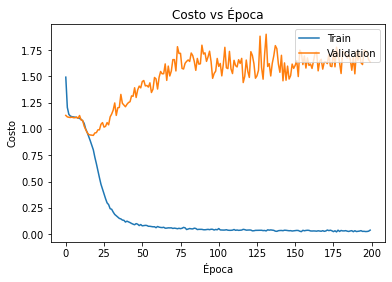

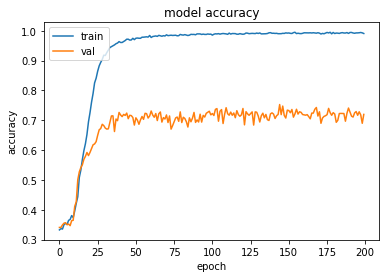

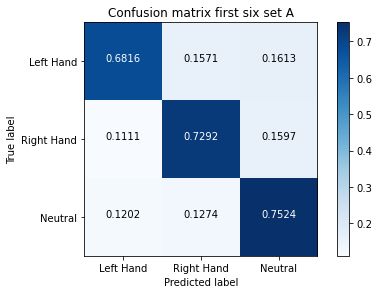

In [7]:
testers(1e-3,model,epochs=200,batch_size=40)

In [78]:
def CNN_LSTM_model_test_2 (filters=128,neurons=200,dropout_rate=0.5,conv_activation='softmax',dense_activation='hard_sigmoid'\
                       ,n_steps=200,n_features=21,activation='tanh', init_mode='glorot_normal',lr=1e-3,batch_normalization=True):
    model = Sequential()
    #CNN
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation),input_shape=(None,n_length,n_features)))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation)))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
#     model.add(TimeDistributed(Dropout(dropout_rate)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    #LSTM
    model.add(LSTM(neurons,activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_normalization:
        model.add(BatchNormalization()) 
    #Dense
    model.add(Dense(neurons,kernel_initializer=init_mode,bias_initializer='zeros'))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, kernel_initializer=init_mode,bias_initializer='zeros'))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Decision
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.001)))
    return model

In [74]:
model = CNN_LSTM_model_test_2()
model.summary()

Model: "sequential_289"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1734 (Time  (None, None, 49, 128)    5504      
 Distributed)                                                    
                                                                 
 time_distributed_1735 (Time  (None, None, 49, 128)    512       
 Distributed)                                                    
                                                                 
 time_distributed_1736 (Time  (None, None, 48, 128)    32896     
 Distributed)                                                    
                                                                 
 time_distributed_1737 (Time  (None, None, 48, 128)    512       
 Distributed)                                                    
                                                                 
 time_distributed_1738 (Time  (None, None, 24, 128) 

Epoch 1/200
272/272 [==============================] - 4s 9ms/step - loss: 1.4217 - accuracy: 0.4135 - val_loss: 1.1003 - val_accuracy: 0.3566
Epoch 2/200
272/272 [==============================] - 2s 7ms/step - loss: 1.0899 - accuracy: 0.4768 - val_loss: 1.0503 - val_accuracy: 0.4985
Epoch 3/200
272/272 [==============================] - 2s 7ms/step - loss: 0.9805 - accuracy: 0.5247 - val_loss: 0.9271 - val_accuracy: 0.5794
Epoch 4/200
272/272 [==============================] - 2s 8ms/step - loss: 0.9140 - accuracy: 0.5669 - val_loss: 0.8614 - val_accuracy: 0.6022
Epoch 5/200
272/272 [==============================] - 2s 8ms/step - loss: 0.8433 - accuracy: 0.6069 - val_loss: 0.8015 - val_accuracy: 0.6276
Epoch 6/200
272/272 [==============================] - 2s 8ms/step - loss: 0.7661 - accuracy: 0.6554 - val_loss: 0.7874 - val_accuracy: 0.6471
Epoch 7/200
272/272 [==============================] - 2s 8ms/step - loss: 0.6684 - accuracy: 0.7161 - val_loss: 0.6848 - val_accuracy: 0.7074

Epoch 58/200
272/272 [==============================] - 2s 8ms/step - loss: 0.0623 - accuracy: 0.9789 - val_loss: 0.7933 - val_accuracy: 0.8485
Epoch 59/200
272/272 [==============================] - 2s 8ms/step - loss: 0.0573 - accuracy: 0.9807 - val_loss: 0.8656 - val_accuracy: 0.8438
Epoch 60/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0540 - accuracy: 0.9833 - val_loss: 0.8649 - val_accuracy: 0.8471
Epoch 61/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0510 - accuracy: 0.9839 - val_loss: 0.8558 - val_accuracy: 0.8544
Epoch 62/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0510 - accuracy: 0.9844 - val_loss: 0.8110 - val_accuracy: 0.8548
Epoch 63/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0505 - accuracy: 0.9842 - val_loss: 0.8422 - val_accuracy: 0.8419
Epoch 64/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0455 - accuracy: 0.9845 - val_loss: 0.8891 - val_accuracy:

Epoch 115/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0260 - accuracy: 0.9919 - val_loss: 0.9540 - val_accuracy: 0.8496
Epoch 116/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0270 - accuracy: 0.9916 - val_loss: 0.9776 - val_accuracy: 0.8471
Epoch 117/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0314 - accuracy: 0.9896 - val_loss: 1.0286 - val_accuracy: 0.8390
Epoch 118/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0300 - accuracy: 0.9917 - val_loss: 0.9275 - val_accuracy: 0.8518
Epoch 119/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0314 - accuracy: 0.9892 - val_loss: 0.9466 - val_accuracy: 0.8562
Epoch 120/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0237 - accuracy: 0.9931 - val_loss: 1.0364 - val_accuracy: 0.8441
Epoch 121/200
272/272 [==============================] - 2s 8ms/step - loss: 0.0315 - accuracy: 0.9919 - val_loss: 0.8995 - val_ac

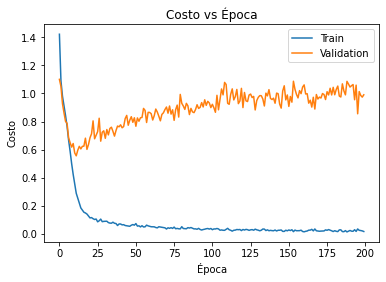

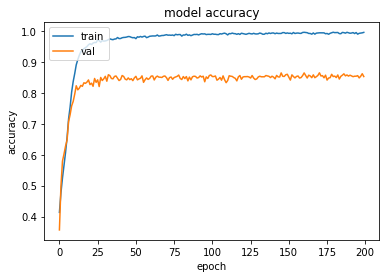

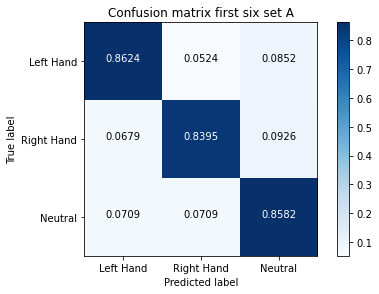

In [75]:
testers(1e-3,model,epochs=200,batch_size=40)

In [82]:
model = CNN_LSTM_model_test_2()
model.summary()

Model: "sequential_291"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1746 (Time  (None, None, 24, 128)    5504      
 Distributed)                                                    
                                                                 
 time_distributed_1747 (Time  (None, None, 24, 128)    512       
 Distributed)                                                    
                                                                 
 time_distributed_1748 (Time  (None, None, 23, 128)    32896     
 Distributed)                                                    
                                                                 
 time_distributed_1749 (Time  (None, None, 23, 128)    512       
 Distributed)                                                    
                                                                 
 time_distributed_1750 (Time  (None, None, 11, 128) 

Epoch 1/200
272/272 [==============================] - 18s 45ms/step - loss: 1.3944 - accuracy: 0.4183 - val_loss: 1.1166 - val_accuracy: 0.3368
Epoch 2/200
272/272 [==============================] - 15s 56ms/step - loss: 1.1037 - accuracy: 0.4677 - val_loss: 1.0658 - val_accuracy: 0.3860
Epoch 3/200
272/272 [==============================] - 4s 15ms/step - loss: 0.9904 - accuracy: 0.5230 - val_loss: 0.9452 - val_accuracy: 0.5353
Epoch 4/200
272/272 [==============================] - 3s 11ms/step - loss: 0.9380 - accuracy: 0.5523 - val_loss: 0.9033 - val_accuracy: 0.5684
Epoch 5/200
272/272 [==============================] - 3s 10ms/step - loss: 0.8954 - accuracy: 0.5793 - val_loss: 0.8829 - val_accuracy: 0.5713
Epoch 6/200
272/272 [==============================] - 3s 13ms/step - loss: 0.8432 - accuracy: 0.6118 - val_loss: 0.8112 - val_accuracy: 0.6338
Epoch 7/200
272/272 [==============================] - 3s 11ms/step - loss: 0.7870 - accuracy: 0.6496 - val_loss: 0.7734 - val_accurac

Epoch 58/200
272/272 [==============================] - 4s 15ms/step - loss: 0.0546 - accuracy: 0.9824 - val_loss: 0.9172 - val_accuracy: 0.8338
Epoch 59/200
272/272 [==============================] - 3s 13ms/step - loss: 0.0704 - accuracy: 0.9767 - val_loss: 0.9108 - val_accuracy: 0.8132
Epoch 60/200
272/272 [==============================] - 4s 13ms/step - loss: 0.0634 - accuracy: 0.9782 - val_loss: 0.9031 - val_accuracy: 0.8379
Epoch 61/200
272/272 [==============================] - 3s 13ms/step - loss: 0.0614 - accuracy: 0.9816 - val_loss: 0.8971 - val_accuracy: 0.8474
Epoch 62/200
272/272 [==============================] - 3s 11ms/step - loss: 0.0549 - accuracy: 0.9831 - val_loss: 0.8513 - val_accuracy: 0.8441
Epoch 63/200
272/272 [==============================] - 3s 11ms/step - loss: 0.0485 - accuracy: 0.9842 - val_loss: 0.9130 - val_accuracy: 0.8419
Epoch 64/200
272/272 [==============================] - 3s 10ms/step - loss: 0.0530 - accuracy: 0.9843 - val_loss: 0.9268 - val_ac

Epoch 115/200
272/272 [==============================] - 2s 8ms/step - loss: 0.0391 - accuracy: 0.9883 - val_loss: 0.8366 - val_accuracy: 0.8482
Epoch 116/200
272/272 [==============================] - 2s 8ms/step - loss: 0.0320 - accuracy: 0.9906 - val_loss: 0.8817 - val_accuracy: 0.8518
Epoch 117/200
272/272 [==============================] - 2s 8ms/step - loss: 0.0256 - accuracy: 0.9936 - val_loss: 0.9854 - val_accuracy: 0.8467
Epoch 118/200
272/272 [==============================] - 3s 10ms/step - loss: 0.0321 - accuracy: 0.9909 - val_loss: 0.8492 - val_accuracy: 0.8412
Epoch 119/200
272/272 [==============================] - 2s 8ms/step - loss: 0.0429 - accuracy: 0.9868 - val_loss: 0.8900 - val_accuracy: 0.8515
Epoch 120/200
272/272 [==============================] - 2s 8ms/step - loss: 0.0405 - accuracy: 0.9881 - val_loss: 0.9020 - val_accuracy: 0.8423
Epoch 121/200
272/272 [==============================] - 2s 8ms/step - loss: 0.0219 - accuracy: 0.9945 - val_loss: 0.9723 - val_a

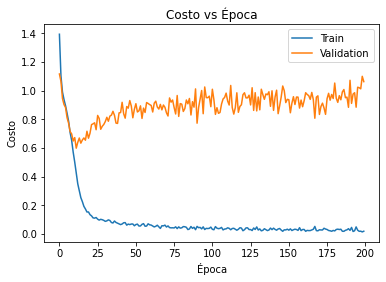

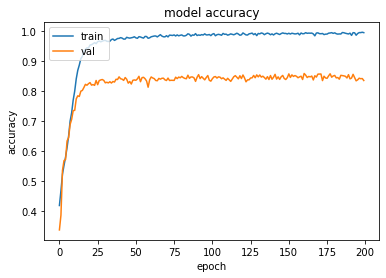

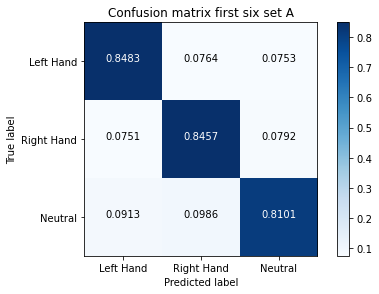

In [83]:
testers(1e-3,model,epochs=200,batch_size=40)